## Introduction

This project aims to train a classification model that can predict if a user will accept a coupon given his/her answers to some survey questions. In this notebook, we will explore the feature engineering methods for categorical data.

The attributes of the data set include:

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper: 
Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

**User attributes**
* gender: male, female
* age: 21, 46, 26, 31, 41, 50plus, 36, below21 (e.g. 21 means 21 to 26, 26 means 26 to 31)
* maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed 
* has_Children:1, 0 
* education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
* occupation: Unemployed, Architecture & Engineering, Student, Education&Training&Library, Healthcare Support, Healthcare Practitioners & Technical, Sales & Related, Management, Arts Design Entertainment Sports & Media, Computer & Mathematical, Life Physical Social Science, Personal Care & Service, Community & Social Services, Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair, Transportation & Material Moving, Business & Financial, Protective Service, Food Preparation & Serving Related, Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry 
* income: \\$37500 - \\$49999, \\$62500 - \\$74999, \\$12500 - \\$24999, \\$75000 - \\$87499, \\$50000 - \\$62499, \\$25000 - \\$37499, \\$100000 or More, \\$87500 - \\$99999, Less than \\$12500 
* Bar: never, less1, 1\~3, gt8, nan4\~8 (feature meaning: how many times do you go to a bar every month?) 
* CoffeeHouse: never, less1, 4\~8, 1\~3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)
* CarryAway:n4\~8, 1\~3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?) 
* RestaurantLessThan20: 4\~8, 1\~3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?) 
* Restaurant20To50: 1\~3, less1, never, gt8, 4\~8, nan (feature meaning: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?) 

**Contextual attributes**
* destination: No Urgent Place, Home, Work 
* passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)
* weather: Sunny, Rainy, Snowy 
* temperature:55, 80, 30 
* time: 2PM, 10AM, 6PM, 7AM, 10PM 
* toCoupon_GEQ5min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 5 minutes) 
* toCoupon_GEQ15min:0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes) 
* toCoupon_GEQ25min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes) 
* direction_same:0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 
* direction_opp:1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination) 

**Coupon attributes**
* coupon: Restaurant(<\\$20), Coffee House, Carry out & Take away, Bar, Restaurant(\\$20-\\$50) 
* expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours) 

The notebook consists of the following main sections:

1. [Visual inspection of your data](#visual_inspection)
2. [Data quality checks](#data_quality)
3. [Exploratory data visualization](#eda)
4. [Feature engineering](#feat_engineering)
5. [Feature selection](#feat_selection)
6. [Feature scaling](#feat_scaling)

## Loading packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 100)

## Loading data

In [2]:
train = pd.read_csv('CouponRecommendation.csv')
test = train.copy()

<a class="anchor" id="visual_inspection"></a>

## Data at first sight

In [3]:
train.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner   
1           Coffee House         2h  Female  21  Unmarried partner   
2  Carry out & Take away         2h  Female  21  Unmarried partner   
3           Coffee House         2h  Female  21  Unmarried partner   
4           Coffee House         1d  Female  21  Unmarried partner   

   has_children                 education  occupation           income  car  \
0             1  Some college - no degree  Unemployed  $37500 - $49999  NaN   
1             1  Some college - no degree  Unemployed  $37500 - $49999  NaN   
2             1  Some college - no degree  Unemployed  $37500 - $49999  NaN   
3             1  Some college - no degree  Unemployed  $37500 - $49999  NaN   
4             1  Some college - no degree  Unemployed  $37500 - $49999  NaN   

     Bar CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0  never       never       NaN                  4~8              1~3   
1  never       never       NaN                  4~8              1~3   
2  never       never       NaN                  4~8              1~3   
3  never       never       NaN                  4~8              1~3   
4  never       never       NaN                  4~8              1~3   

   toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  \
0                 1                  0                  0               0   
1                 1                  0                  0               0   
2                 1                  1                  0               0   
3                 1                  1                  0               0   
4                 1                  1                  0               0   

   direction_opp  Y  
0              1  1  
1              1  0  
2              1  1  
3              1  0  
4              1  0

In [4]:
train.tail()

destination passanger weather  temperature time                 coupon  \
12679        Home   Partner   Rainy           55  6PM  Carry out & Take away   
12680        Work     Alone   Rainy           55  7AM  Carry out & Take away   
12681        Work     Alone   Snowy           30  7AM           Coffee House   
12682        Work     Alone   Snowy           30  7AM                    Bar   
12683        Work     Alone   Sunny           80  7AM      Restaurant(20-50)   

      expiration gender age maritalStatus  has_children         education  \
12679         1d   Male  26        Single             0  Bachelors degree   
12680         1d   Male  26        Single             0  Bachelors degree   
12681         1d   Male  26        Single             0  Bachelors degree   
12682         1d   Male  26        Single             0  Bachelors degree   
12683         2h   Male  26        Single             0  Bachelors degree   

            occupation           income  car    Bar CoffeeHouse CarryAway  \
12679  Sales & Related  $75000 - $87499  NaN  never       never       1~3   
12680  Sales & Related  $75000 - $87499  NaN  never       never       1~3   
12681  Sales & Related  $75000 - $87499  NaN  never       never       1~3   
12682  Sales & Related  $75000 - $87499  NaN  never       never       1~3   
12683  Sales & Related  $75000 - $87499  NaN  never       never       1~3   

      RestaurantLessThan20 Restaurant20To50  toCoupon_GEQ5min  \
12679                  4~8              1~3                 1   
12680                  4~8              1~3                 1   
12681                  4~8              1~3                 1   
12682                  4~8              1~3                 1   
12683                  4~8              1~3                 1   

       toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  direction_opp  Y  
12679                  0                  0               1              0  1  
12680                  0                  0               0              1  1  
12681                  0                  0               1              0  0  
12682                  1                  1               0              1  0  
12683                  0                  0               1              0  0

We indeed see the following
* binary variables
* categorical variables 
* other variables with integer 
* the target variable

Let's look at the number of rows and columns in the train data.

In [5]:
train.shape

(12684, 26)

We have 25 variables and 12684 rows. Let's see if we have the same number of variables in the test data.<br>
Let's see if there are duplicate rows in the training data.

In [6]:
train.drop_duplicates()
train.shape

(12684, 26)

In [7]:
test.drop('Y', axis=1, inplace=True)
test.shape

(12684, 25)

No duplicate rows, so that's fine.

We are missing one variable in the test set, but this is the target (Y) variable. So that's fine.<br>
Let's now invesigate how many variables of each type we have.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [9]:
# Identify the categorical columns
categorical_columns = train.select_dtypes(include='object').columns

# Calculate the unique values for each categorical column
unique_values = {}
for column in categorical_columns:
    unique_values[column] = train[column].unique()

# Display the unique values for each categorical column
print(unique_values)

{'destination': array(['No Urgent Place', 'Home', 'Work'], dtype=object), 'passanger': array(['Alone', 'Friend(s)', 'Kid(s)', 'Partner'], dtype=object), 'weather': array(['Sunny', 'Rainy', 'Snowy'], dtype=object), 'time': array(['2PM', '10AM', '6PM', '7AM', '10PM'], dtype=object), 'coupon': array(['Restaurant(<20)', 'Coffee House', 'Carry out & Take away', 'Bar',
       'Restaurant(20-50)'], dtype=object), 'expiration': array(['1d', '2h'], dtype=object), 'gender': array(['Female', 'Male'], dtype=object), 'age': array(['21', '46', '26', '31', '41', '50plus', '36', 'below21'],
      dtype=object), 'maritalStatus': array(['Unmarried partner', 'Single', 'Married partner', 'Divorced',
       'Widowed'], dtype=object), 'education': array(['Some college - no degree', 'Bachelors degree',
       'Associates degree', 'High School Graduate',
       'Graduate degree (Masters or Doctorate)', 'Some High School'],
      dtype=object), 'occupation': array(['Unemployed', 'Architecture & Engineering', '

A different look on our categorical data

In [10]:
import plotly.express as px
cut_counts = train['Bar'].value_counts()
fig = px.bar(x=cut_counts.index, y=cut_counts.values)
fig.show()

In [11]:
print(train['destination'].value_counts())
print(train['passanger'].value_counts())
print(train['weather'].value_counts())
print(train['coupon'].value_counts())
print(train['gender'].value_counts())
print(train['maritalStatus'].value_counts())
print(train['Restaurant20To50'].value_counts())
print(train['expiration'].value_counts())
print(train['income'].value_counts())
print(test['occupation'].value_counts())

No Urgent Place    6283
Home               3237
Work               3164
Name: destination, dtype: int64
Alone        7305
Friend(s)    3298
Partner      1075
Kid(s)       1006
Name: passanger, dtype: int64
Sunny    10069
Snowy     1405
Rainy     1210
Name: weather, dtype: int64
Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon, dtype: int64
Female    6511
Male      6173
Name: gender, dtype: int64
Married partner      5100
Single               4752
Unmarried partner    2186
Divorced              516
Widowed               130
Name: maritalStatus, dtype: int64
less1    6077
1~3      3290
never    2136
4~8       728
gt8       264
Name: Restaurant20To50, dtype: int64
1d    7091
2h    5593
Name: expiration, dtype: int64
$25000 - $37499     2013
$12500 - $24999     1831
$37500 - $49999     1805
$100000 or More     1736
$50000 - $62499     1659
Less than $12500    1042
$87500 - $999

<a class="anchor" id="metadata"></a>

## Data Quality Checks

### Checking missing values

In [12]:
test.isnull().sum()


destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
dtype: int64

- **Car** have a large proportion of  records with missing values. We're gonna remove the variable.

In [13]:
train.drop(columns=['car'], inplace=True)

In [14]:
features_with_missing_values = train.columns[train.isnull().any()].tolist()
for feature in features_with_missing_values:
    train[feature].fillna(train[feature].mode()[0], inplace=True)
train.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

### Identifying Outliers

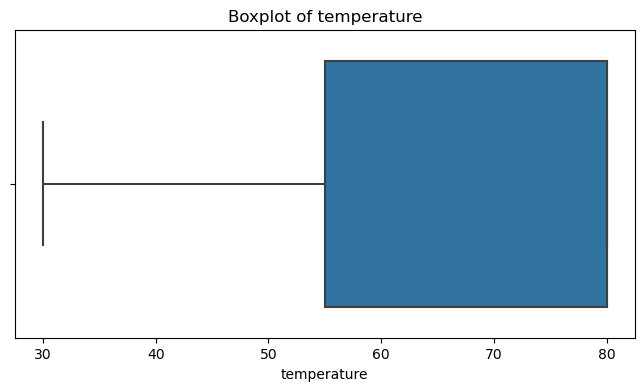

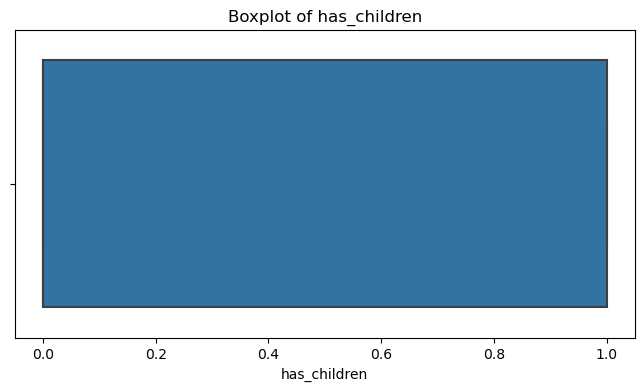

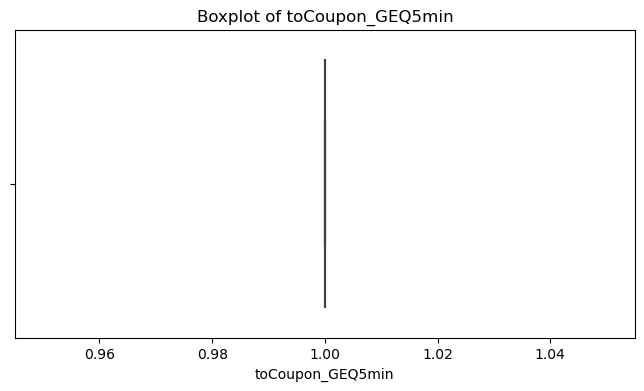

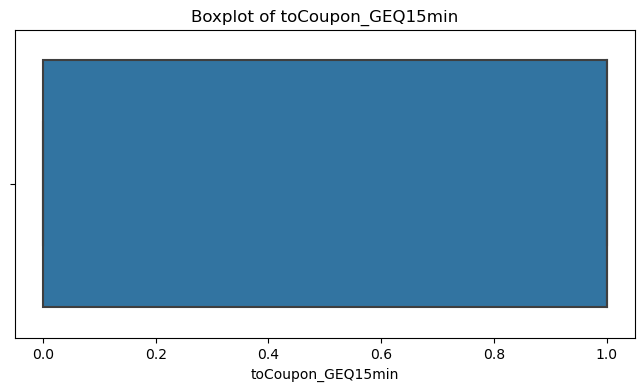

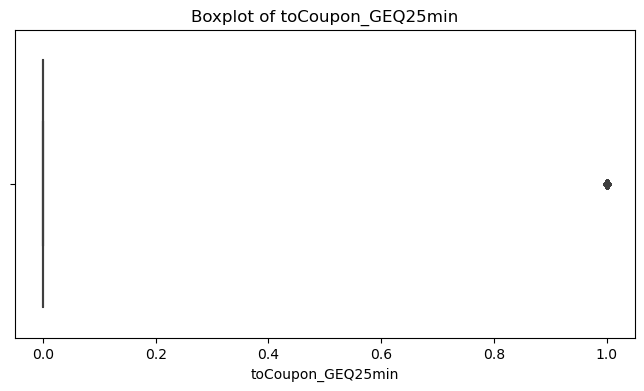

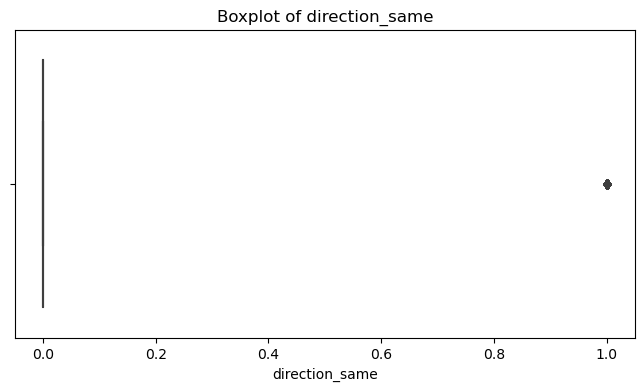

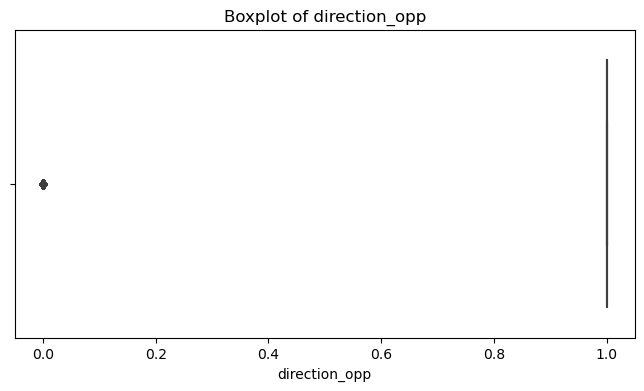

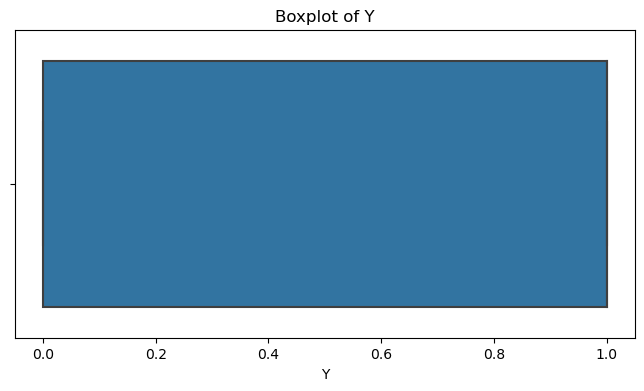

In [15]:
numerical_features = train.select_dtypes(include="int64").columns
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=feature, data=train)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()

### Checking the correlation between our numerical features

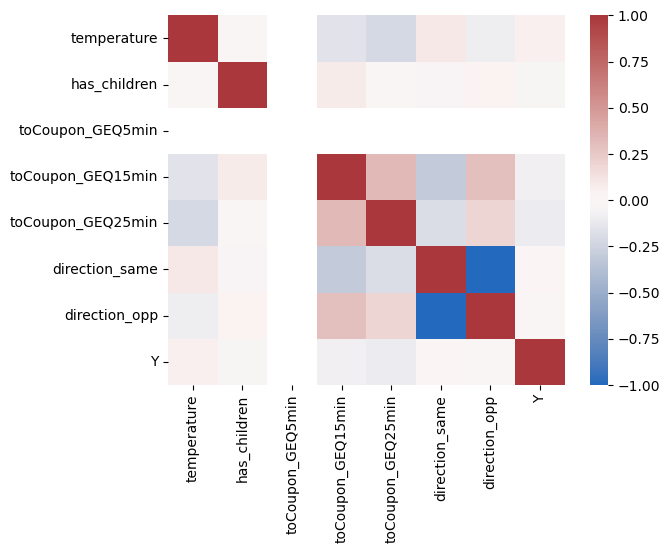

In [16]:
cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(train.select_dtypes('int64', 'float64').corr(), cmap=cmap)
plt.show()

As the heatmap shows, there are two columns sharing the same information: **direction_same** and **direction_opp**. They indicate whether the restaurant/bar is in the same direction as your current destination. So we decide to delete the **direction_opp** column.

In [17]:
train.drop(columns=['direction_opp'], inplace=True)

### Checking the cardinality of the categorical variables
Cardinality refers to the number of different values in a variable. As we will create dummy variables from the categorical variables later on, we need to check whether there are variables with many distinct values. We should handle these variables differently as they would result in many dummy variables.

In [18]:
for f in train:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable destination has 3 distinct values
Variable passanger has 4 distinct values
Variable weather has 3 distinct values
Variable temperature has 3 distinct values
Variable time has 5 distinct values
Variable coupon has 5 distinct values
Variable expiration has 2 distinct values
Variable gender has 2 distinct values
Variable age has 8 distinct values
Variable maritalStatus has 5 distinct values
Variable has_children has 2 distinct values
Variable education has 6 distinct values
Variable occupation has 25 distinct values
Variable income has 9 distinct values
Variable Bar has 5 distinct values
Variable CoffeeHouse has 5 distinct values
Variable CarryAway has 5 distinct values
Variable RestaurantLessThan20 has 5 distinct values
Variable Restaurant20To50 has 5 distinct values
Variable toCoupon_GEQ5min has 1 distinct values
Variable toCoupon_GEQ15min has 2 distinct values
Variable toCoupon_GEQ25min has 2 distinct values
Variable direction_same has 2 distinct values
Variable Y has 2 distin

Only **occupation** has many distinct values. 

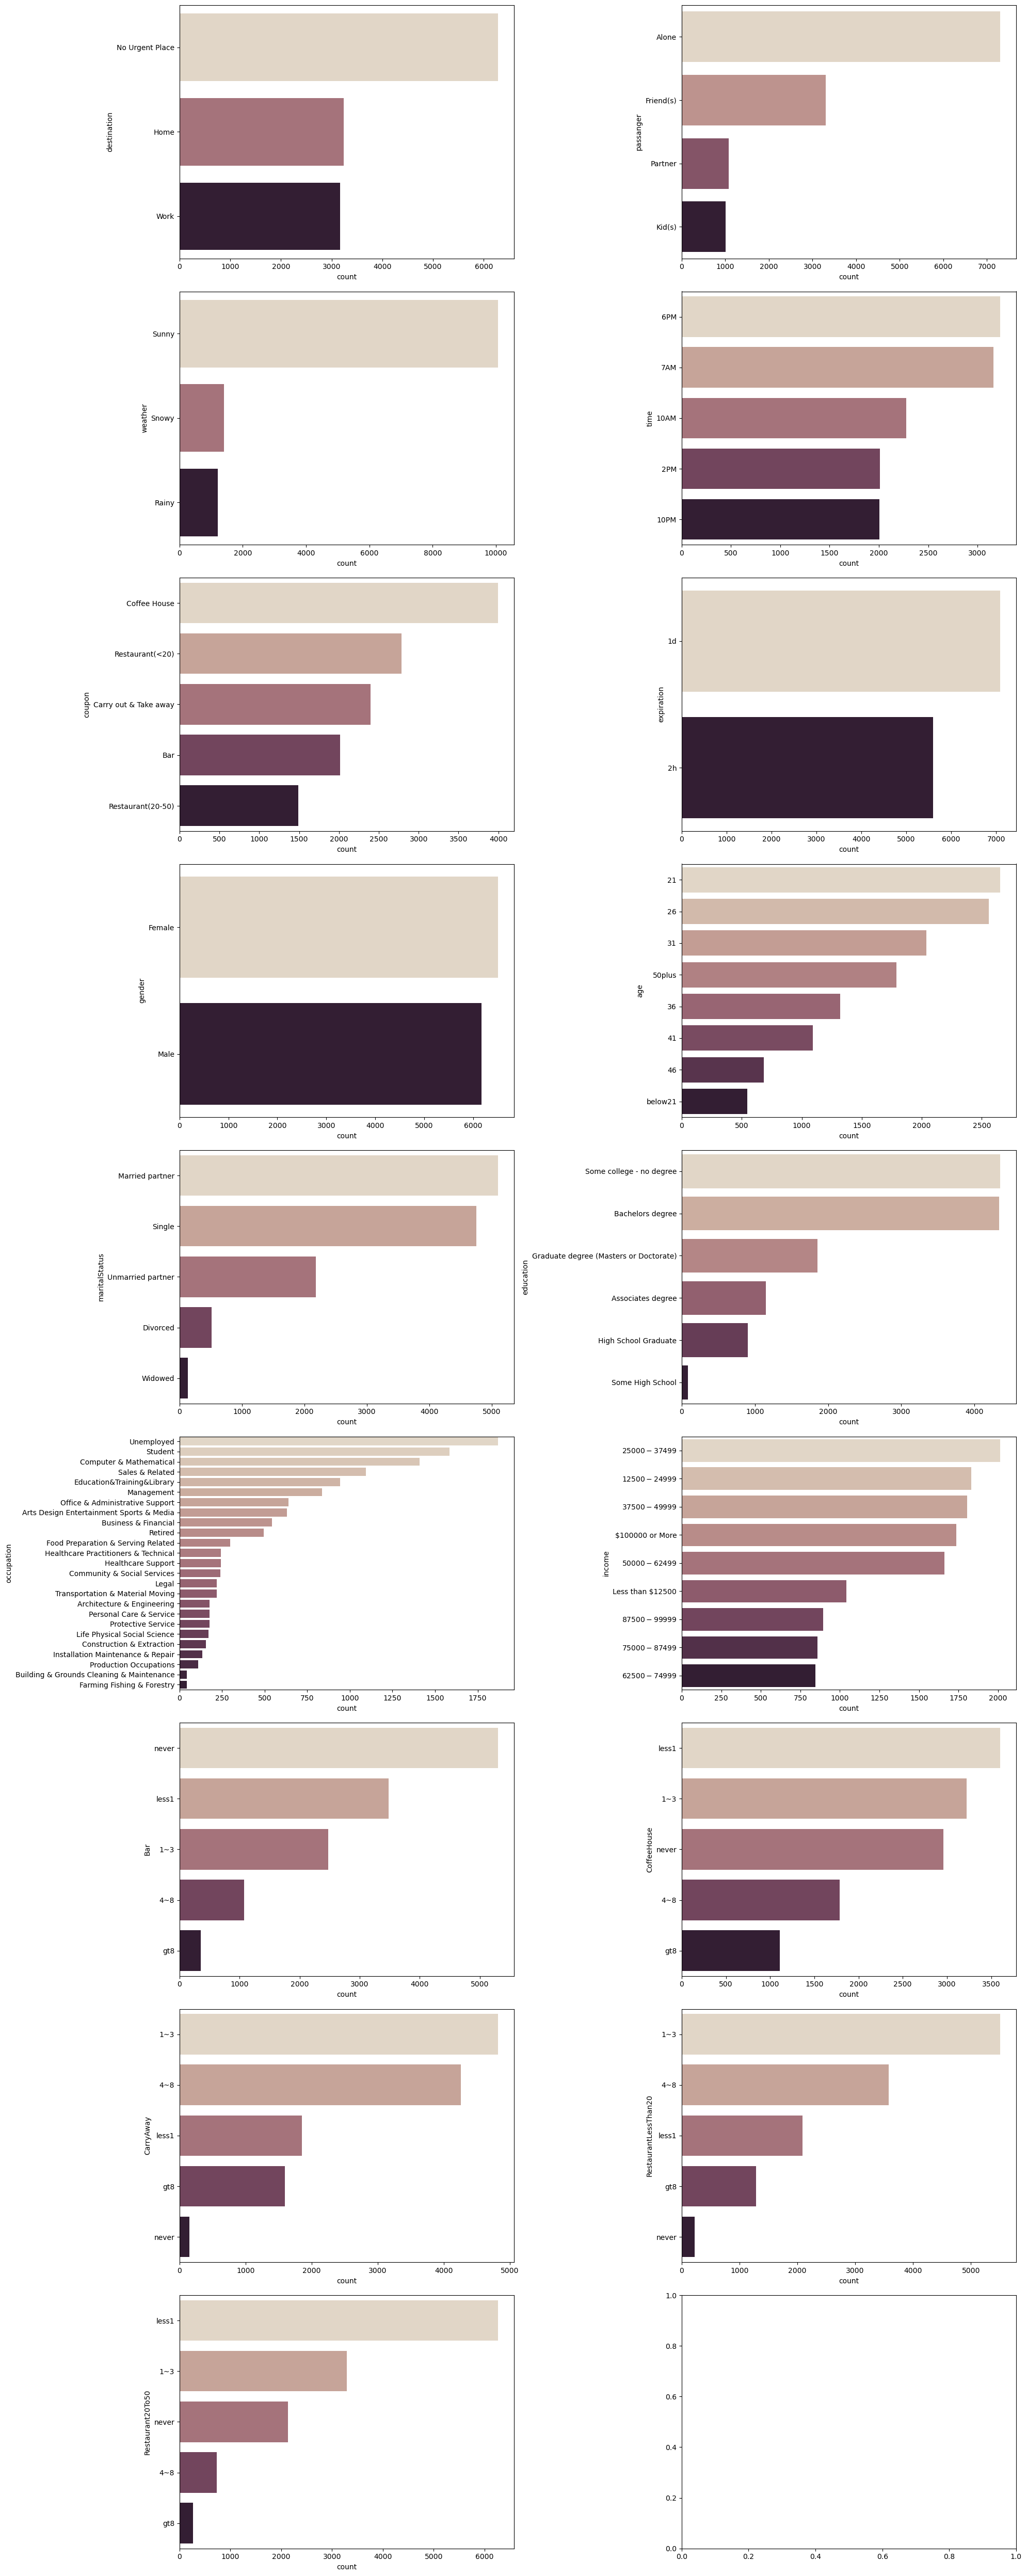

In [19]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, train.select_dtypes('object').columns):
    sns.countplot(y=col, data=train, ax=ax, 
                  palette="ch:.25", order=train[col].value_counts().index);

plt.tight_layout()
plt.show()

By looking at the counting plot of the categorical features, we realized that there are two kinds of categorical data: ordinal and nominal, we can apply one hot encoder to nominal features, however, ordinal data should be mapped into numerical data so that the inner order can preserve.

Those ordinal features are: 

* **Restaurant20To50**: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?
* **RestaurantLessThan20**: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?
* **CarryAway**: how many times do you get take-away food every month?
* **CoffeeHouse**: how many times do you go to a coffeehouse every month?
* **age**: quite self-explanatory
* **Bar**: how many times do you go to bar every month?
* **income**:  
* **Time**: 

In [20]:
# Define a mapping for income ranges
income_mapping = {
    'Less than $12500': 1,
    '$12500 - $24999': 2,
    '$25000 - $37499': 3,
    '$37500 - $49999': 4,
    '$50000 - $62499': 5,
    '$62500 - $74999': 6,
    '$75000 - $87499': 7,
    '$87500 - $99999': 8,
    '$100000 or More': 9
}

order_mapping = {
    'never': 1,
    'less1': 2,
    '1~3': 3,
    '4~8': 4,
    'gt8': 5
}

age_mapping = {
    'below21': 1,
    '21': 2,
    '26': 3,
    '31': 4,
    '36': 5,
    '41': 6,
    '46': 7,
    '50plus': 8
}
'2PM', '10AM', '6PM', '7AM', '10PM'
time_mapping = {
    '7AM': 1,
    '10AM': 2,
    '2PM': 3,
    '6PM': 4,
    '10PM': 5
}

# Apply the mapping to the "income" column
train['income_encoded'] = train['income'].map(income_mapping)
train['bar_encoded'] = train['Bar'].map(order_mapping)
train['coffeeH _encoded'] = train['CoffeeHouse'].map(order_mapping)
train['carryA_encoded'] = train['CarryAway'].map(order_mapping)
train['resto20_encoded'] = train['RestaurantLessThan20'].map(order_mapping)
train['resto20To50_encoded'] = train['Restaurant20To50'].map(order_mapping)
train['age_encoded'] = train['age'].map(age_mapping)
train['time_encoded'] = train['time'].map(time_mapping)


# Print the DataFrame with the encoded income column
train.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner   
1           Coffee House         2h  Female  21  Unmarried partner   
2  Carry out & Take away         2h  Female  21  Unmarried partner   
3           Coffee House         2h  Female  21  Unmarried partner   
4           Coffee House         1d  Female  21  Unmarried partner   

   has_children                 education  occupation           income    Bar  \
0             1  Some college - no degree  Unemployed  $37500 - $49999  never   
1             1  Some college - no degree  Unemployed  $37500 - $49999  never   
2             1  Some college - no degree  Unemployed  $37500 - $49999  never   
3             1  Some college - no degree  Unemployed  $37500 - $49999  never   
4             1  Some college - no degree  Unemployed  $37500 - $49999  never   

  CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0       never       1~3                  4~8              1~3   
1       never       1~3                  4~8              1~3   
2       never       1~3                  4~8              1~3   
3       never       1~3                  4~8              1~3   
4       never       1~3                  4~8              1~3   

   toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  Y  \
0                 1                  0                  0               0  1   
1                 1                  0                  0               0  0   
2                 1                  1                  0               0  1   
3                 1                  1                  0               0  0   
4                 1                  1                  0               0  0   

   income_encoded  bar_encoded  coffeeH _encoded  carryA_encoded  \
0               4            1                 1               3   
1               4            1                 1               3   
2               4            1                 1               3   
3               4            1                 1               3   
4               4            1                 1               3   

   resto20_encoded  resto20To50_encoded  age_encoded  time_encoded  
0                4                    3            2             3  
1                4                    3            2             2  
2                4                    3            2             2  
3                4                    3            2             3  
4                4                    3            2             3

### Label Encoding

In [21]:
label_encoder = LabelEncoder()

# Label encode the "gender" column
#0 female 
#1 male
train['gender_encoded'] = label_encoder.fit_transform(train['gender'])

# Label encode the "expiration" column
#0 1d 
#1 2h
train['expiration_encoded'] = label_encoder.fit_transform(train['expiration'])

train.head()


destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner   
1           Coffee House         2h  Female  21  Unmarried partner   
2  Carry out & Take away         2h  Female  21  Unmarried partner   
3           Coffee House         2h  Female  21  Unmarried partner   
4           Coffee House         1d  Female  21  Unmarried partner   

   has_children                 education  occupation           income    Bar  \
0             1  Some college - no degree  Unemployed  $37500 - $49999  never   
1             1  Some college - no degree  Unemployed  $37500 - $49999  never   
2             1  Some college - no degree  Unemployed  $37500 - $49999  never   
3             1  Some college - no degree  Unemployed  $37500 - $49999  never   
4             1  Some college - no degree  Unemployed  $37500 - $49999  never   

  CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0       never       1~3                  4~8              1~3   
1       never       1~3                  4~8              1~3   
2       never       1~3                  4~8              1~3   
3       never       1~3                  4~8              1~3   
4       never       1~3                  4~8              1~3   

   toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  Y  \
0                 1                  0                  0               0  1   
1                 1                  0                  0               0  0   
2                 1                  1                  0               0  1   
3                 1                  1                  0               0  0   
4                 1                  1                  0               0  0   

   income_encoded  bar_encoded  coffeeH _encoded  carryA_encoded  \
0               4            1                 1               3   
1               4            1                 1               3   
2               4            1                 1               3   
3               4            1                 1               3   
4               4            1                 1               3   

   resto20_encoded  resto20To50_encoded  age_encoded  time_encoded  \
0                4                    3            2             3   
1                4                    3            2             2   
2                4                    3            2             2   
3                4                    3            2             3   
4                4                    3            2             3   

   gender_encoded  expiration_encoded  
0               0                   0  
1               0                   1  
2               0                   1  
3               0                   1  
4               0                   0

### Frequency Encoding

Now, let's look at the occupation feature:

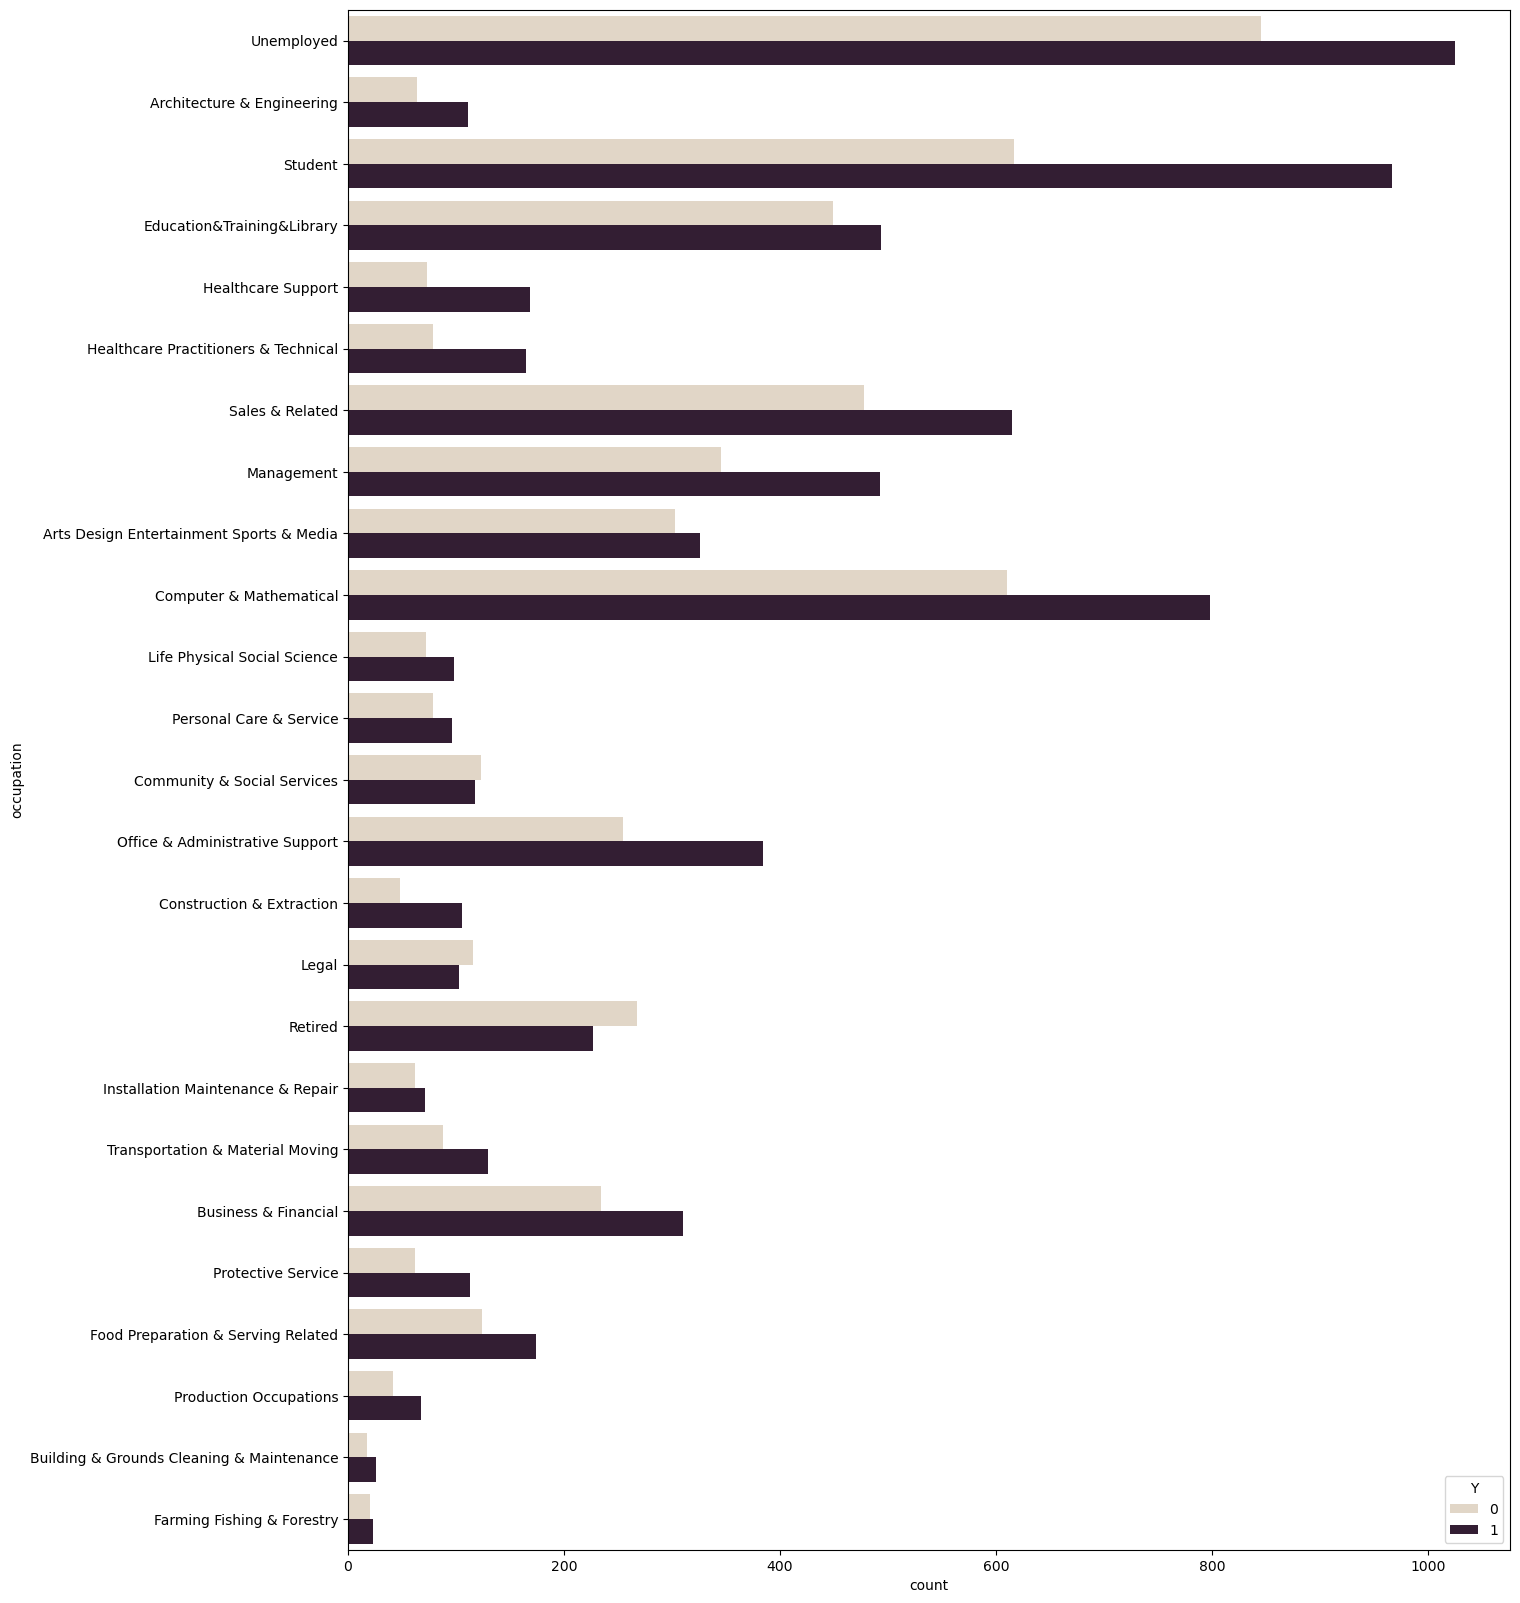

In [22]:
plt.subplots(figsize=(15, 20))
sns.countplot(y ='occupation', hue='Y', data=train, palette='ch:.25');
plt.show()

This plot shows some differences among jobs. 

As a result, we think all those nominal features are strong predictor variables. Thus, we will do frequency encoding and target encoding on them to improve their predictive power. Those two encodings will be done after data splitting.

In [23]:
# Calculate the frequency of each occupation
occupation_frequencies = train['occupation'].value_counts().to_dict()

# Map the frequencies to the "occupation" column
train['occupation_encoded'] = train['occupation'].map(occupation_frequencies)
train.head()


destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner   
1           Coffee House         2h  Female  21  Unmarried partner   
2  Carry out & Take away         2h  Female  21  Unmarried partner   
3           Coffee House         2h  Female  21  Unmarried partner   
4           Coffee House         1d  Female  21  Unmarried partner   

   has_children                 education  occupation           income    Bar  \
0             1  Some college - no degree  Unemployed  $37500 - $49999  never   
1             1  Some college - no degree  Unemployed  $37500 - $49999  never   
2             1  Some college - no degree  Unemployed  $37500 - $49999  never   
3             1  Some college - no degree  Unemployed  $37500 - $49999  never   
4             1  Some college - no degree  Unemployed  $37500 - $49999  never   

  CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0       never       1~3                  4~8              1~3   
1       never       1~3                  4~8              1~3   
2       never       1~3                  4~8              1~3   
3       never       1~3                  4~8              1~3   
4       never       1~3                  4~8              1~3   

   toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  Y  \
0                 1                  0                  0               0  1   
1                 1                  0                  0               0  0   
2                 1                  1                  0               0  1   
3                 1                  1                  0               0  0   
4                 1                  1                  0               0  0   

   income_encoded  bar_encoded  coffeeH _encoded  carryA_encoded  \
0               4            1                 1               3   
1               4            1                 1               3   
2               4            1                 1               3   
3               4            1                 1               3   
4               4            1                 1               3   

   resto20_encoded  resto20To50_encoded  age_encoded  time_encoded  \
0                4                    3            2             3   
1                4                    3            2             2   
2                4                    3            2             2   
3                4                    3            2             3   
4                4                    3            2             3   

   gender_encoded  expiration_encoded  occupation_encoded  
0               0                   0                1870  
1               0                   1                1870  
2               0                   1                1870  
3               0                   1                1870  
4               0                   0                1870

### Label Encoding

In [24]:
# Extract the categorical columns for one-hot encoding
categorical_columns = ['destination', 'passanger', 'weather', 'coupon', 'maritalStatus', 'education']

# Apply one-hot encoding to the categorical columns
train_encoded = pd.get_dummies(train, columns=categorical_columns)

train_encoded.head()

temperature  time expiration  gender age  has_children  occupation  \
0           55   2PM         1d  Female  21             1  Unemployed   
1           80  10AM         2h  Female  21             1  Unemployed   
2           80  10AM         2h  Female  21             1  Unemployed   
3           80   2PM         2h  Female  21             1  Unemployed   
4           80   2PM         1d  Female  21             1  Unemployed   

            income    Bar CoffeeHouse CarryAway RestaurantLessThan20  \
0  $37500 - $49999  never       never       1~3                  4~8   
1  $37500 - $49999  never       never       1~3                  4~8   
2  $37500 - $49999  never       never       1~3                  4~8   
3  $37500 - $49999  never       never       1~3                  4~8   
4  $37500 - $49999  never       never       1~3                  4~8   

  Restaurant20To50  toCoupon_GEQ5min  toCoupon_GEQ15min  toCoupon_GEQ25min  \
0              1~3                 1                  0                  0   
1              1~3                 1                  0                  0   
2              1~3                 1                  1                  0   
3              1~3                 1                  1                  0   
4              1~3                 1                  1                  0   

   direction_same  Y  income_encoded  bar_encoded  coffeeH _encoded  \
0               0  1               4            1                 1   
1               0  0               4            1                 1   
2               0  1               4            1                 1   
3               0  0               4            1                 1   
4               0  0               4            1                 1   

   carryA_encoded  resto20_encoded  resto20To50_encoded  age_encoded  \
0               3                4                    3            2   
1               3                4                    3            2   
2               3                4                    3            2   
3               3                4                    3            2   
4               3                4                    3            2   

   time_encoded  gender_encoded  expiration_encoded  occupation_encoded  \
0             3               0                   0                1870   
1             2               0                   1                1870   
2             2               0                   1                1870   
3             3               0                   1                1870   
4             3               0                   0                1870   

   destination_Home  destination_No Urgent Place  destination_Work  \
0                 0                            1                 0   
1                 0                            1                 0   
2                 0                            1                 0   
3                 0                            1                 0   
4                 0                            1                 0   

   passanger_Alone  passanger_Friend(s)  passanger_Kid(s)  passanger_Partner  \
0                1                    0                 0                  0   
1                0                    1                 0                  0   
2                0                    1                 0                  0   
3                0                    1                 0                  0   
4                0                    1                 0                  0   

   weather_Rainy  weather_Snowy  weather_Sunny  coupon_Bar  \
0              0              0              1           0   
1              0              0              1           0   
2              0              0              1           0   
3              0              0              1           0   
4              0              0              1           0   

   coupon_Carry out & Take away  coupon_Coffee House  \
0                   

### Leaving only our encoded columns in our dataset

In [25]:
# Specify the column indices to drop
columns_to_drop = [1,2, 3, 4, 6, 7, 8, 9, 10, 11]

# Drop the specified columns
train_encoded_dropped = train_encoded.drop(train_encoded.columns[columns_to_drop], axis=1)
train_encoded_droppedY = train_encoded_dropped.drop('Y', axis=1)
train_encoded_droppedY.head()

temperature  has_children Restaurant20To50  toCoupon_GEQ5min  \
0           55             1              1~3                 1   
1           80             1              1~3                 1   
2           80             1              1~3                 1   
3           80             1              1~3                 1   
4           80             1              1~3                 1   

   toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  income_encoded  \
0                  0                  0               0               4   
1                  0                  0               0               4   
2                  1                  0               0               4   
3                  1                  0               0               4   
4                  1                  0               0               4   

   bar_encoded  coffeeH _encoded  carryA_encoded  resto20_encoded  \
0            1                 1               3                4   
1            1                 1               3                4   
2            1                 1               3                4   
3            1                 1               3                4   
4            1                 1               3                4   

   resto20To50_encoded  age_encoded  time_encoded  gender_encoded  \
0                    3            2             3               0   
1                    3            2             2               0   
2                    3            2             2               0   
3                    3            2             3               0   
4                    3            2             3               0   

   expiration_encoded  occupation_encoded  destination_Home  \
0                   0                1870                 0   
1                   1                1870                 0   
2                   1                1870                 0   
3                   1                1870                 0   
4                   0                1870                 0   

   destination_No Urgent Place  destination_Work  passanger_Alone  \
0                            1                 0                1   
1                            1                 0                0   
2                            1                 0                0   
3                            1                 0                0   
4                            1                 0                0   

   passanger_Friend(s)  passanger_Kid(s)  passanger_Partner  weather_Rainy  \
0                    0                 0                  0              0   
1                    1                 0                  0              0   
2                    1                 0                  0              0   
3                    1                 0                  0              0   
4                    1                 0                  0              0   

   weather_Snowy  weather_Sunny  coupon_Bar  coupon_Carry out & Take away  \
0              0              1           0                             0   
1              0              1           0                             0   
2              0              1           0                             1   
3              0              1           0                             0   
4              0              1           0                             0   

   coupon_Coffee House  coupon_Restaurant(20-50)  coupon_Restaurant(<20)  \
0                    0                         0                       1   
1                    1                         0                       0   
2                    0                         0                       0   
3                    1                         0                       0   
4                    1                         0                       0   

   maritalStatus_Divorced  maritalStatus_Married partner  \
0                       0                              0   
1               

In [26]:
train_encoded_droppedY.drop(columns=['Restaurant20To50'], inplace=True)

In [27]:
train_encoded_droppedY.head()

temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
0           55             1                 1                  0   
1           80             1                 1                  0   
2           80             1                 1                  1   
3           80             1                 1                  1   
4           80             1                 1                  1   

   toCoupon_GEQ25min  direction_same  income_encoded  bar_encoded  \
0                  0               0               4            1   
1                  0               0               4            1   
2                  0               0               4            1   
3                  0               0               4            1   
4                  0               0               4            1   

   coffeeH _encoded  carryA_encoded  resto20_encoded  resto20To50_encoded  \
0                 1               3                4                    3   
1                 1               3                4                    3   
2                 1               3                4                    3   
3                 1               3                4                    3   
4                 1               3                4                    3   

   age_encoded  time_encoded  gender_encoded  expiration_encoded  \
0            2             3               0                   0   
1            2             2               0                   1   
2            2             2               0                   1   
3            2             3               0                   1   
4            2             3               0                   0   

   occupation_encoded  destination_Home  destination_No Urgent Place  \
0                1870                 0                            1   
1                1870                 0                            1   
2                1870                 0                            1   
3                1870                 0                            1   
4                1870                 0                            1   

   destination_Work  passanger_Alone  passanger_Friend(s)  passanger_Kid(s)  \
0                 0                1                    0                 0   
1                 0                0                    1                 0   
2                 0                0                    1                 0   
3                 0                0                    1                 0   
4                 0                0                    1                 0   

   passanger_Partner  weather_Rainy  weather_Snowy  weather_Sunny  coupon_Bar  \
0                  0              0              0              1           0   
1                  0              0              0              1           0   
2                  0              0              0              1           0   
3                  0              0              0              1           0   
4                  0              0              0              1           0   

   coupon_Carry out & Take away  coupon_Coffee House  \
0                             0                    0   
1                             0                    1   
2                             1                    0   
3                             0                    1   
4                             0                    1   

   coupon_Restaurant(20-50)  coupon_Restaurant(<20)  maritalStatus_Divorced  \
0                         0                       1                       0   
1                         0                       0                       0   
2                         0                       0                       0   
3                         0                       0                       0   
4                         0                       0                       0   

   maritalStatus_Married partner  maritalStatus_Single  \
0                              0    

<a class="anchor" id="eda"></a>

## Exploratory Data Visualization

### Categorical variables
Let's look into the categorical variables and the proportion of drivers with Y = 1

<Figure size 640x480 with 0 Axes>

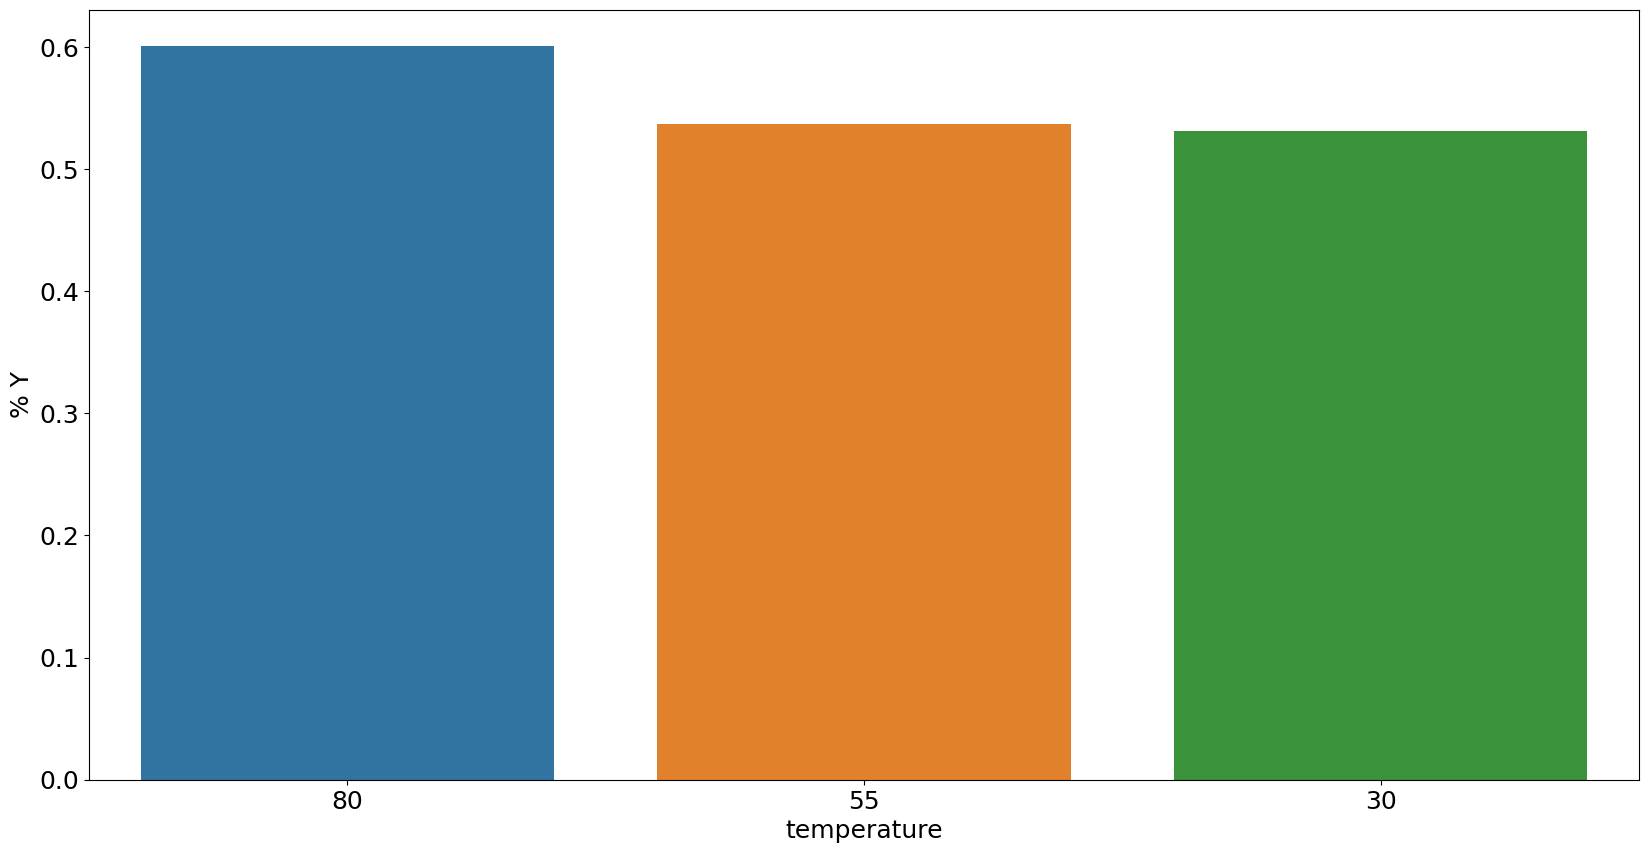

<Figure size 640x480 with 0 Axes>

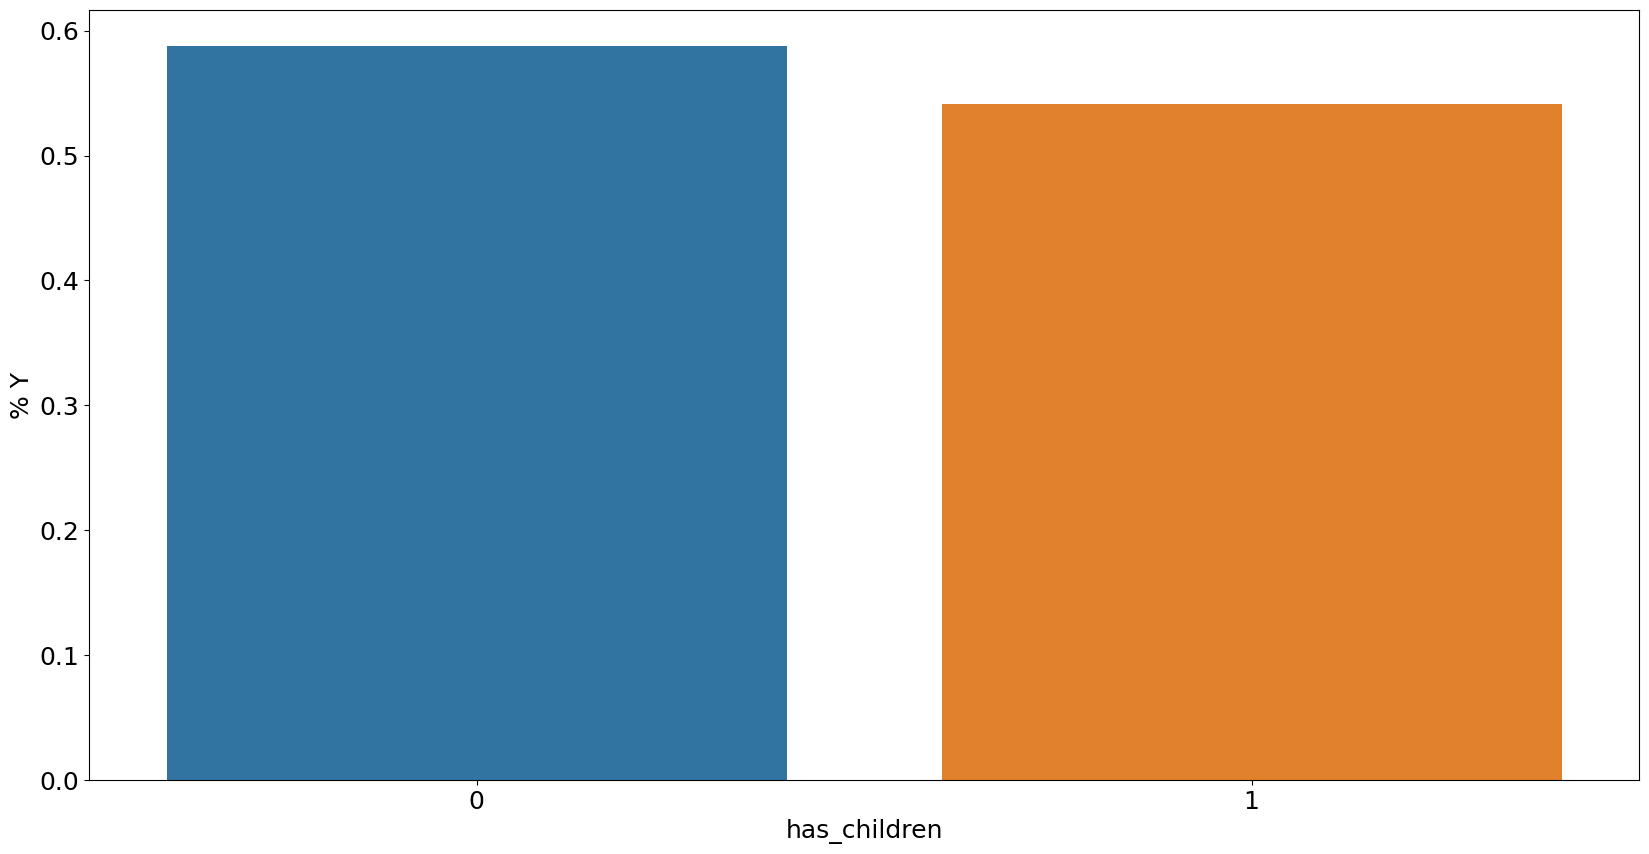

<Figure size 640x480 with 0 Axes>

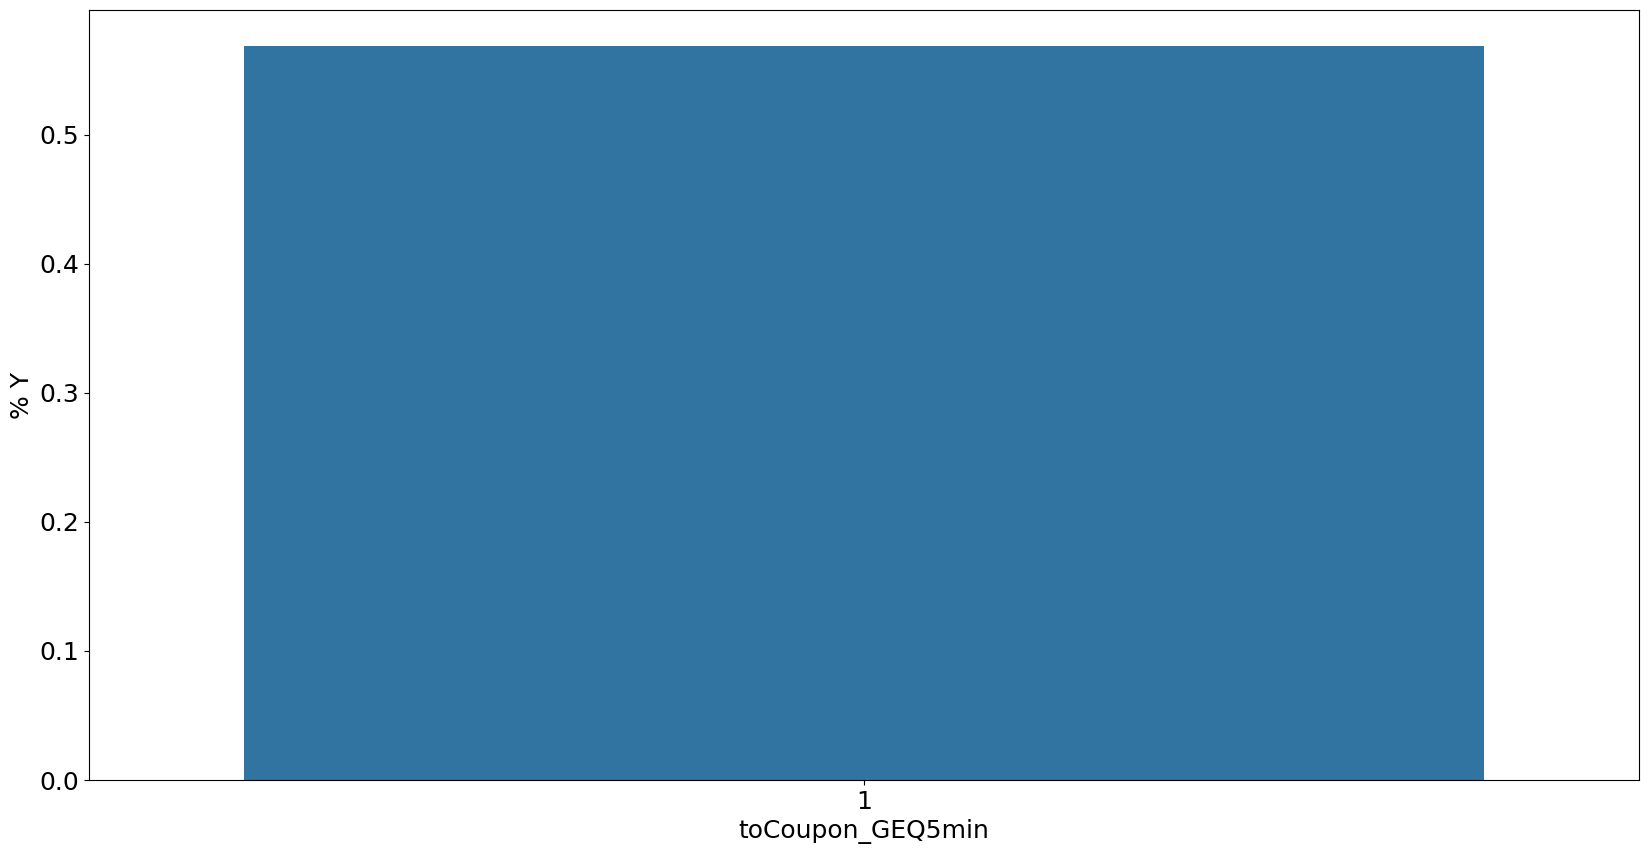

<Figure size 640x480 with 0 Axes>

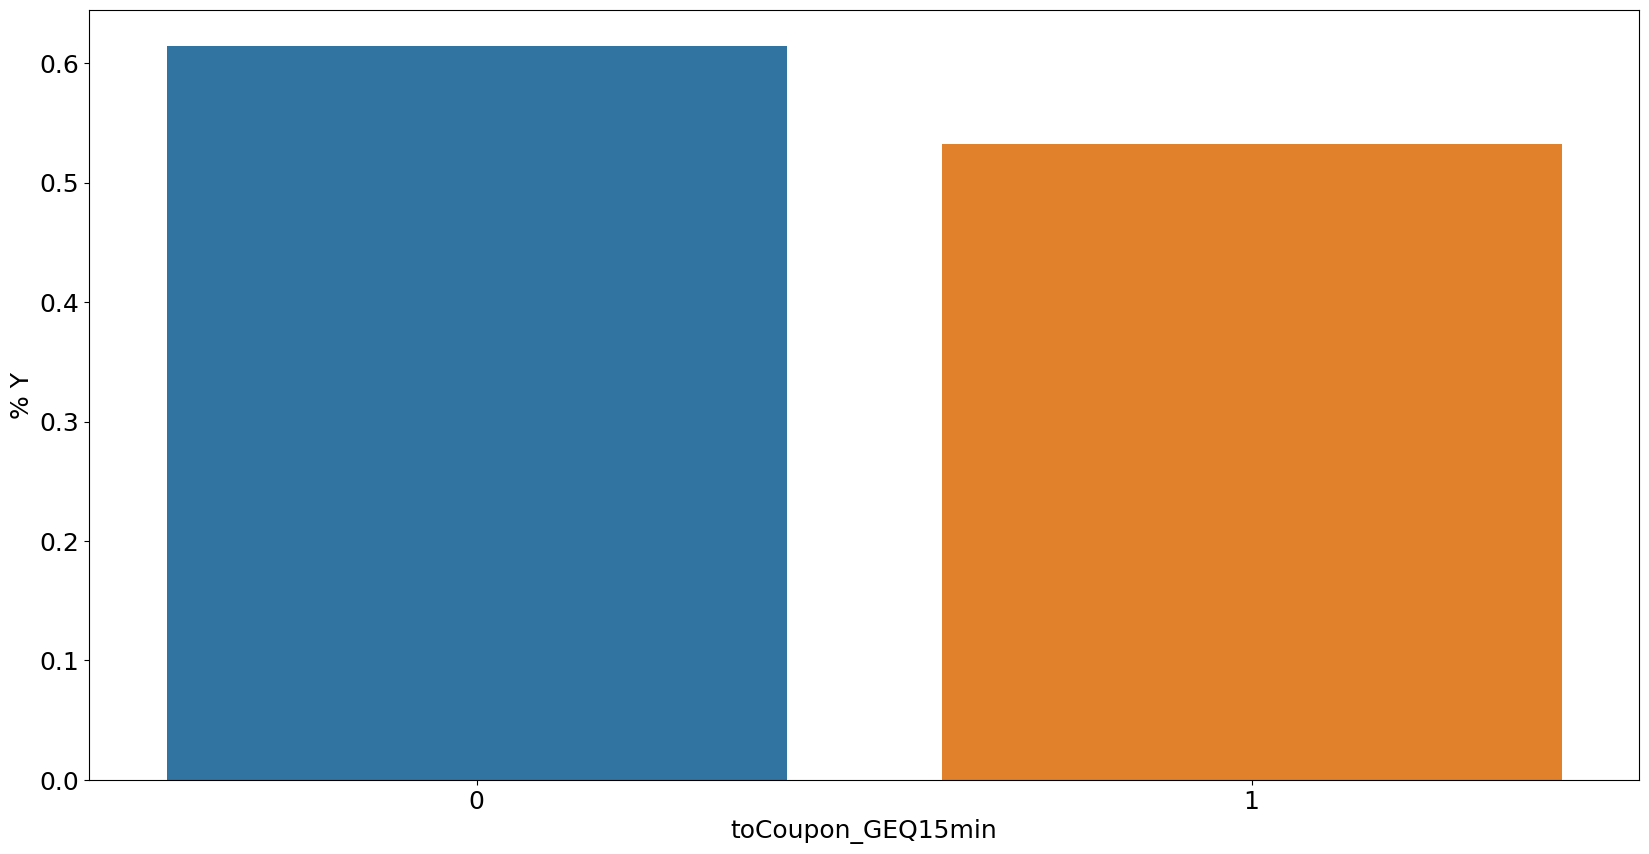

<Figure size 640x480 with 0 Axes>

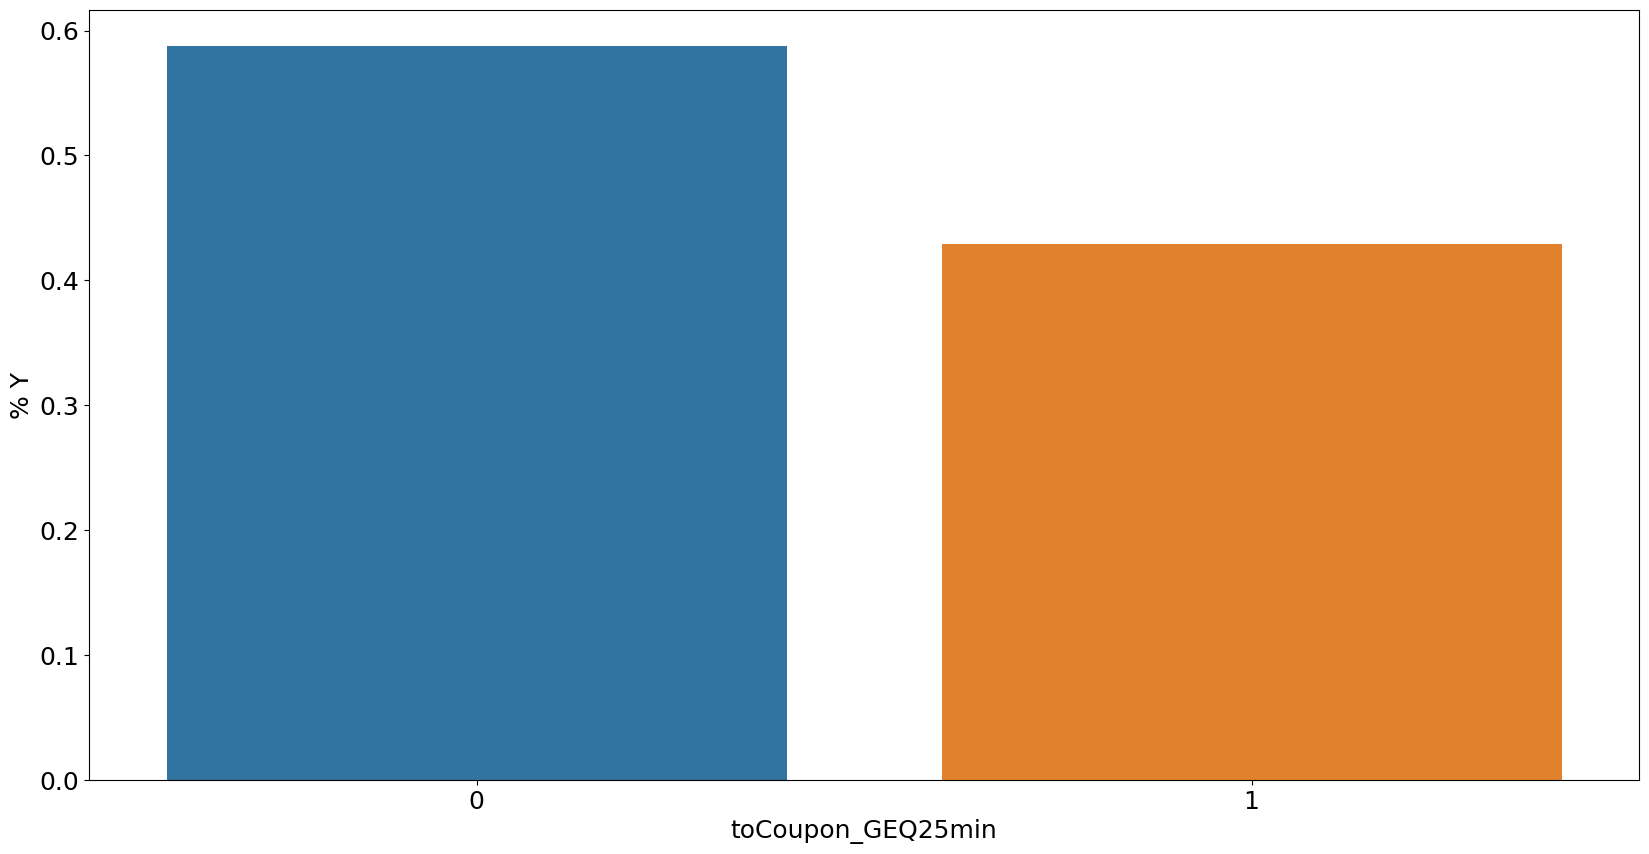

<Figure size 640x480 with 0 Axes>

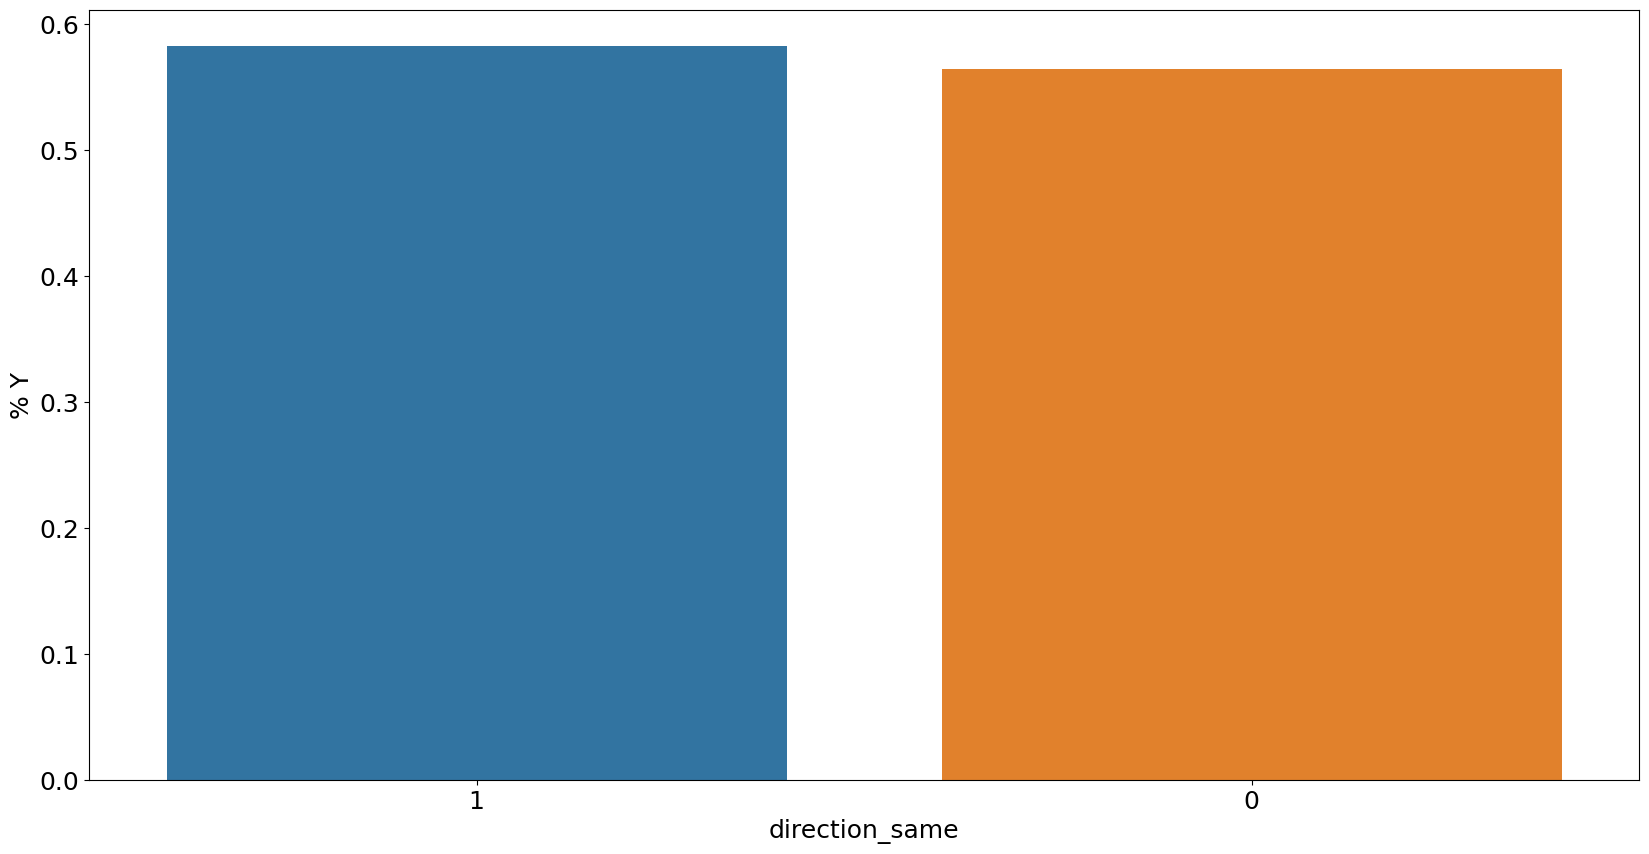

<Figure size 640x480 with 0 Axes>

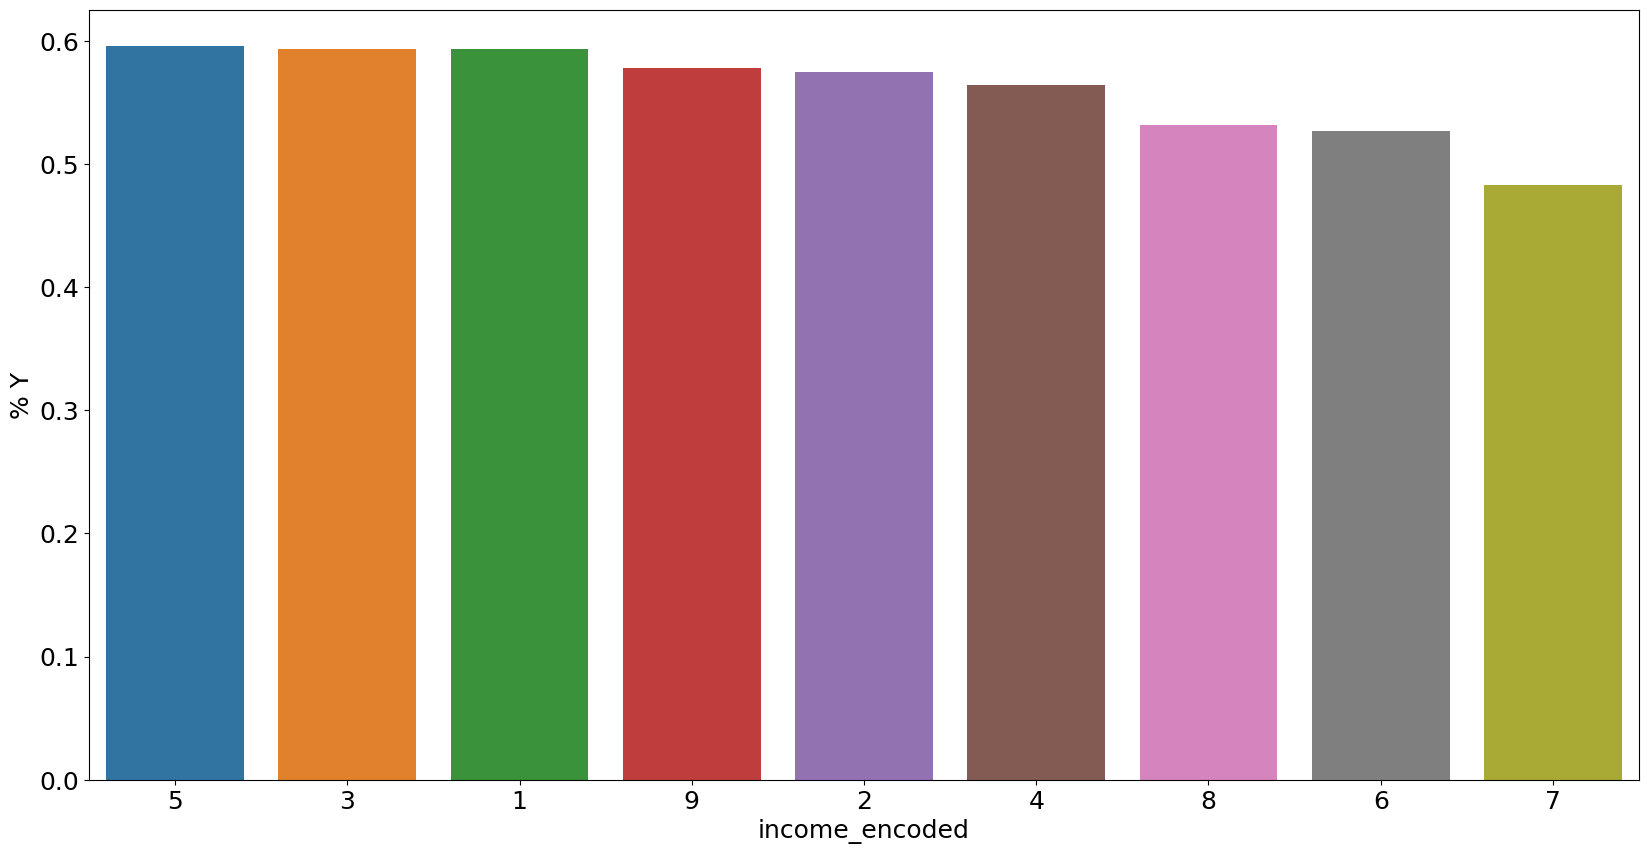

<Figure size 640x480 with 0 Axes>

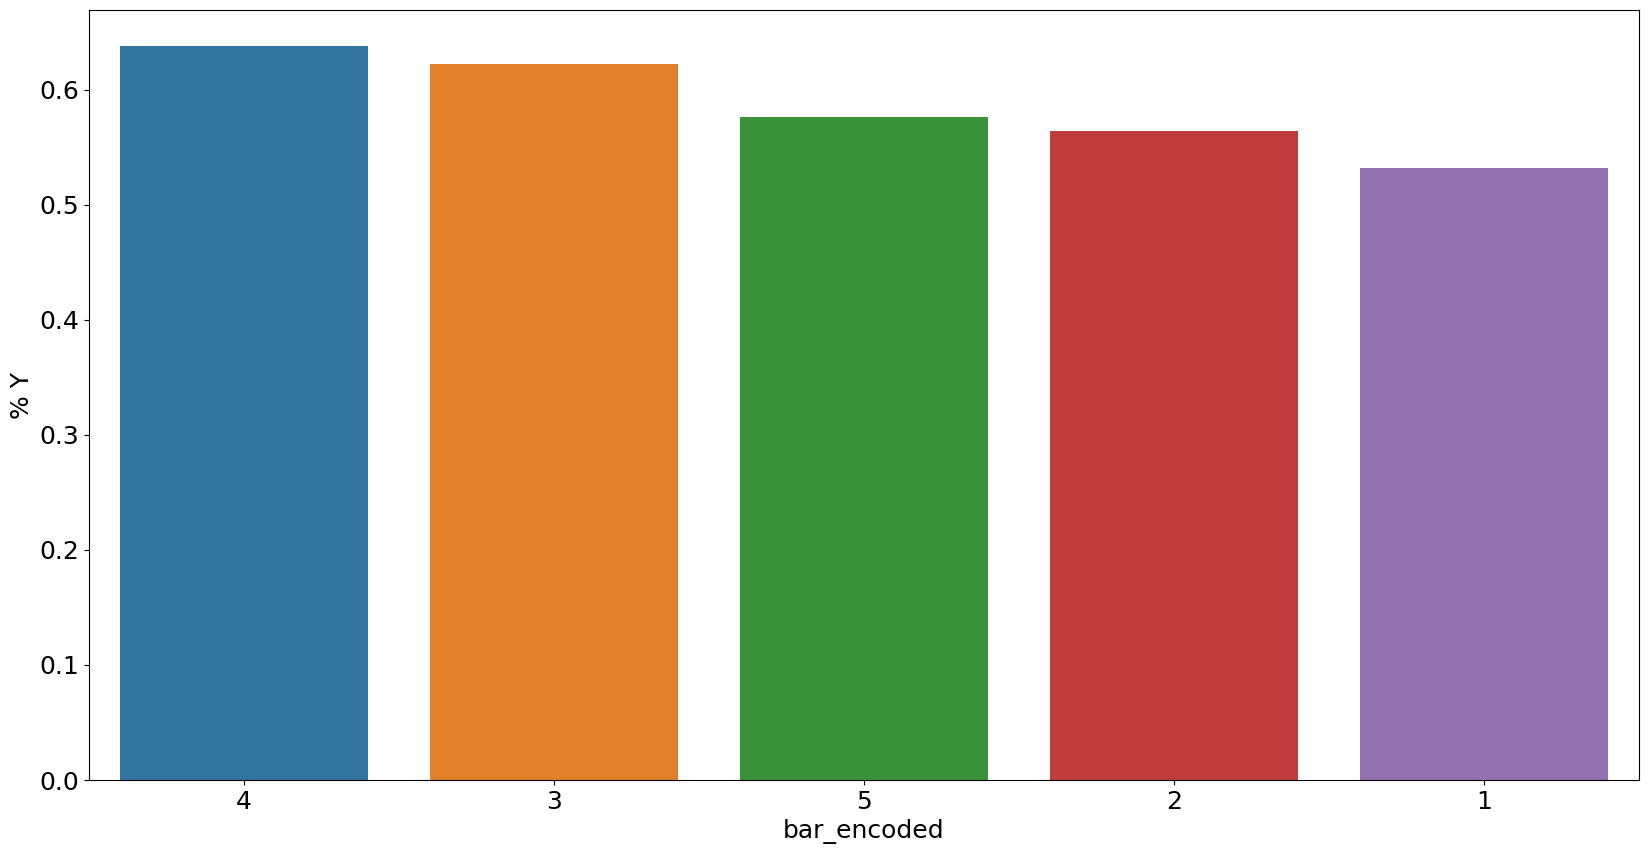

<Figure size 640x480 with 0 Axes>

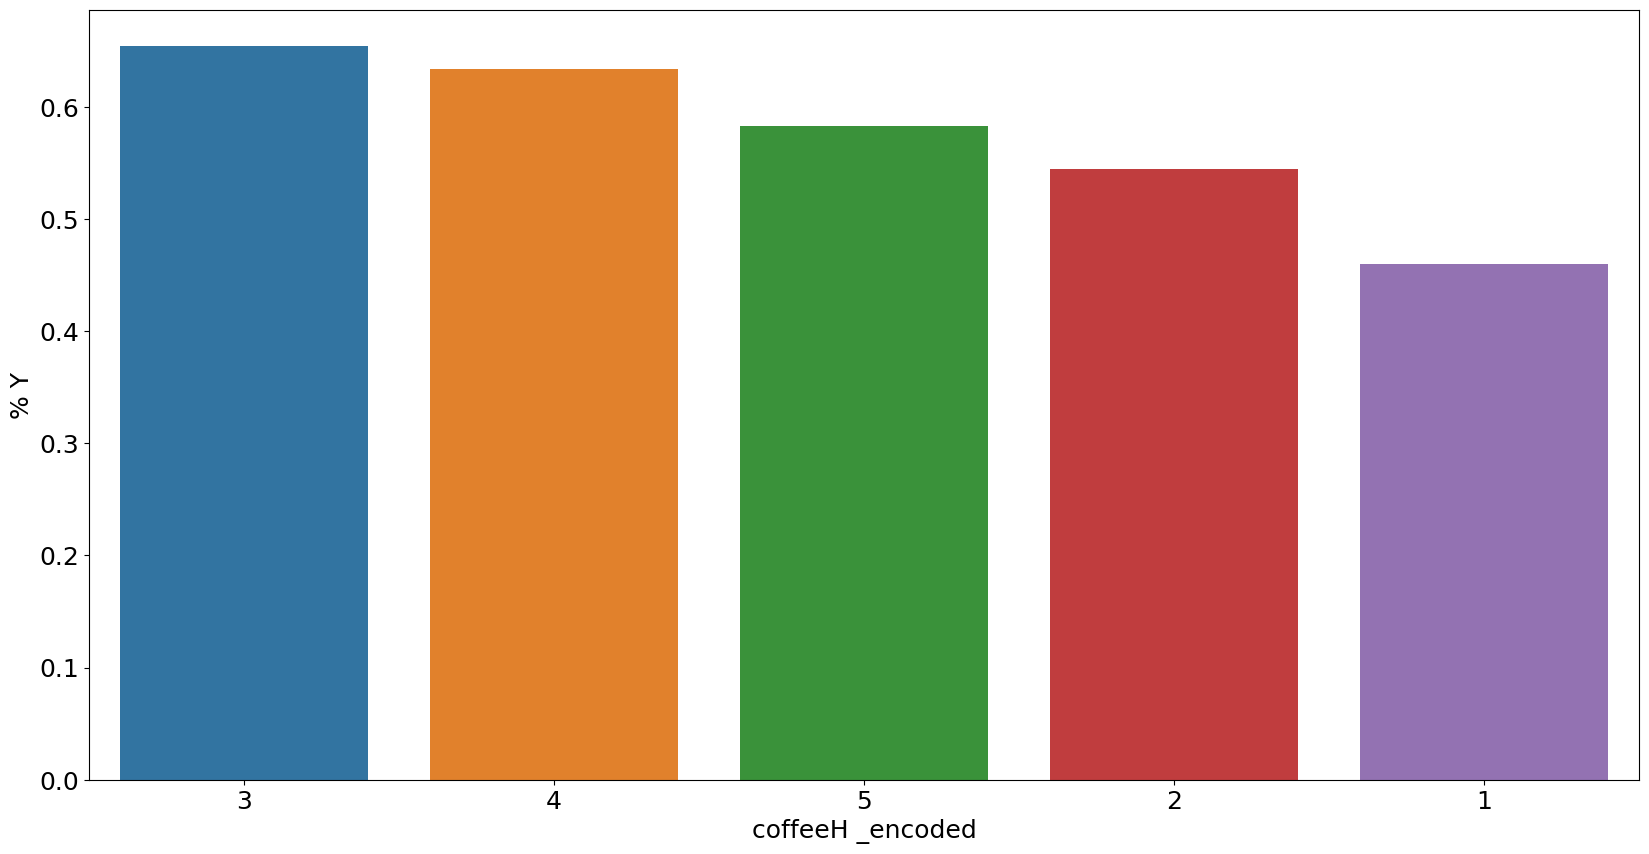

<Figure size 640x480 with 0 Axes>

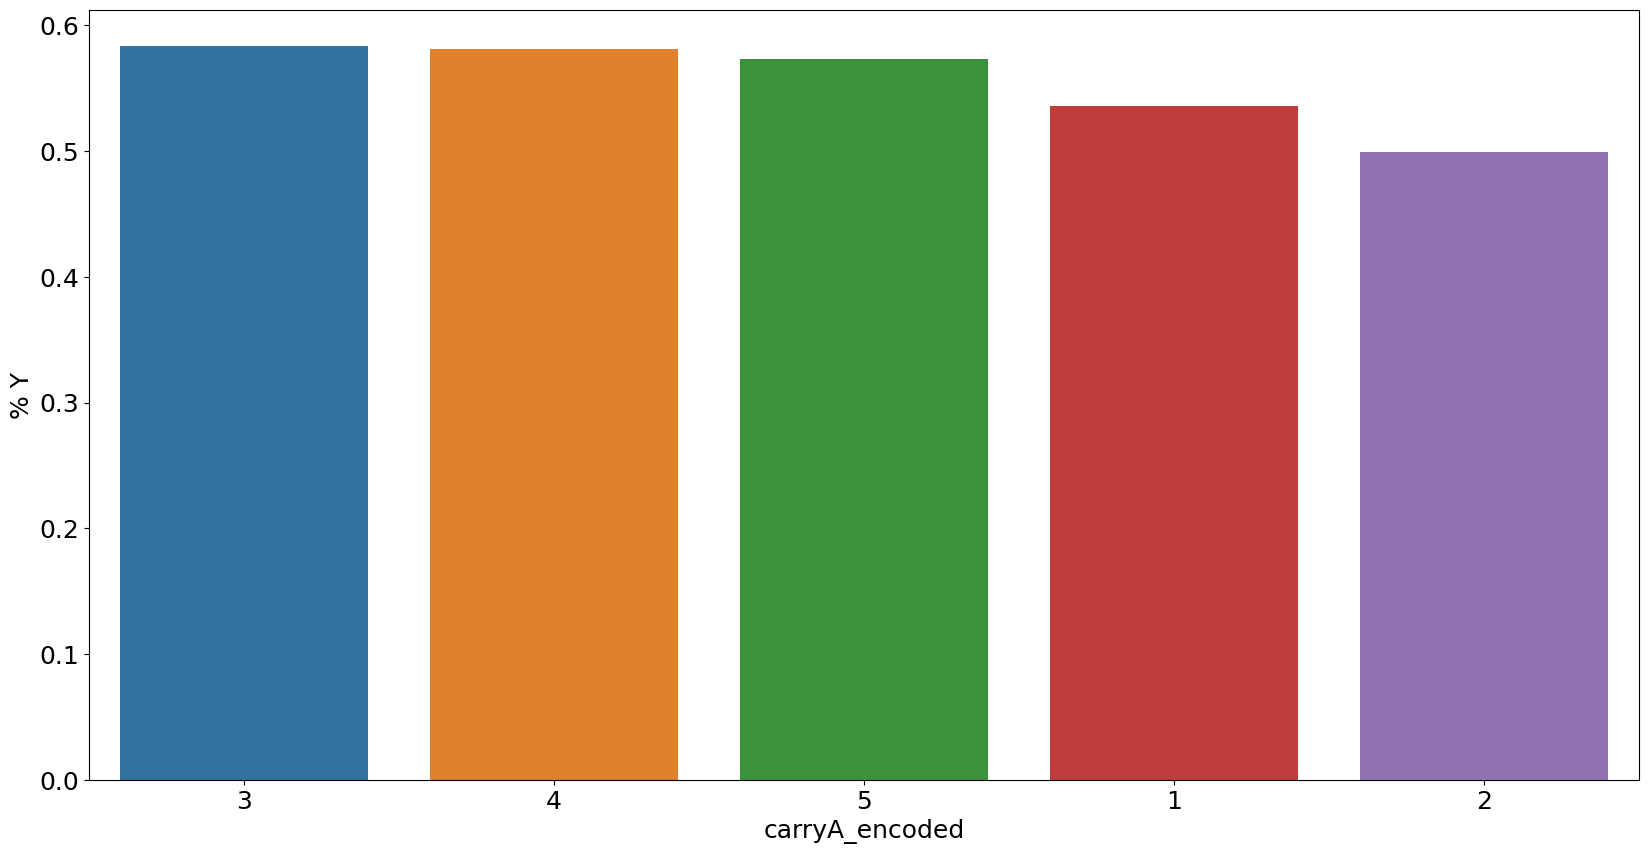

<Figure size 640x480 with 0 Axes>

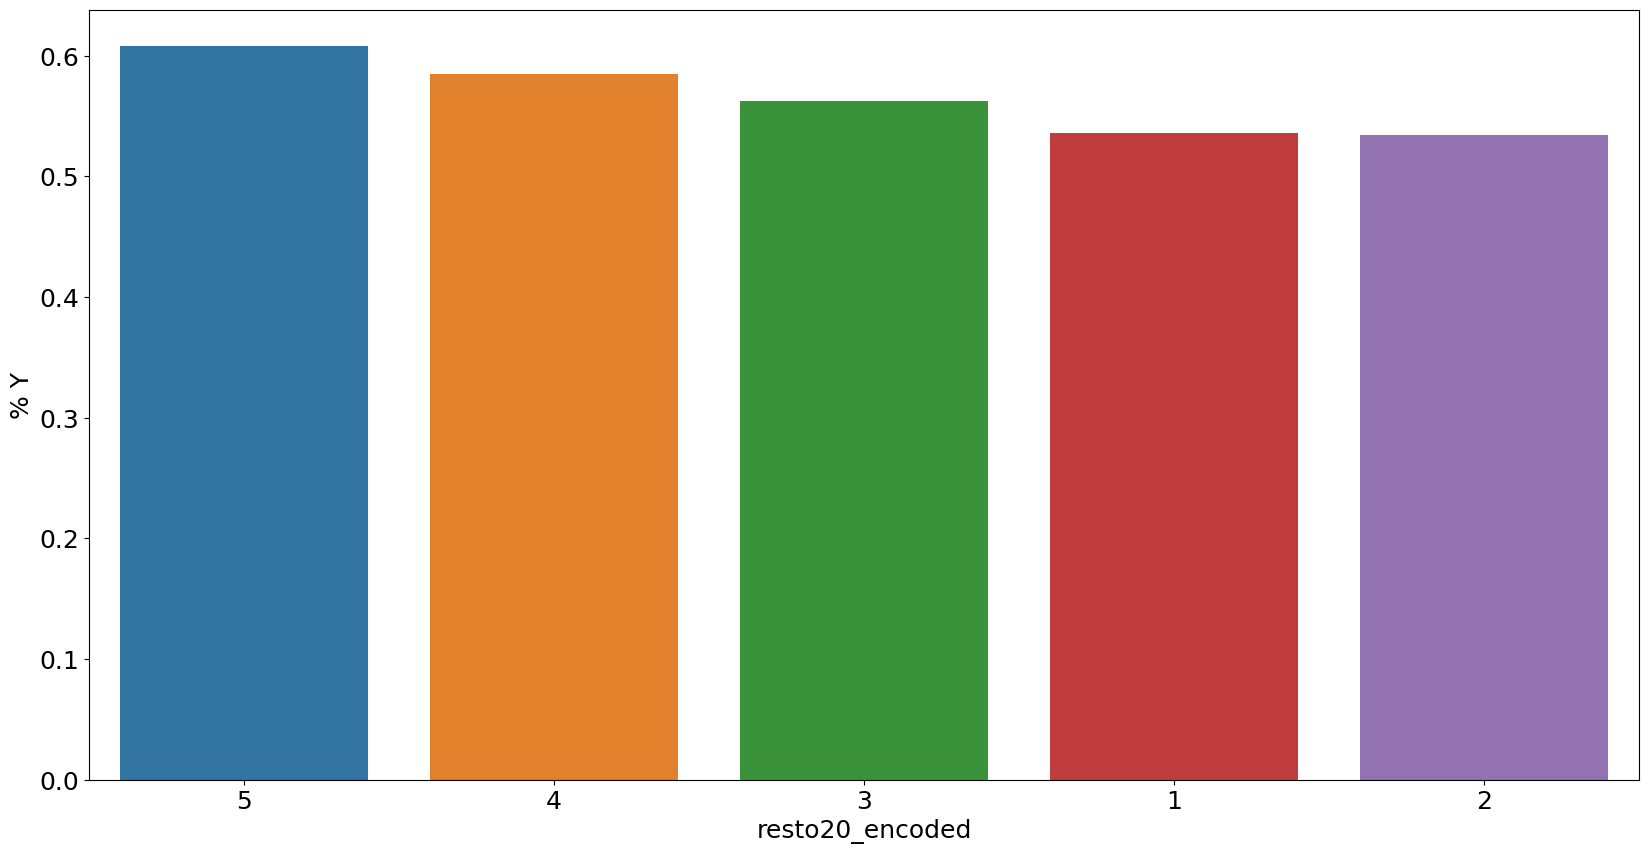

<Figure size 640x480 with 0 Axes>

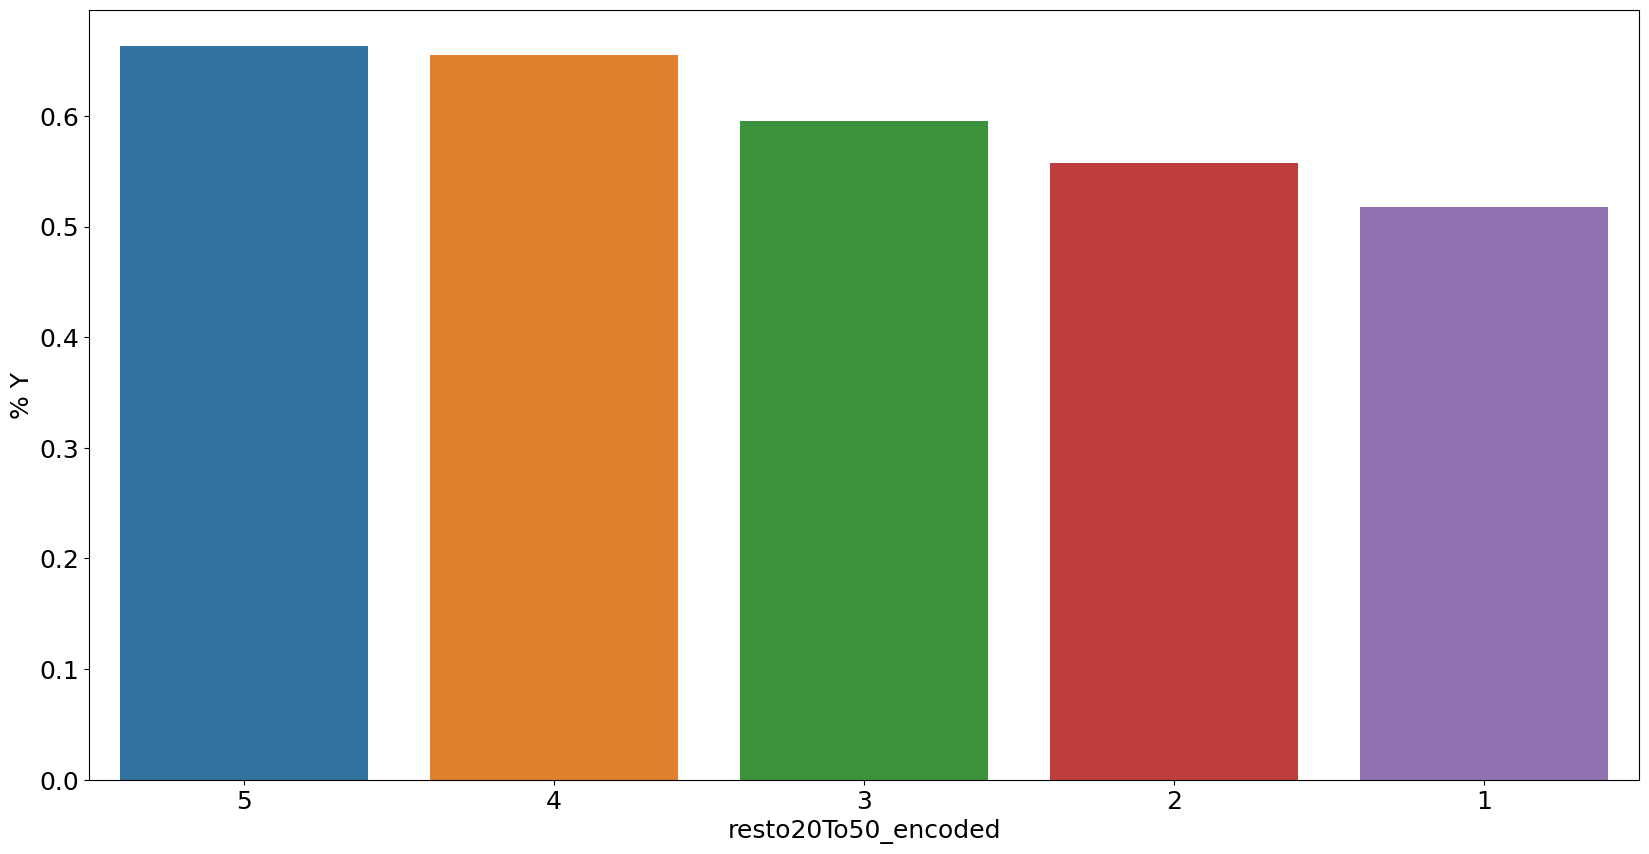

<Figure size 640x480 with 0 Axes>

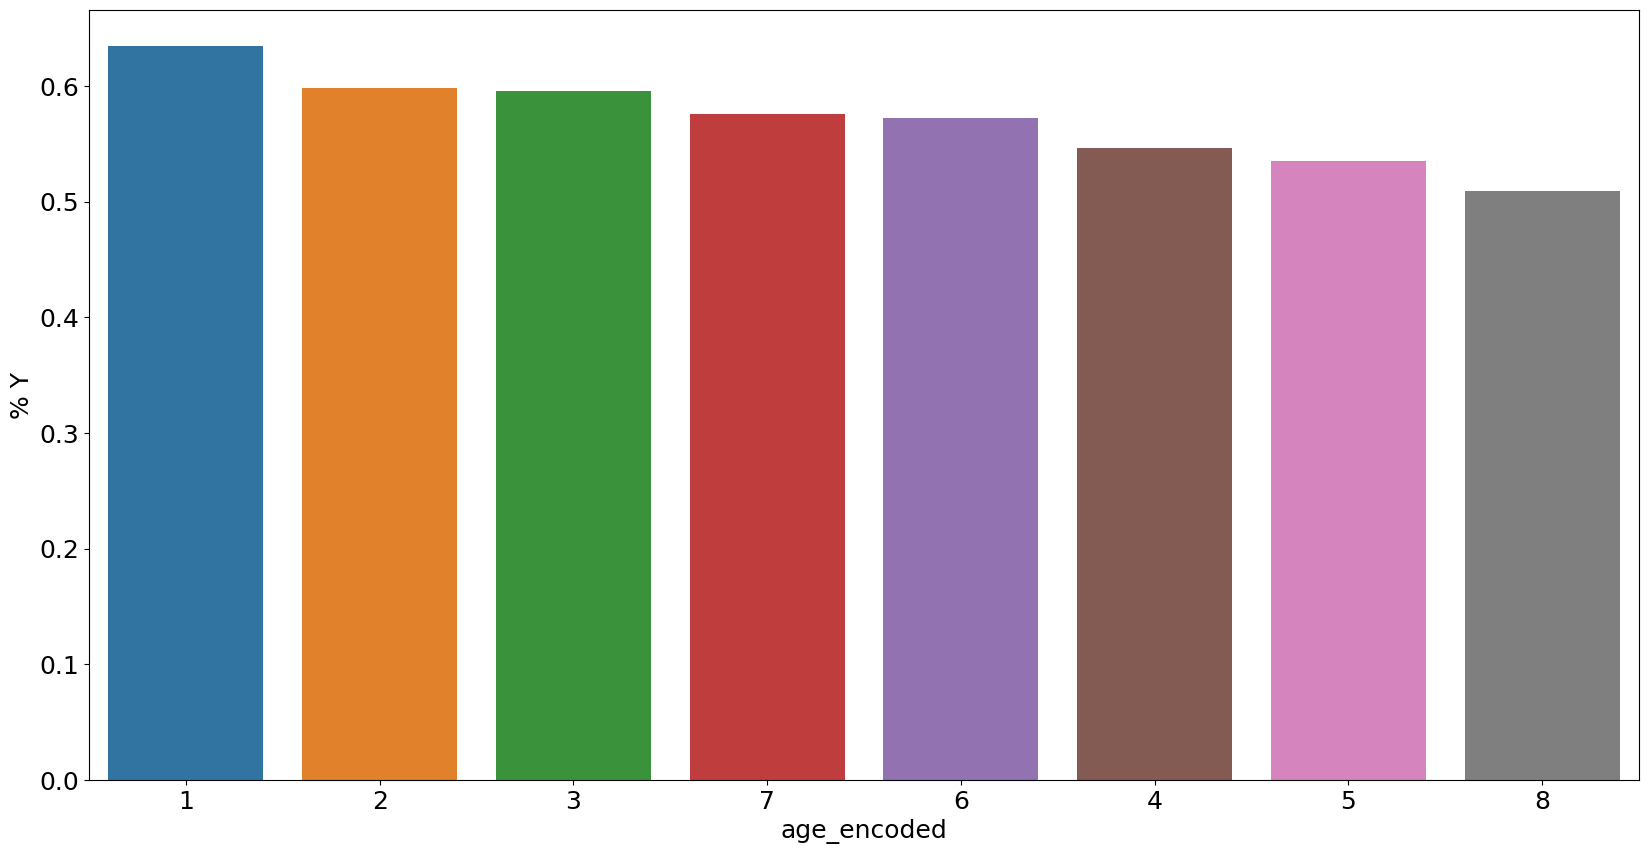

<Figure size 640x480 with 0 Axes>

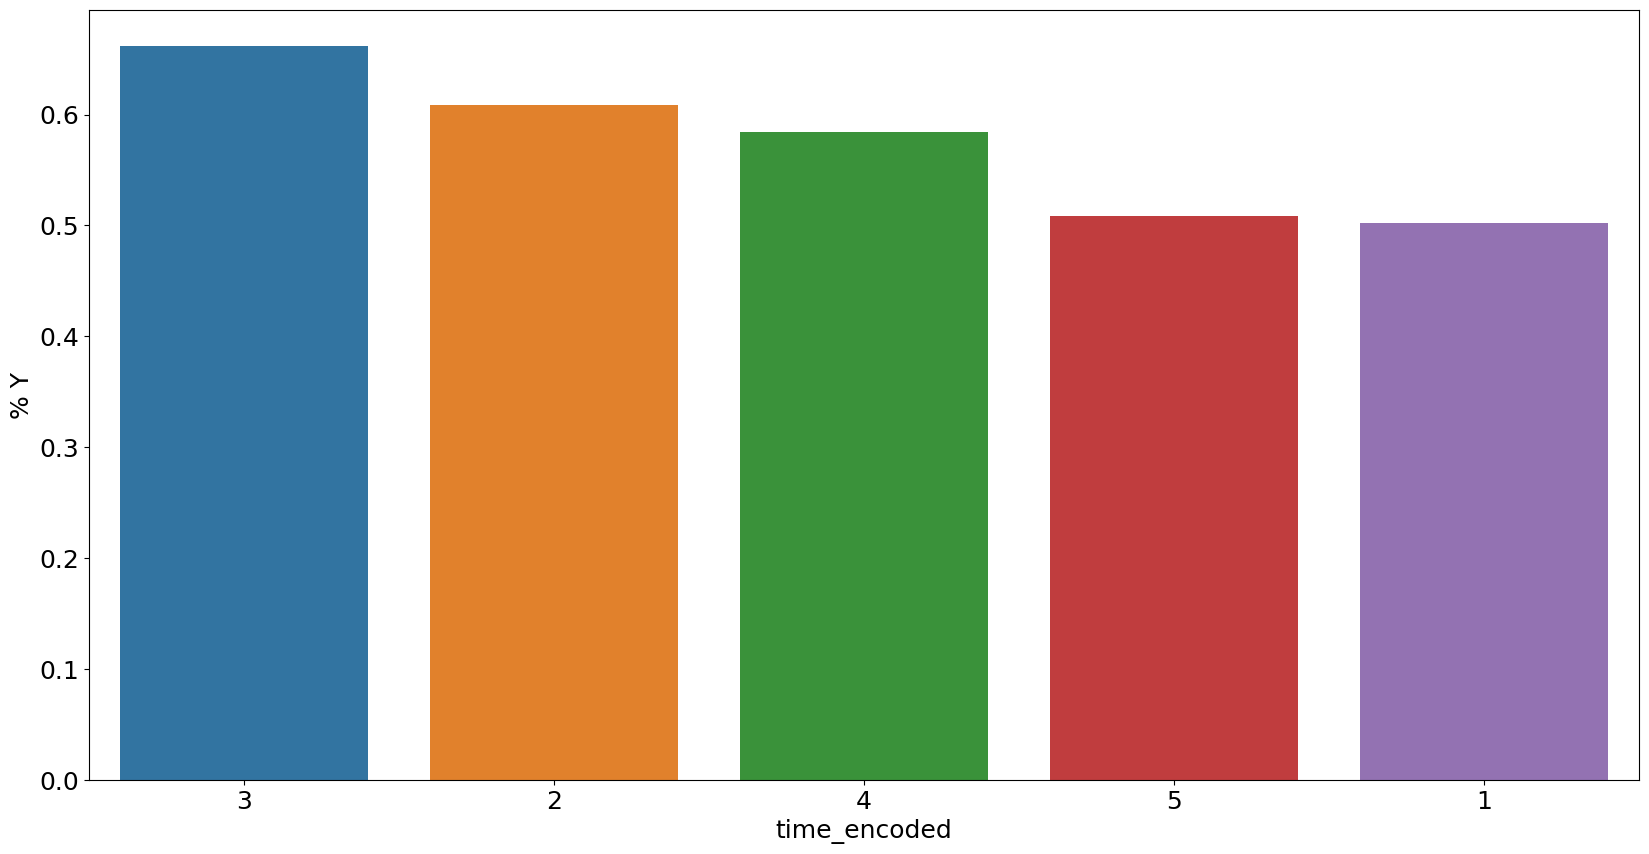

<Figure size 640x480 with 0 Axes>

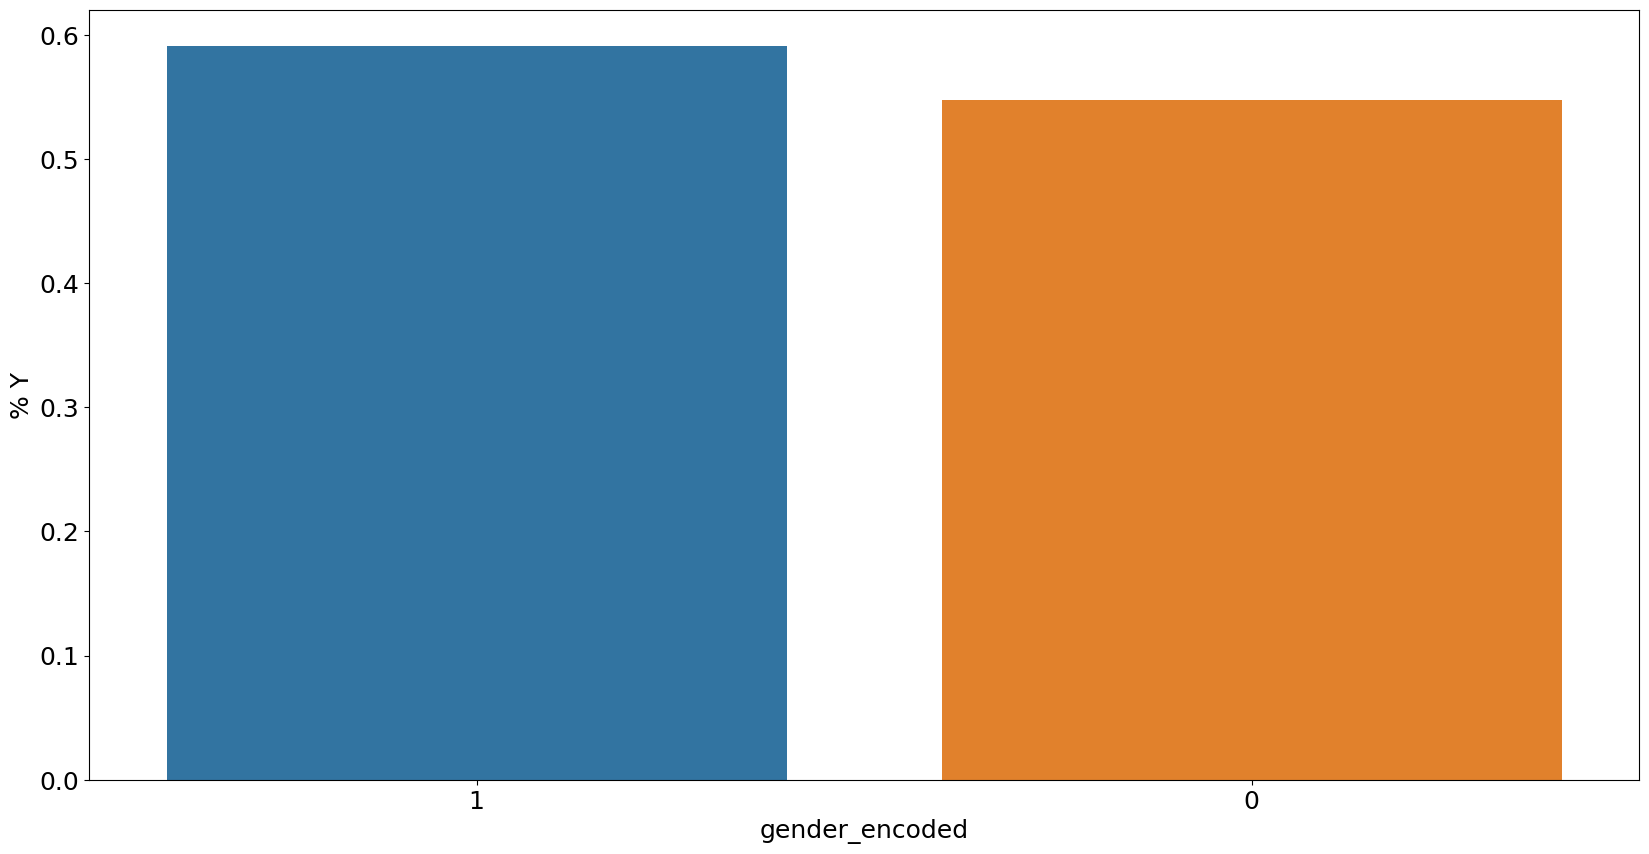

<Figure size 640x480 with 0 Axes>

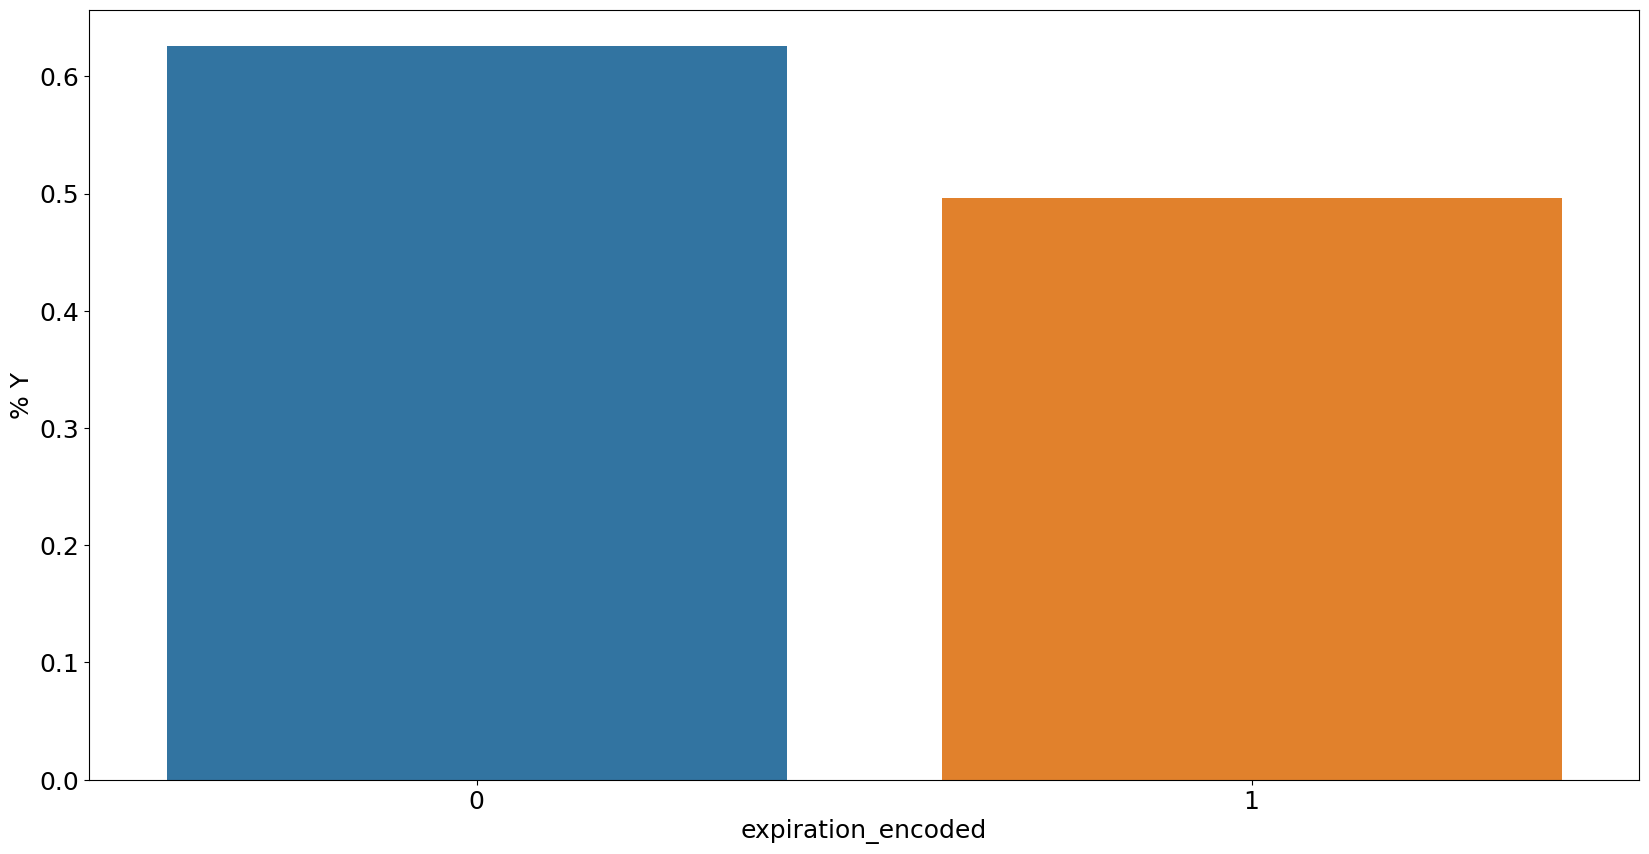

<Figure size 640x480 with 0 Axes>

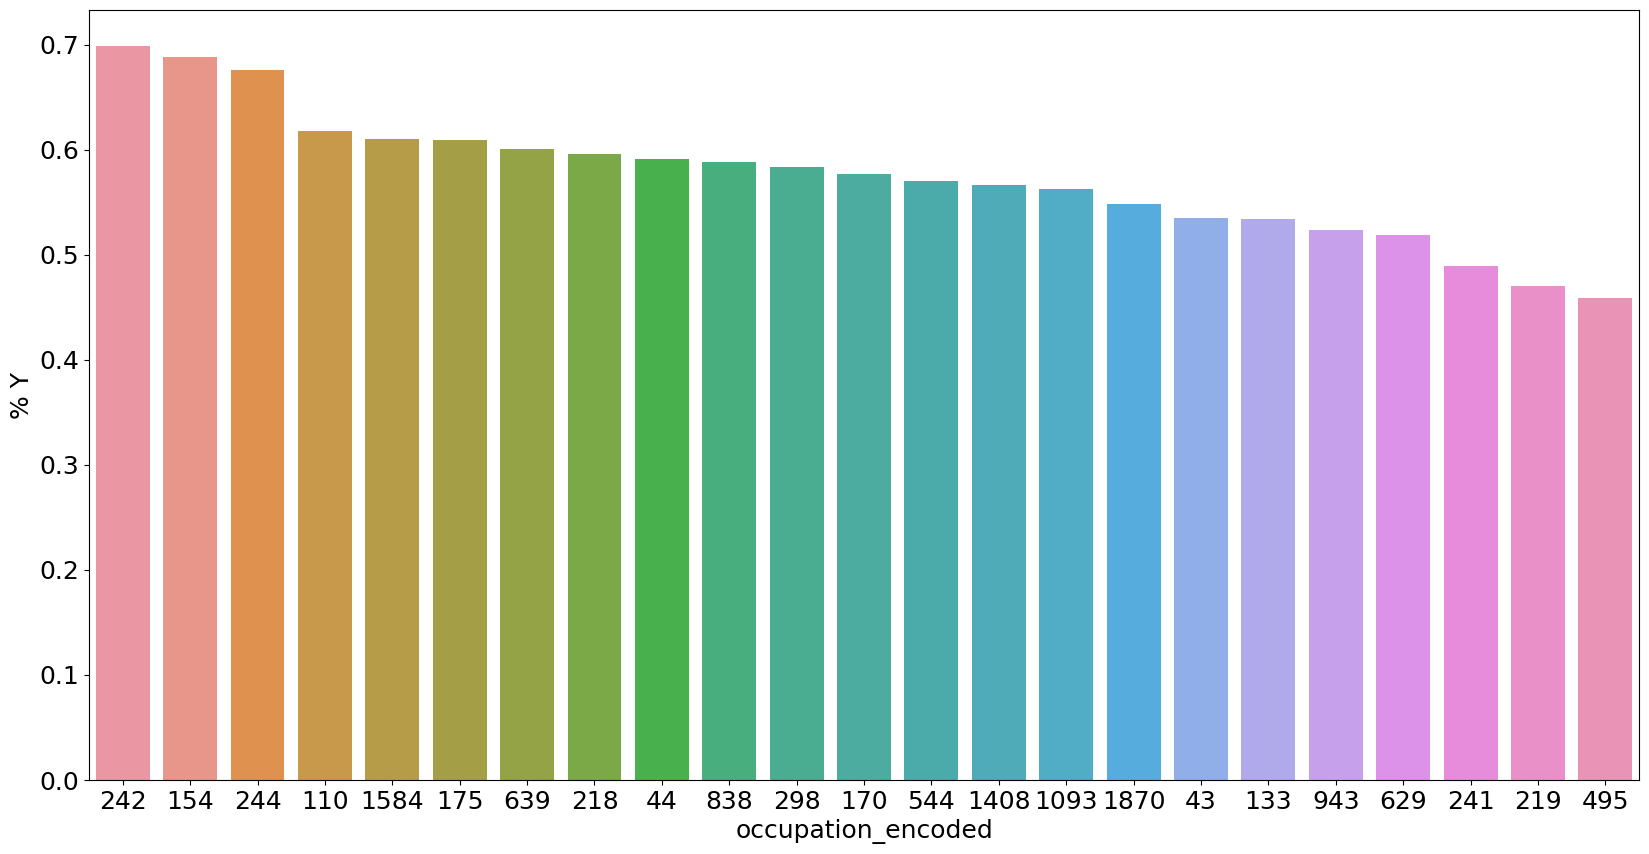

<Figure size 640x480 with 0 Axes>

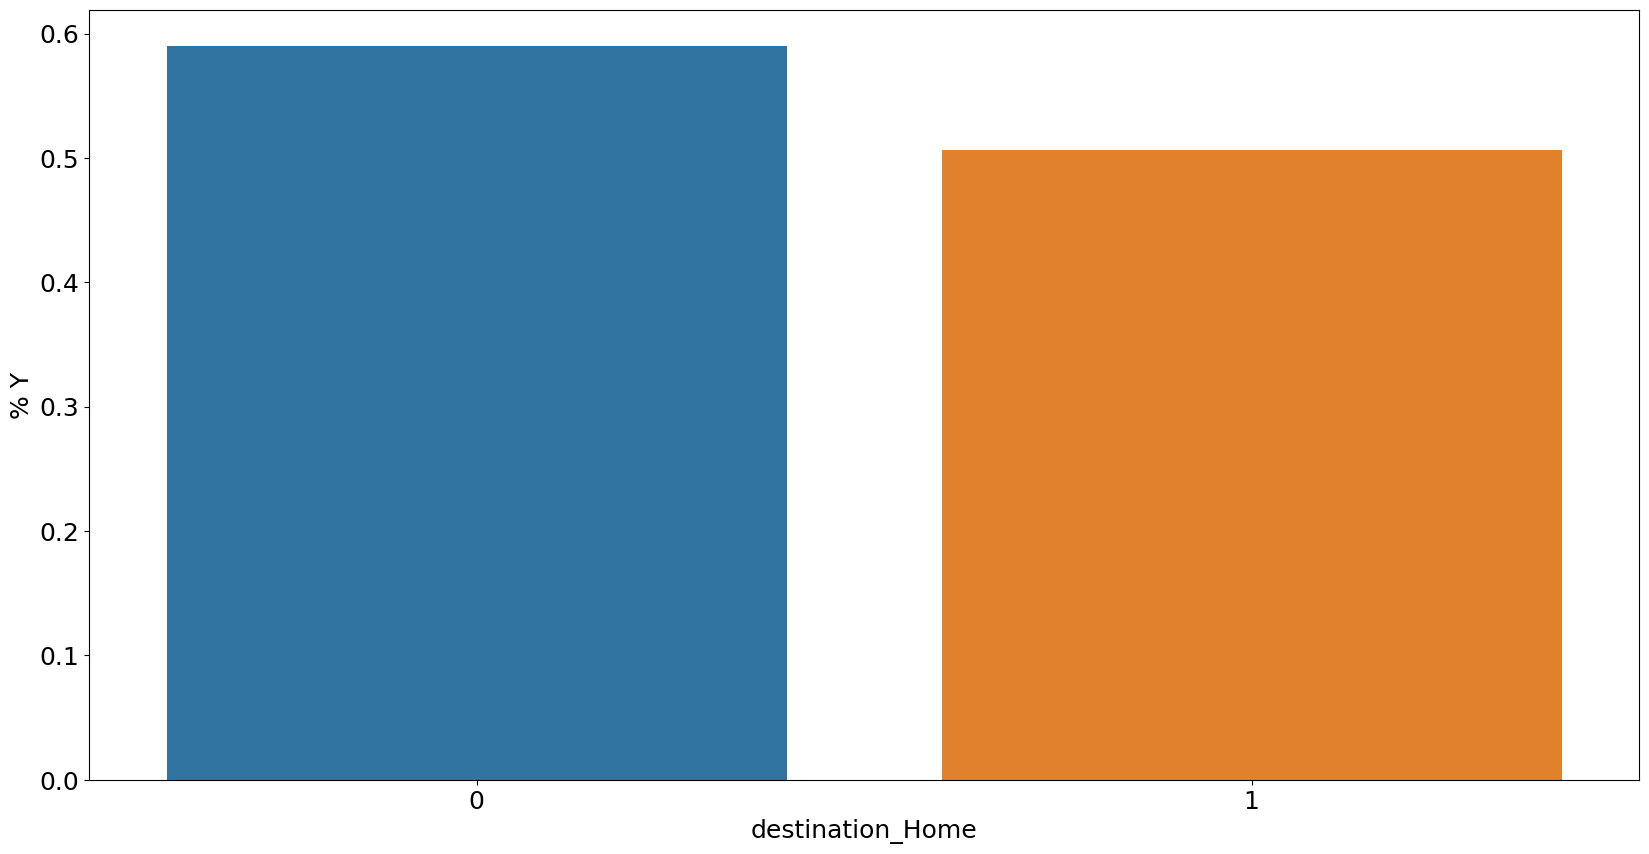

<Figure size 640x480 with 0 Axes>

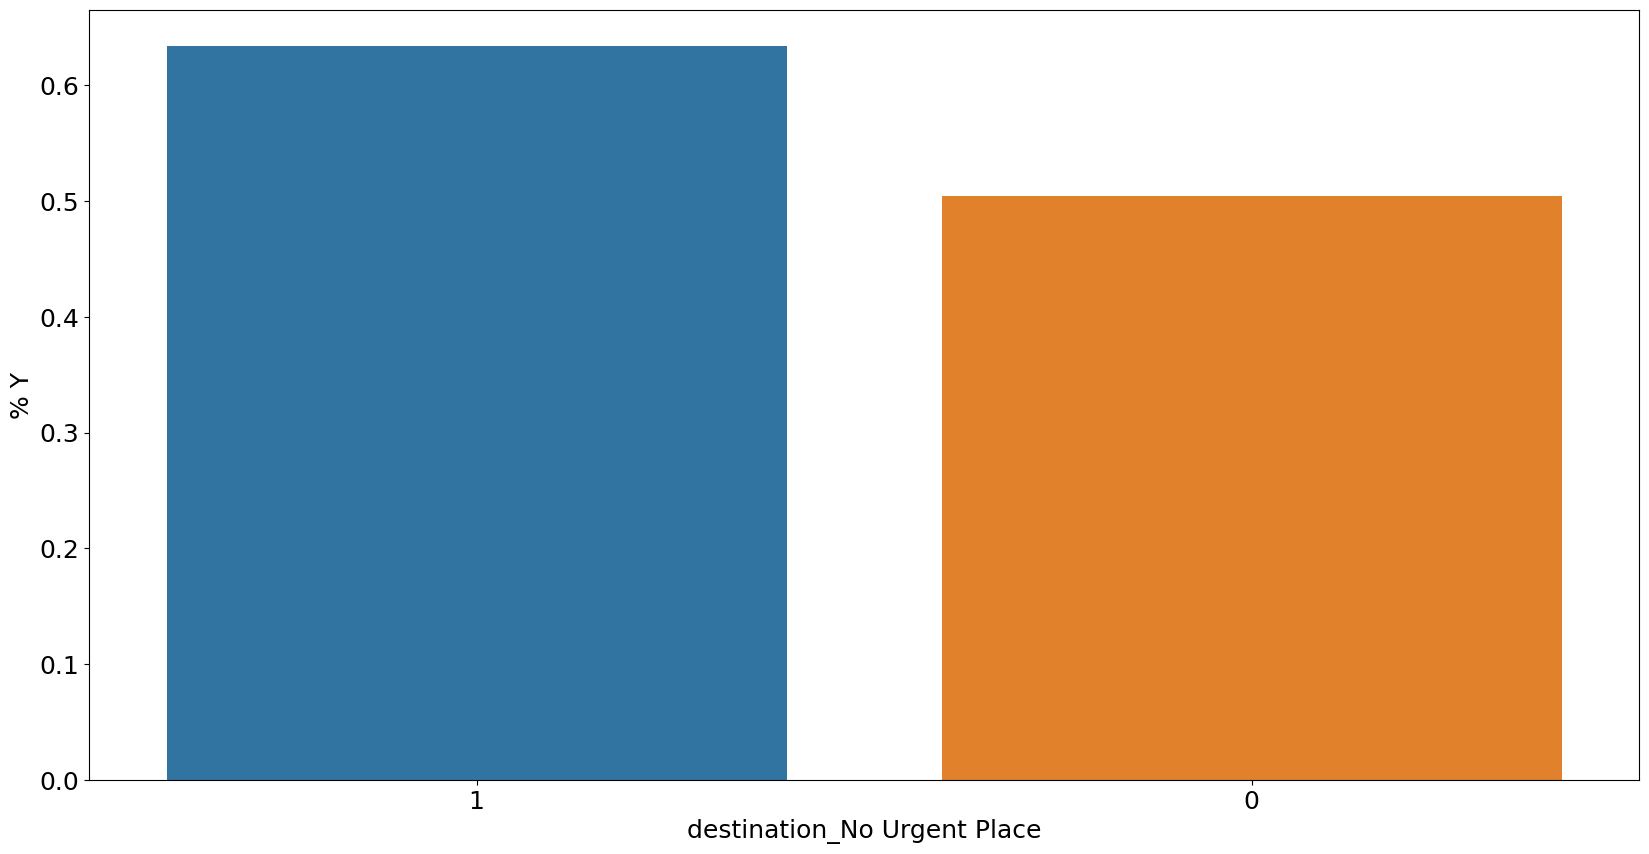

<Figure size 640x480 with 0 Axes>

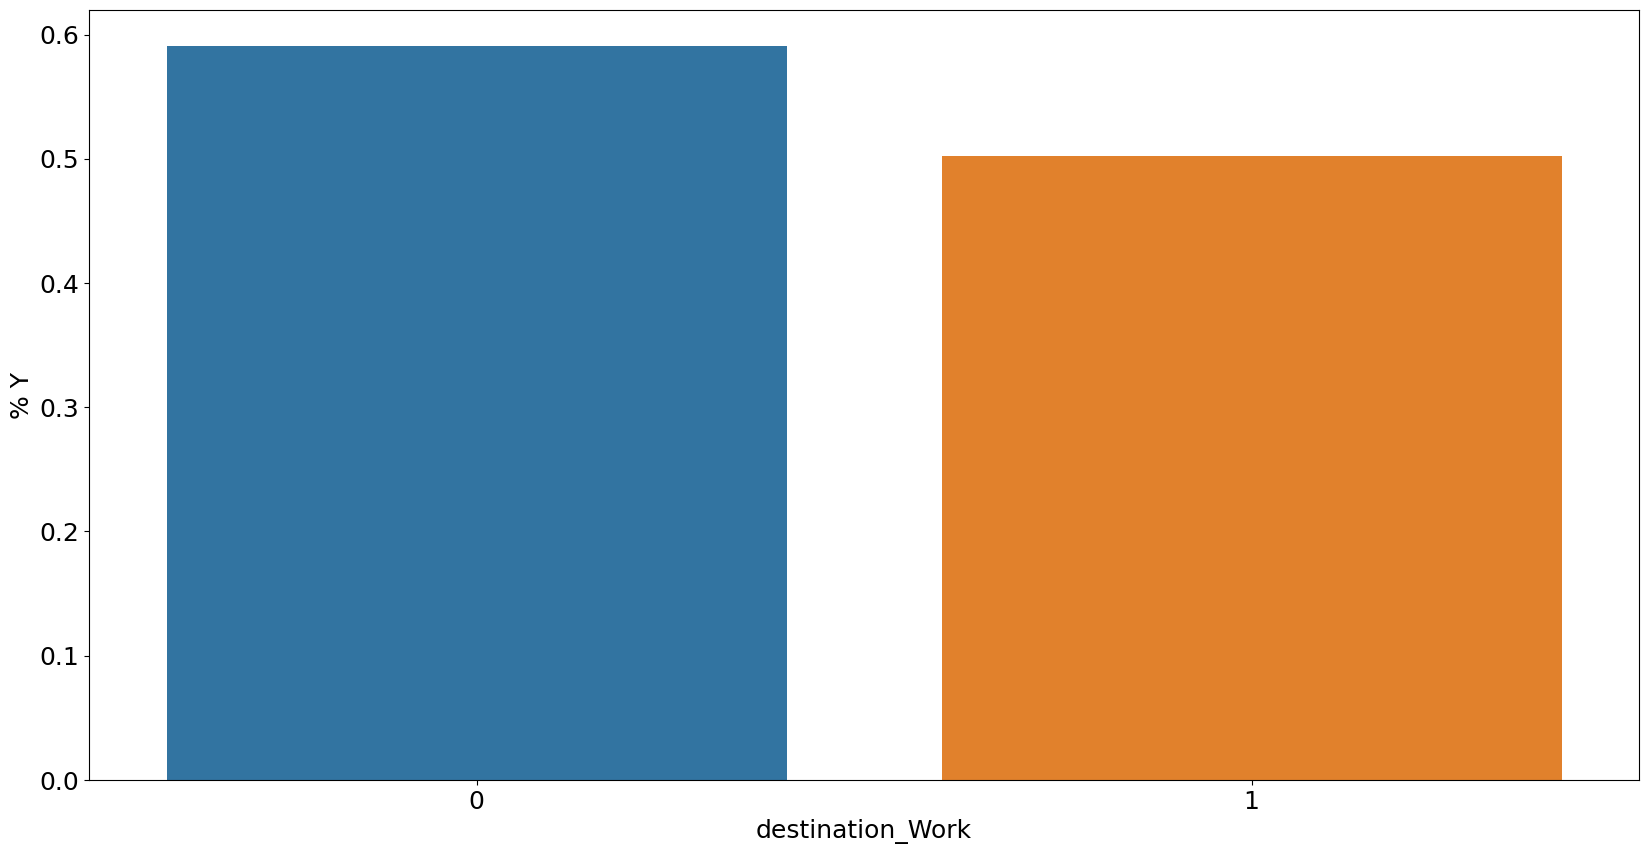

<Figure size 640x480 with 0 Axes>

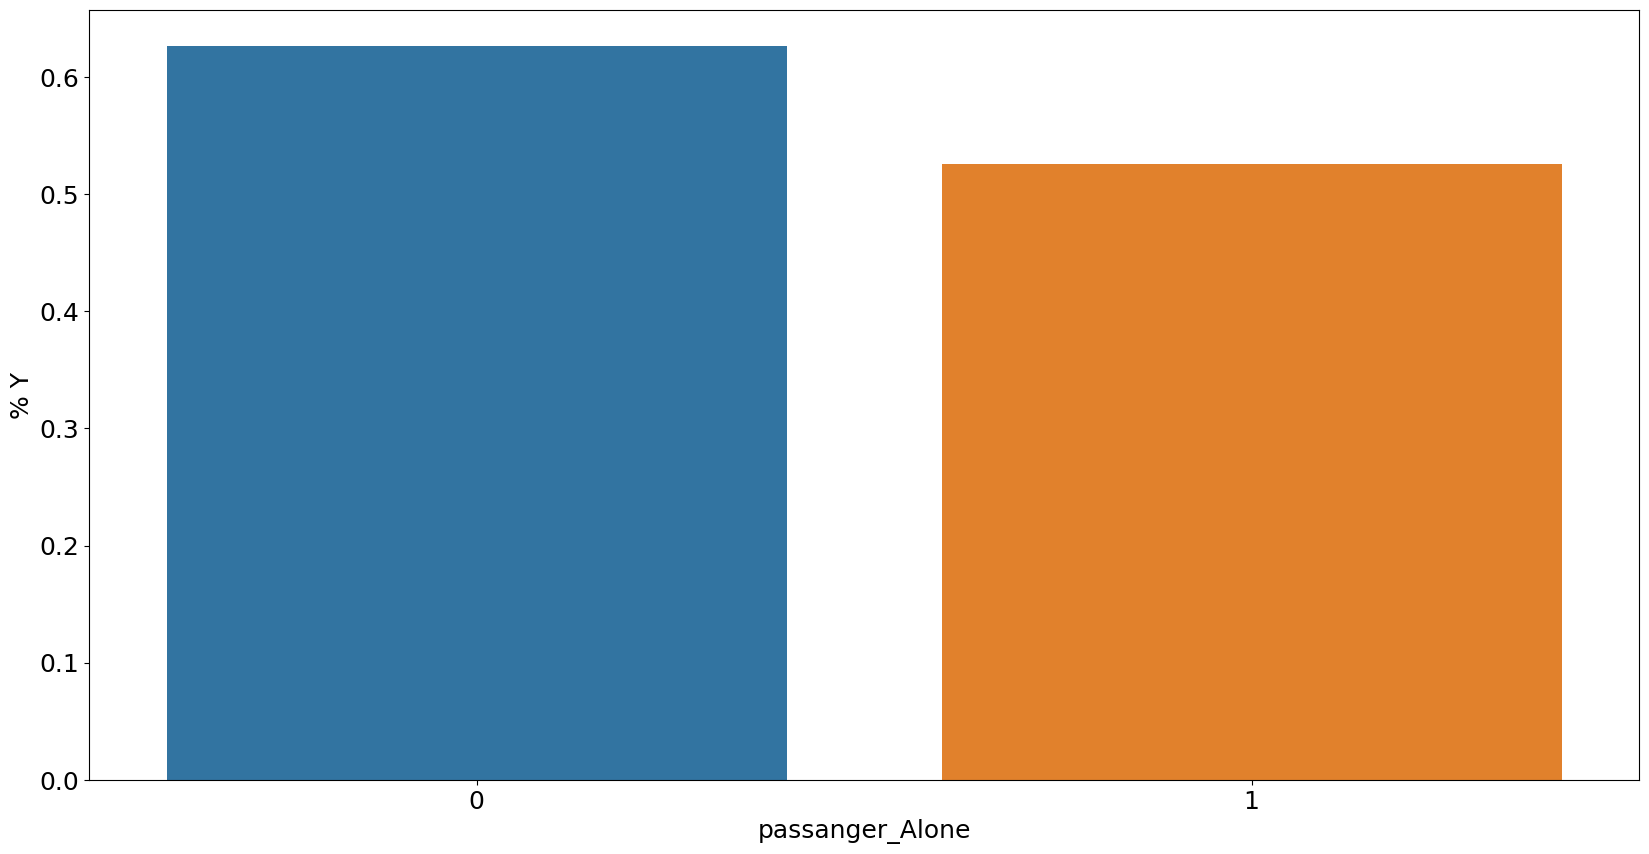

<Figure size 640x480 with 0 Axes>

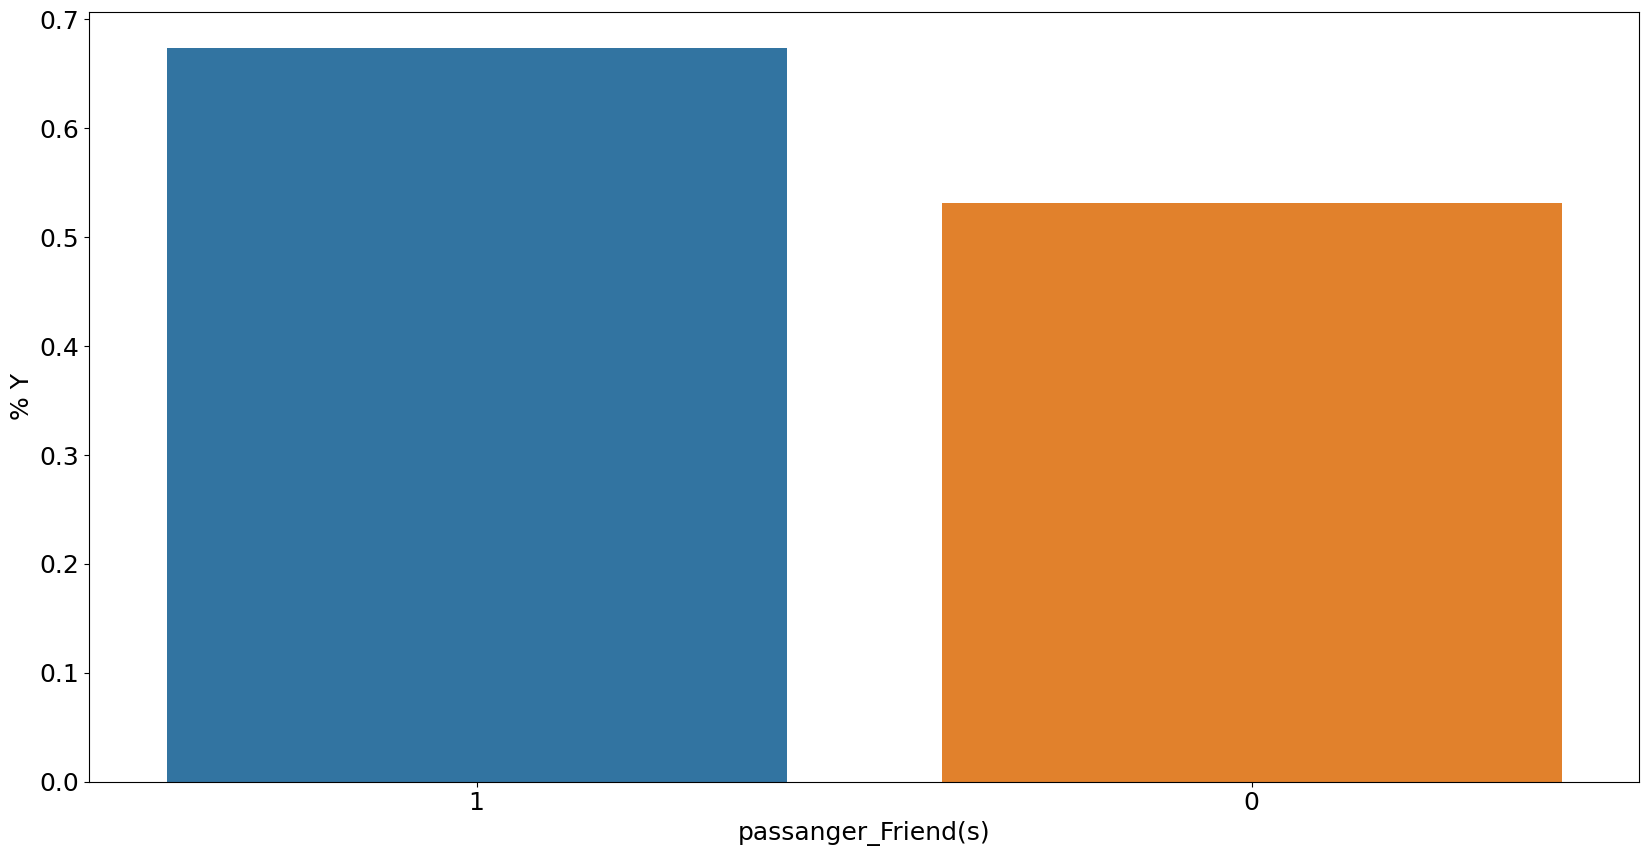

<Figure size 640x480 with 0 Axes>

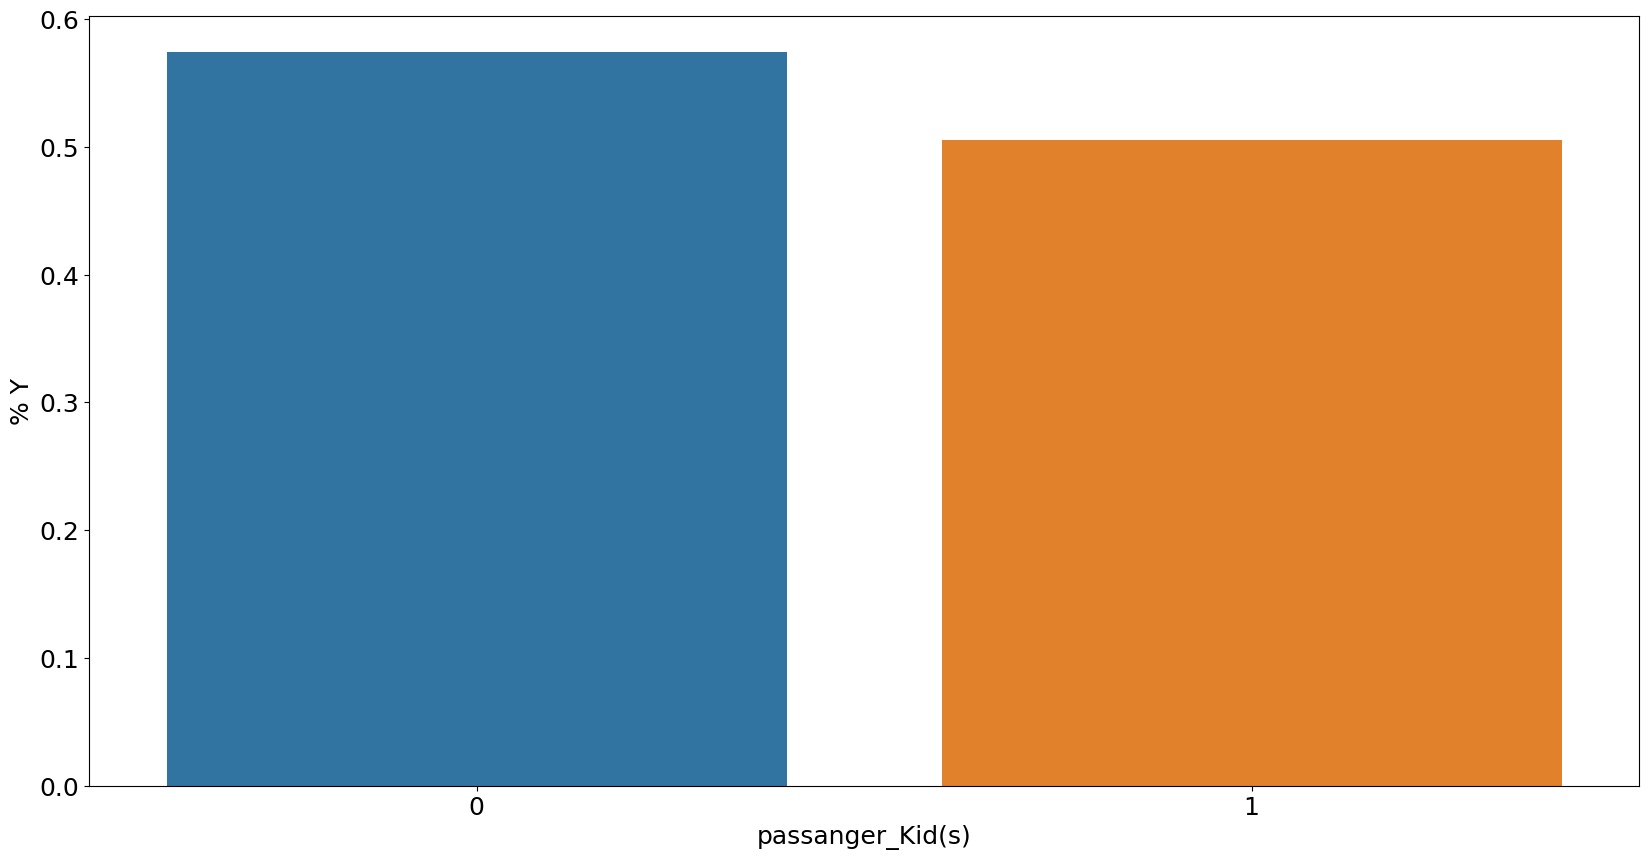

<Figure size 640x480 with 0 Axes>

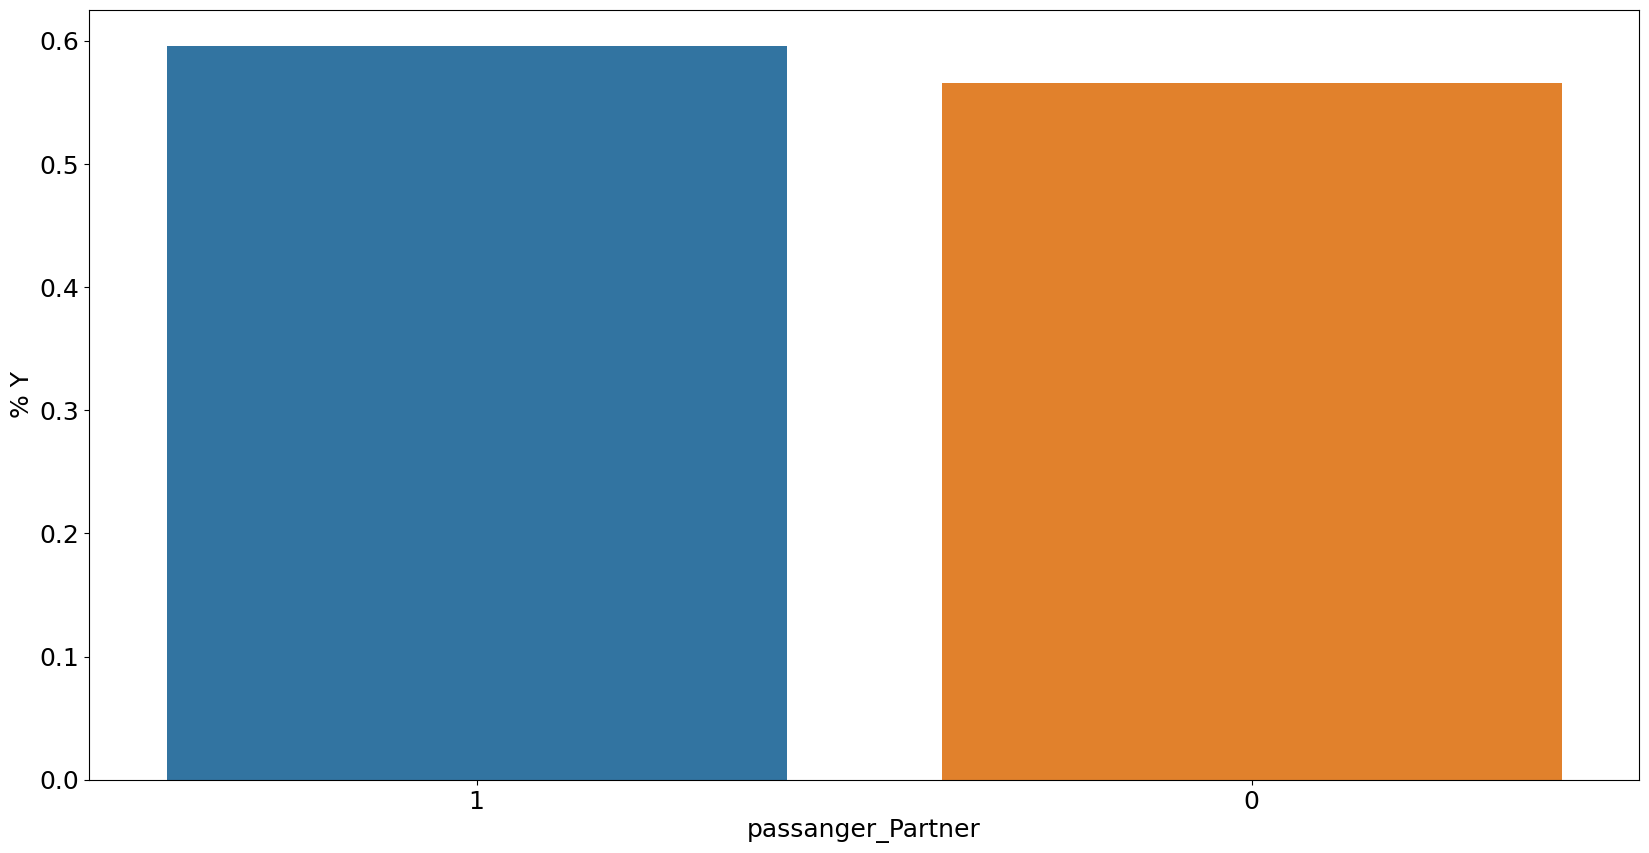

<Figure size 640x480 with 0 Axes>

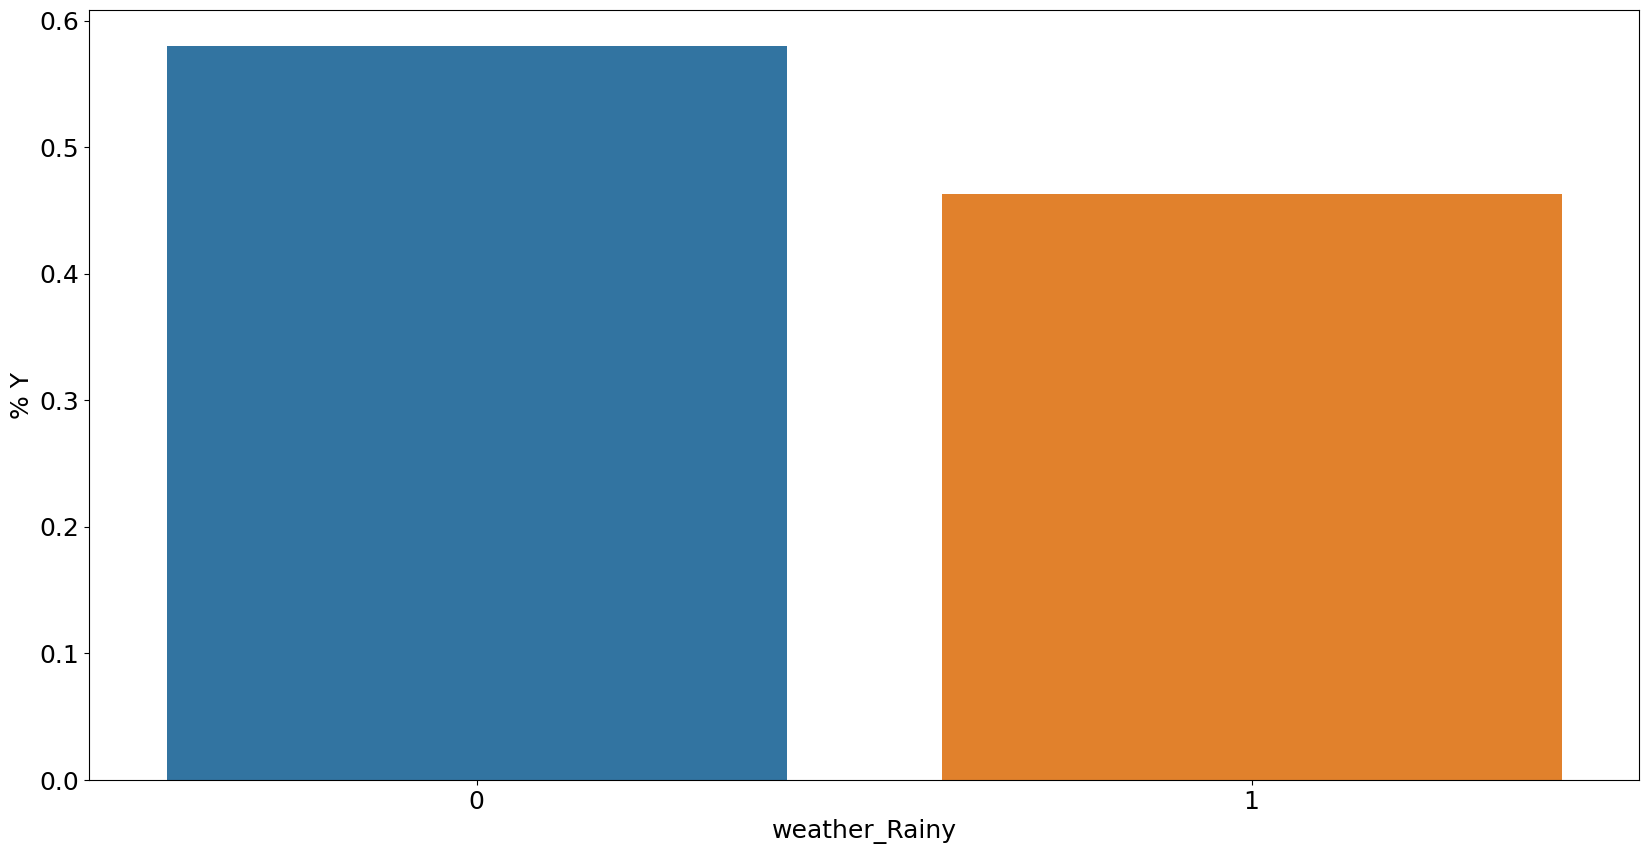

<Figure size 640x480 with 0 Axes>

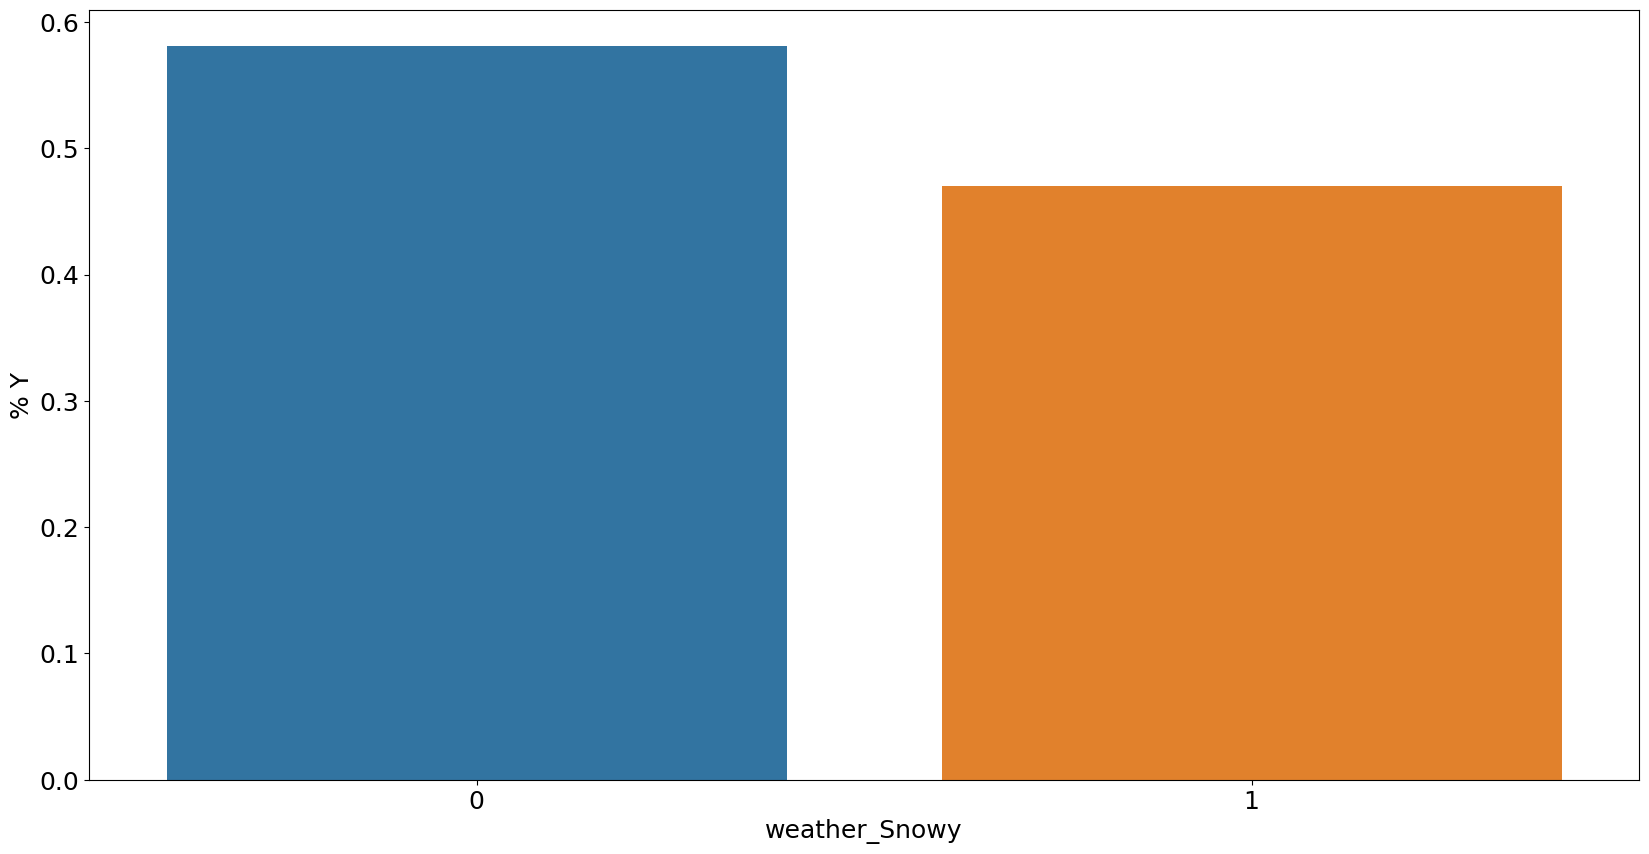

<Figure size 640x480 with 0 Axes>

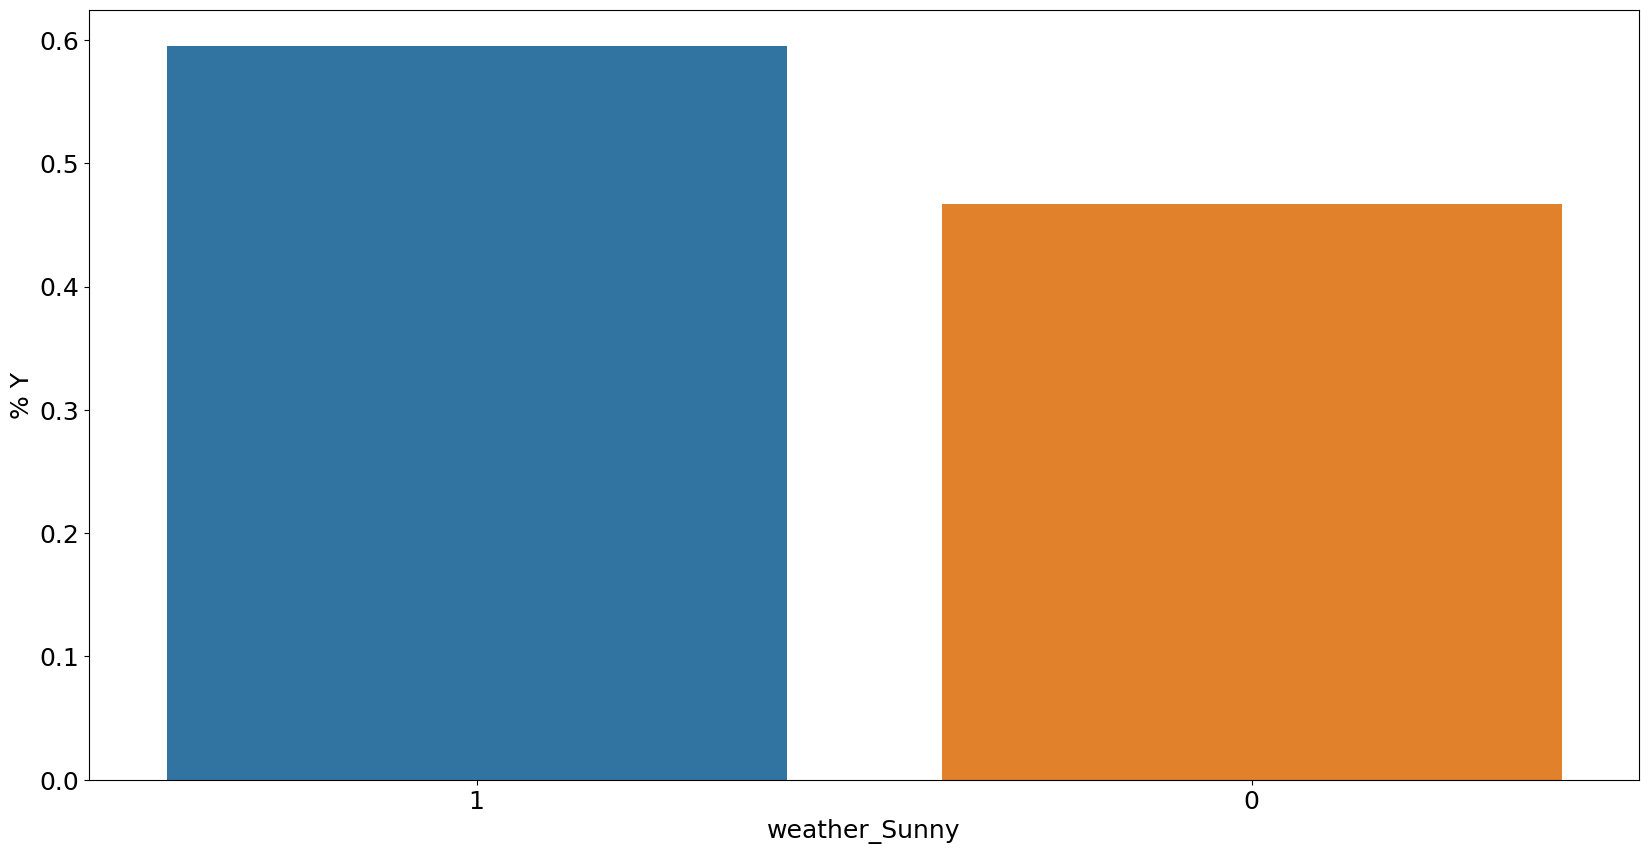

<Figure size 640x480 with 0 Axes>

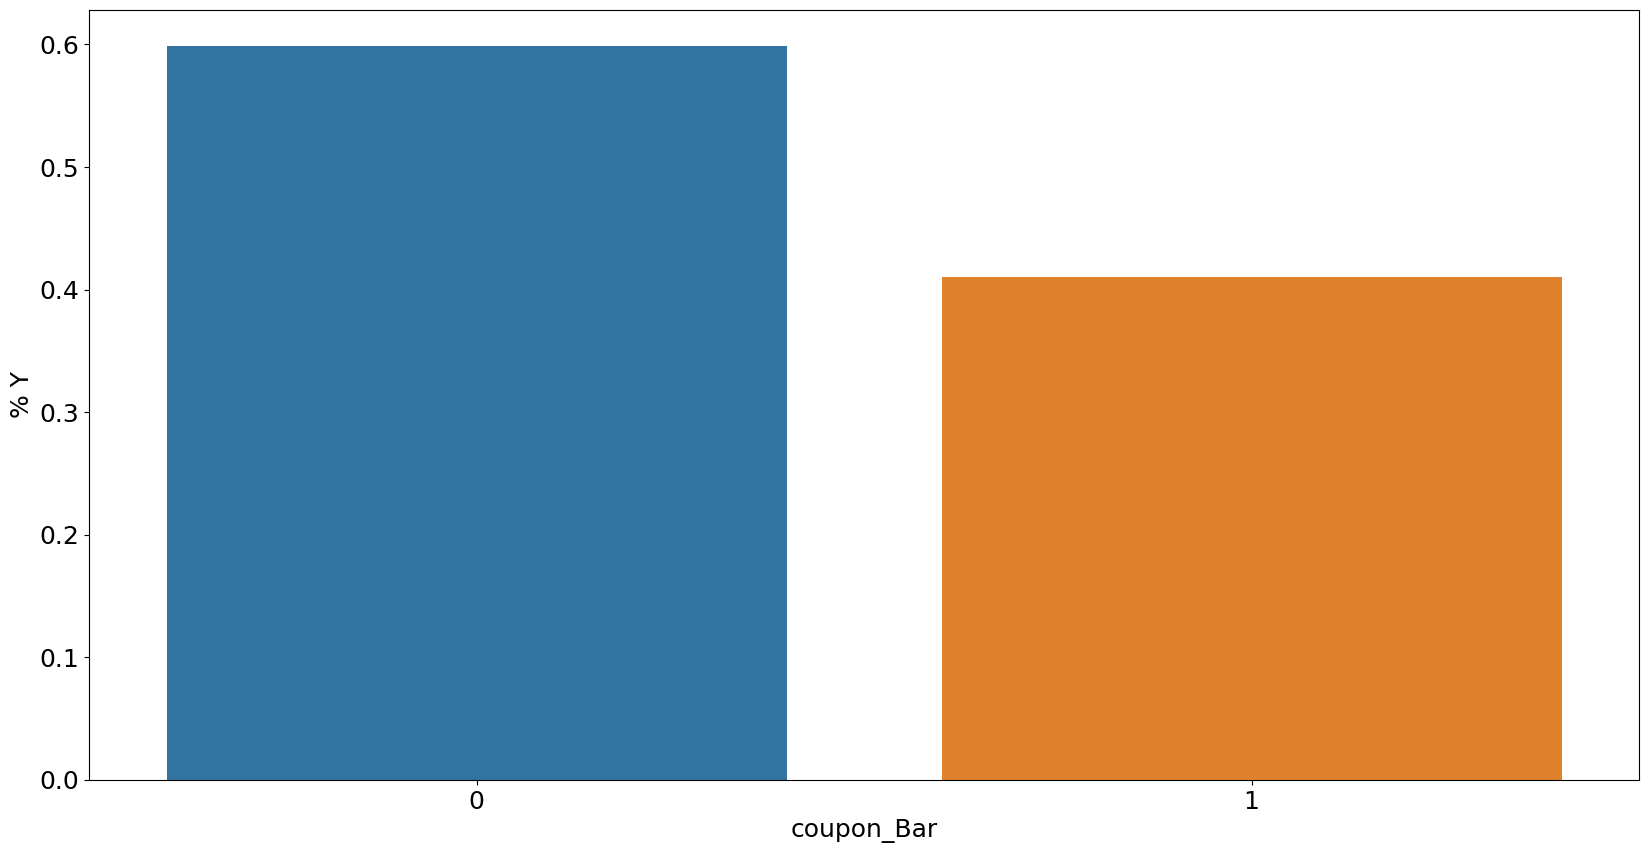

<Figure size 640x480 with 0 Axes>

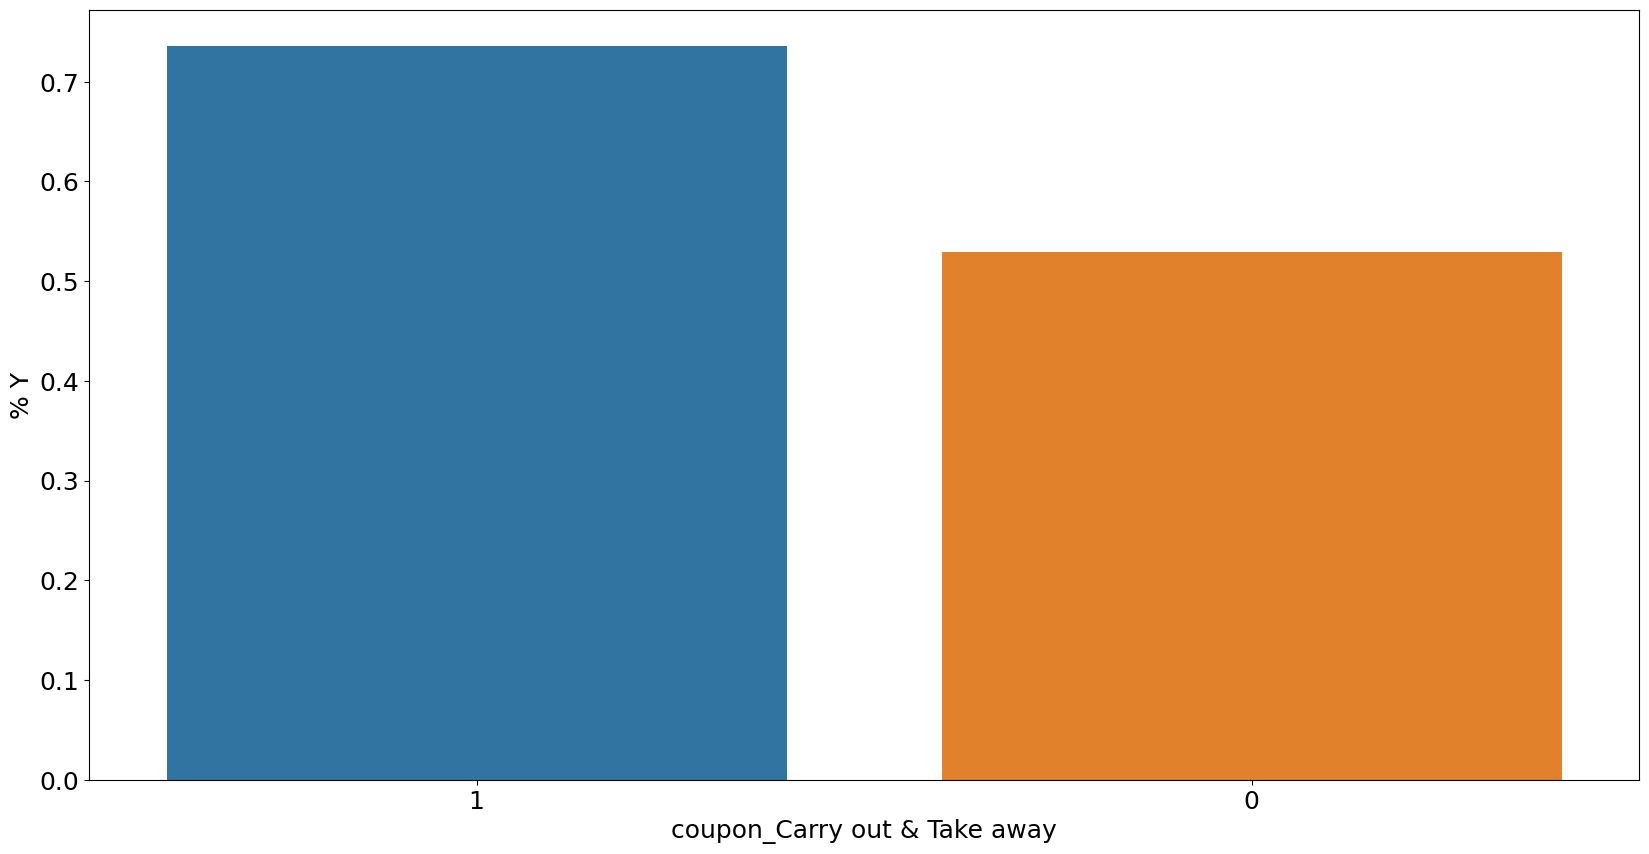

<Figure size 640x480 with 0 Axes>

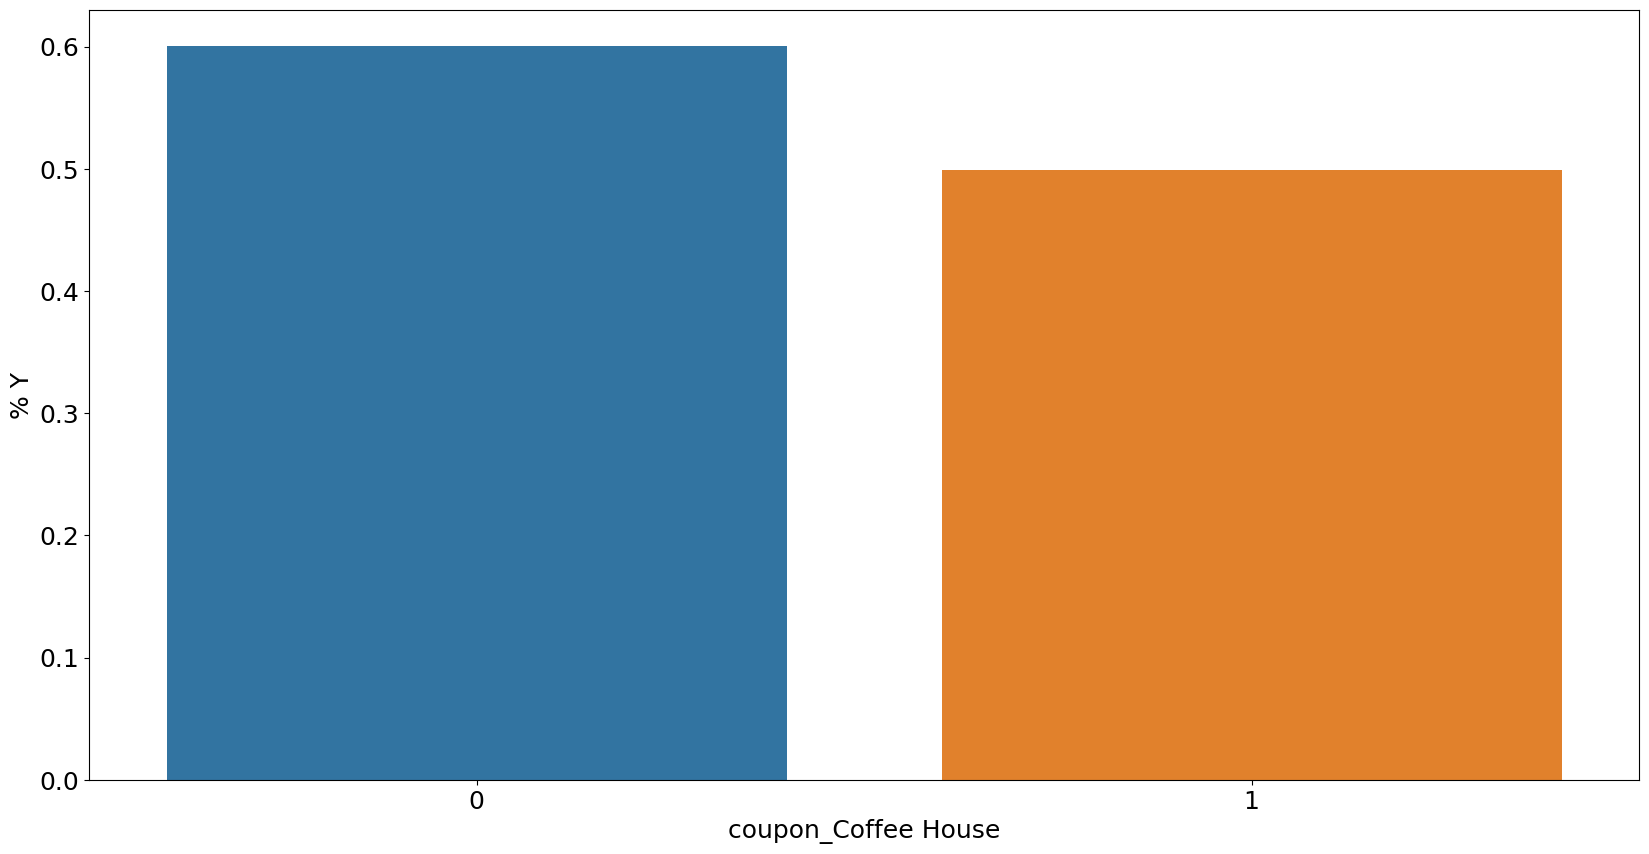

<Figure size 640x480 with 0 Axes>

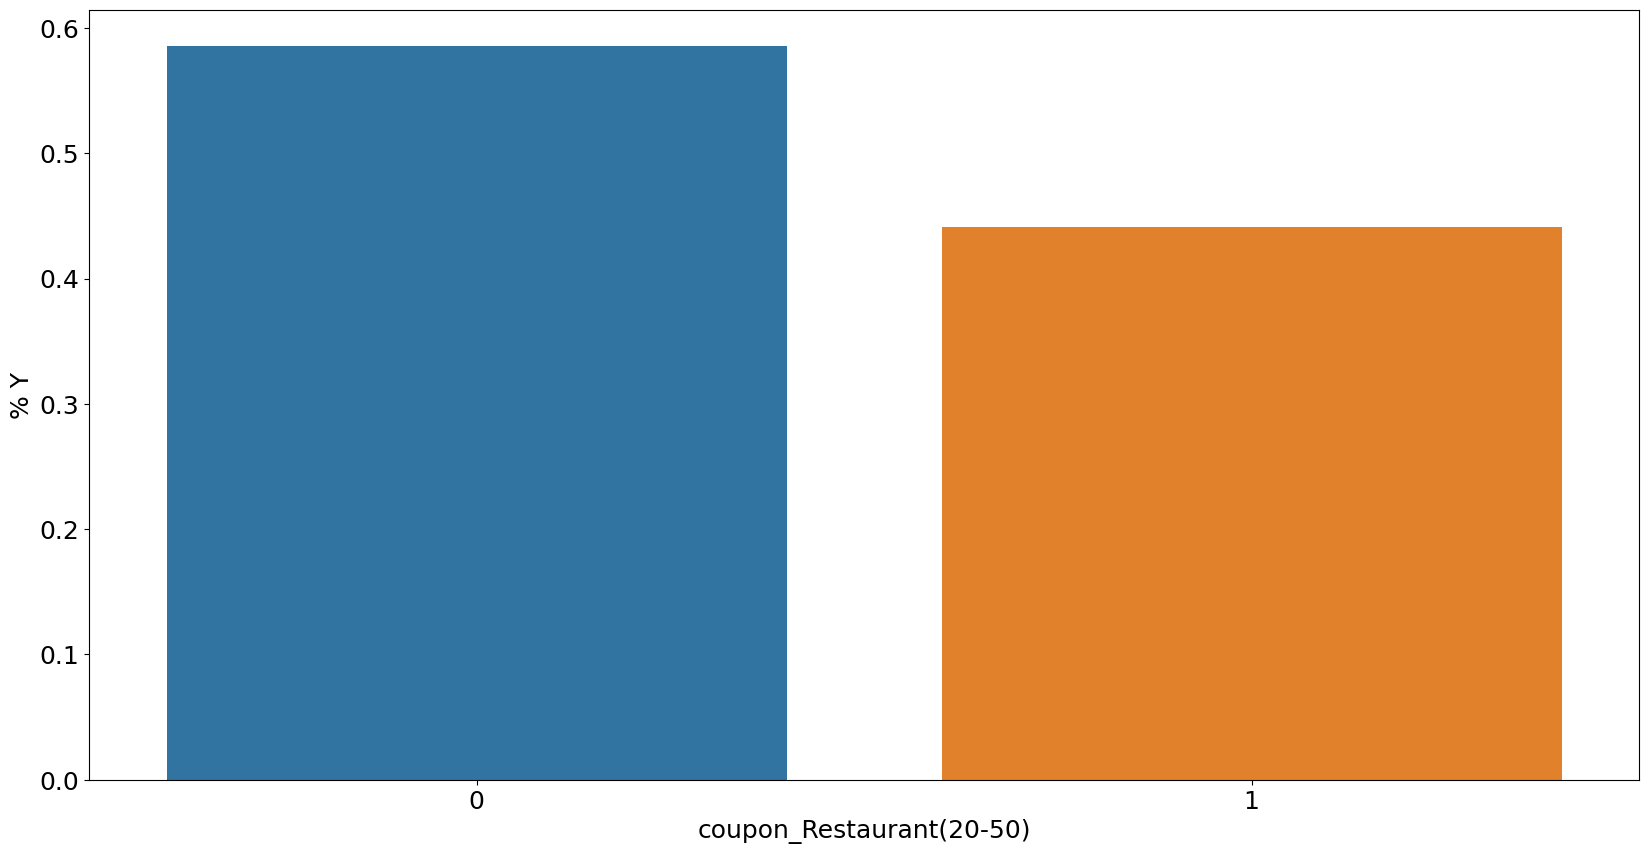

<Figure size 640x480 with 0 Axes>

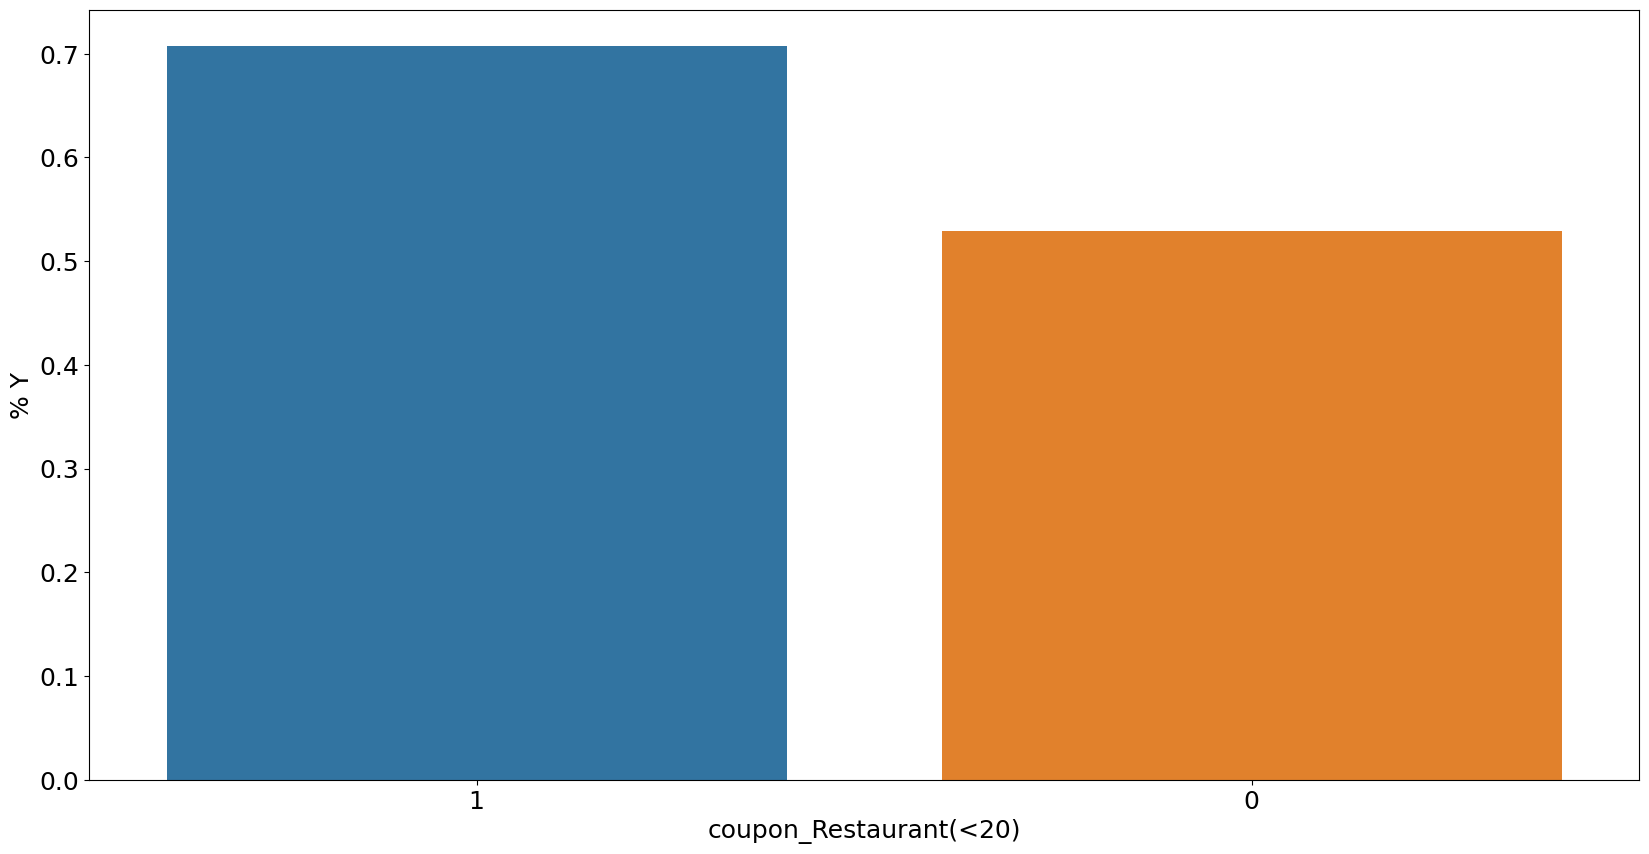

<Figure size 640x480 with 0 Axes>

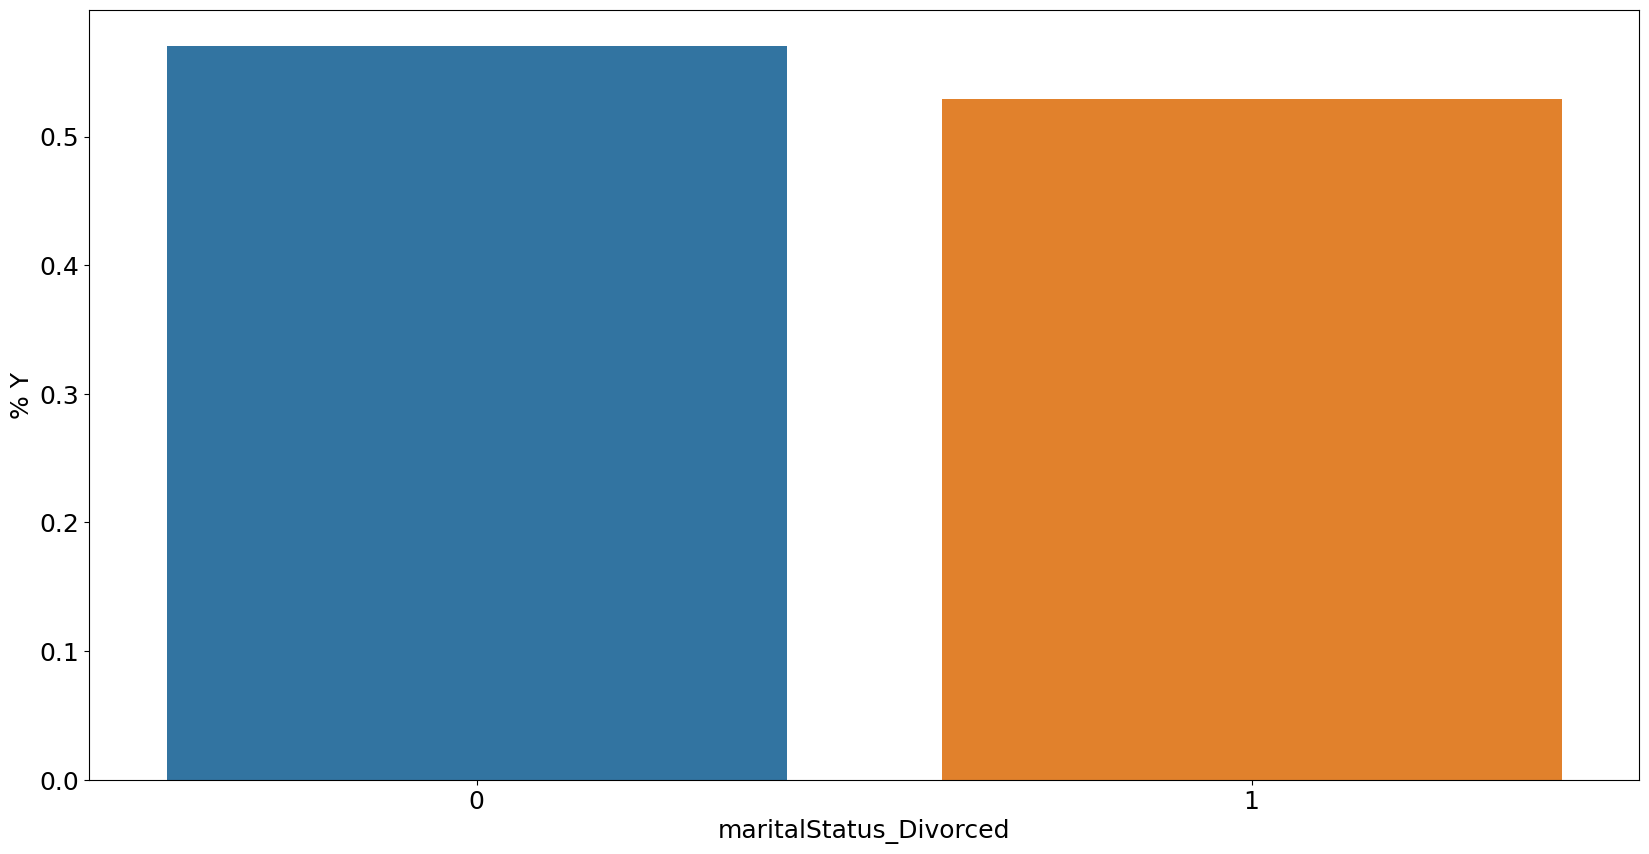

<Figure size 640x480 with 0 Axes>

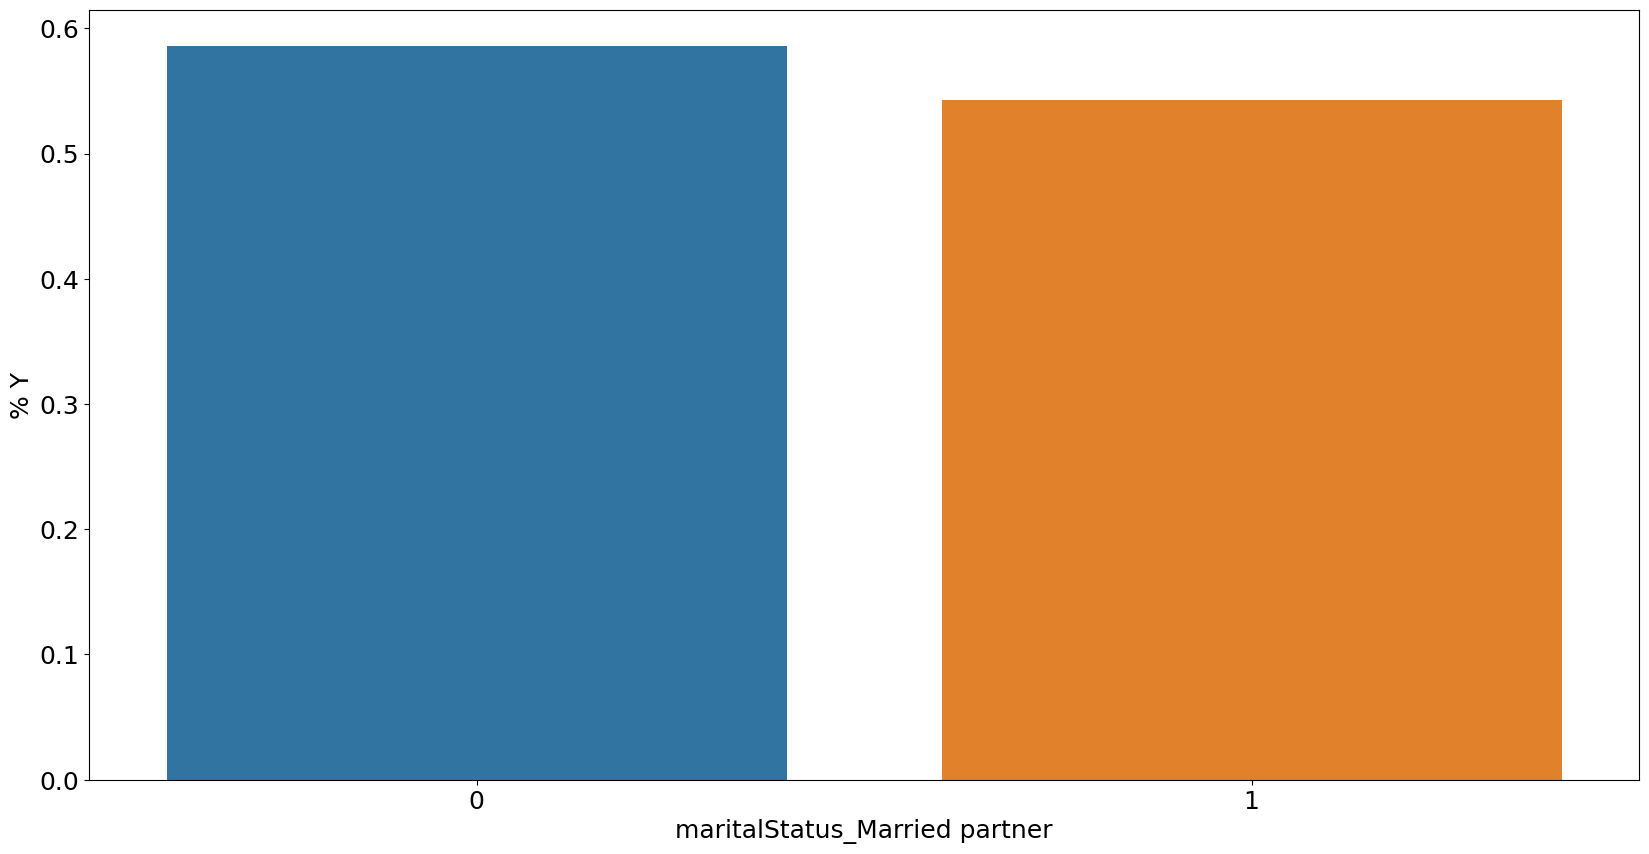

<Figure size 640x480 with 0 Axes>

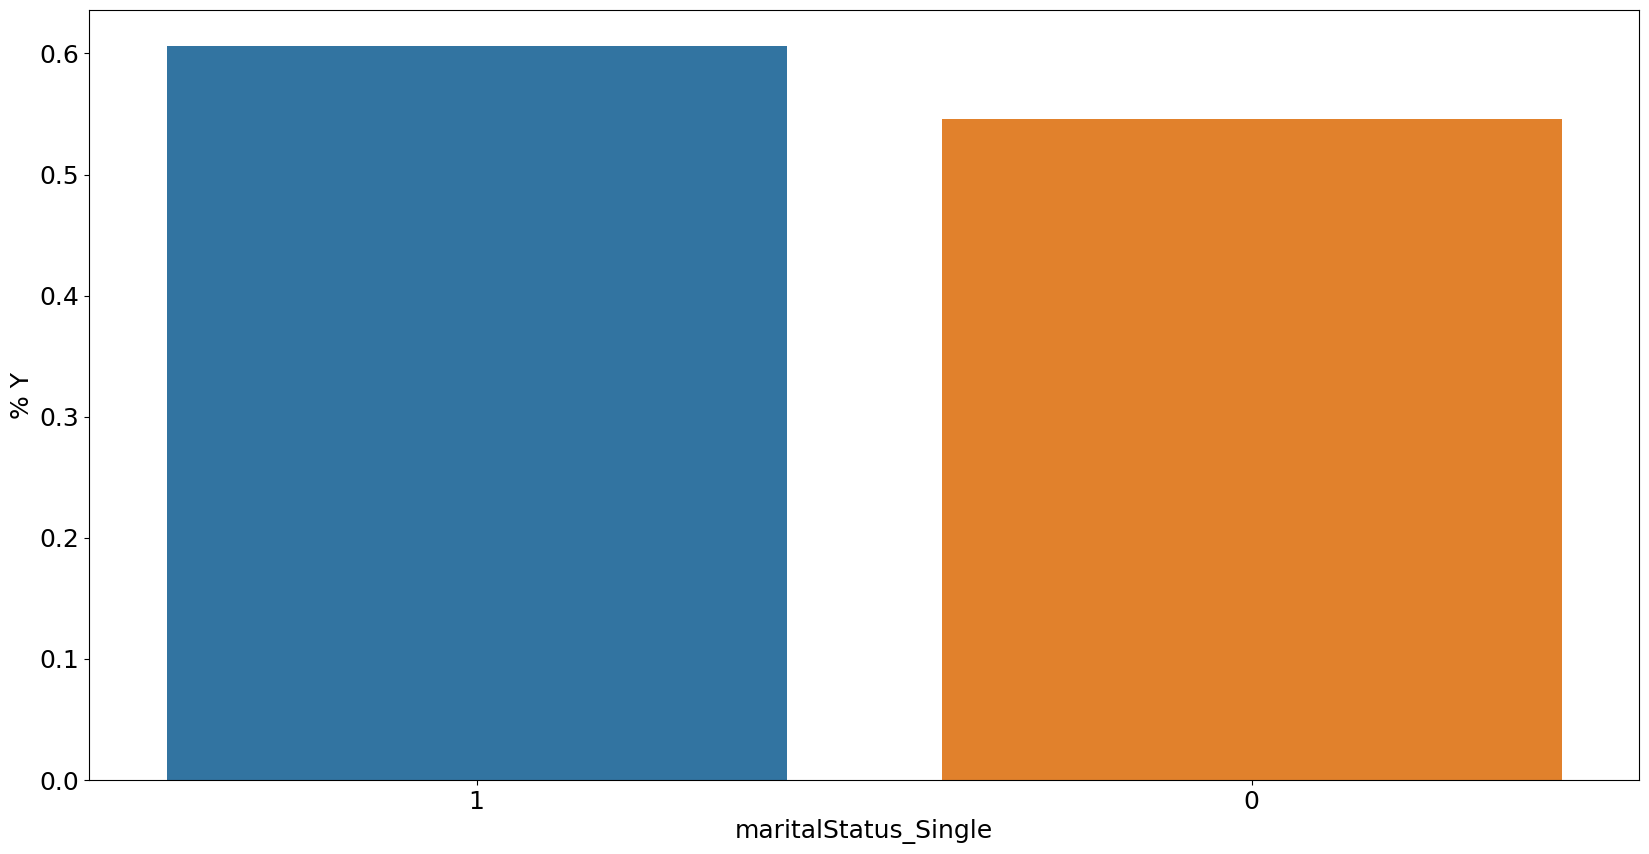

<Figure size 640x480 with 0 Axes>

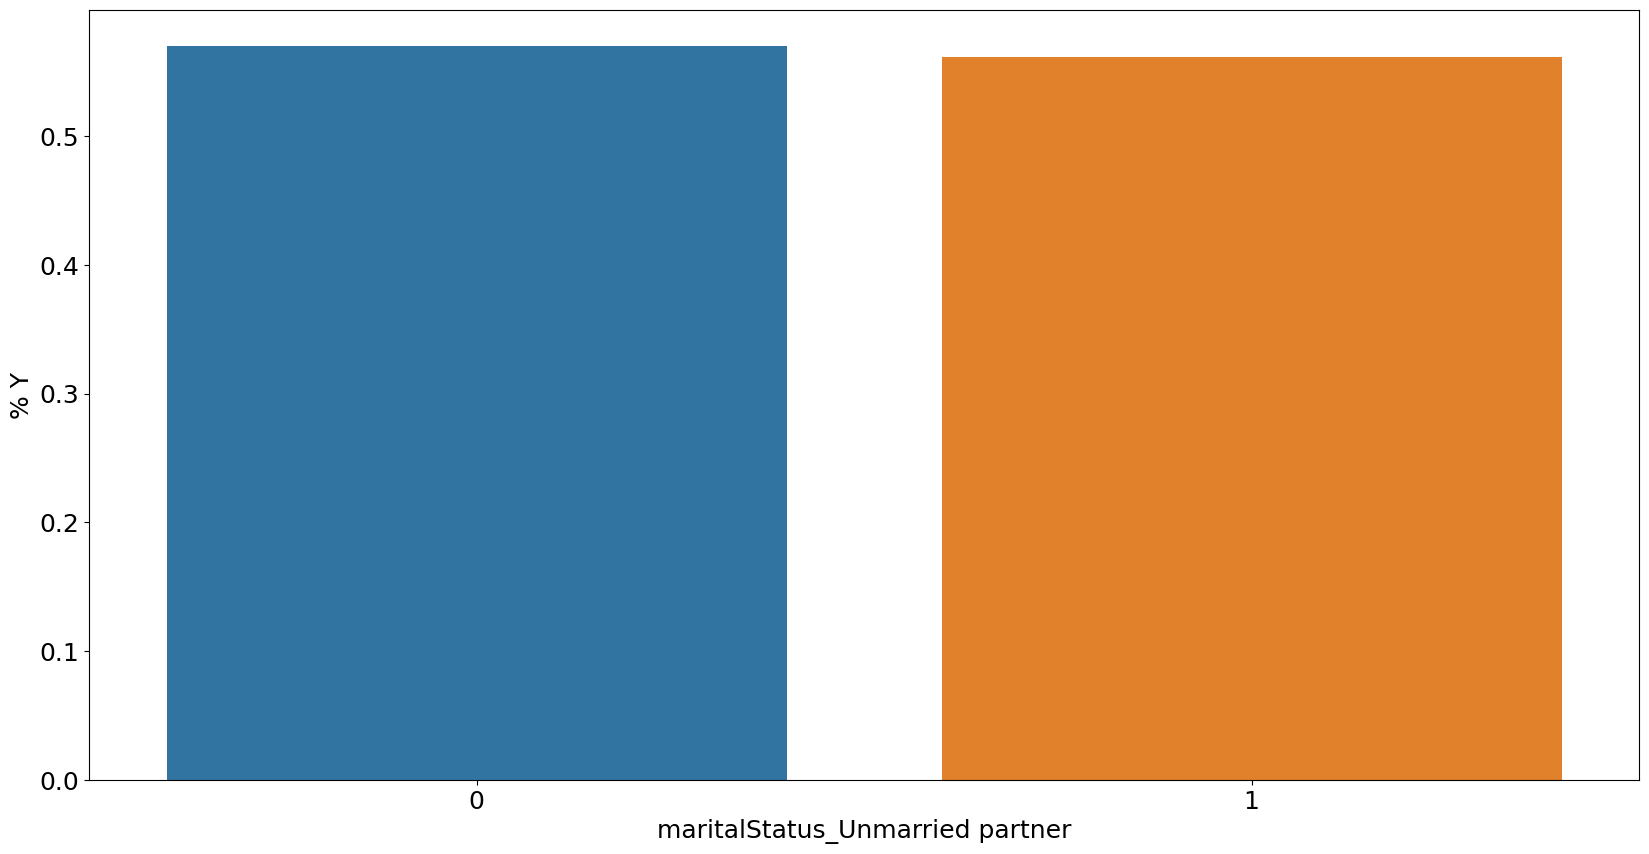

<Figure size 640x480 with 0 Axes>

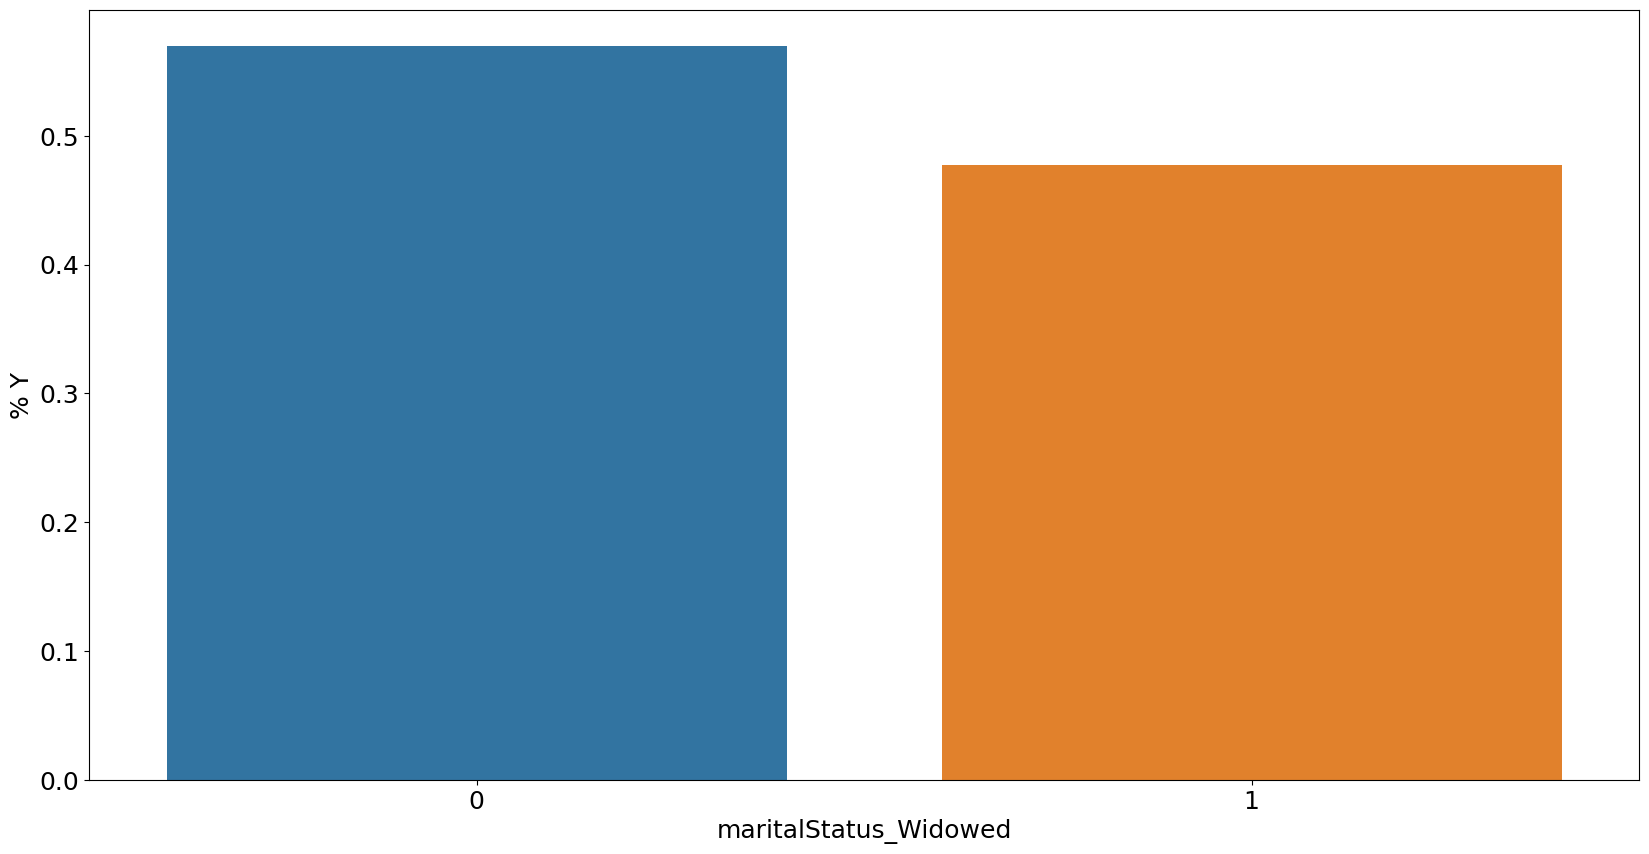

<Figure size 640x480 with 0 Axes>

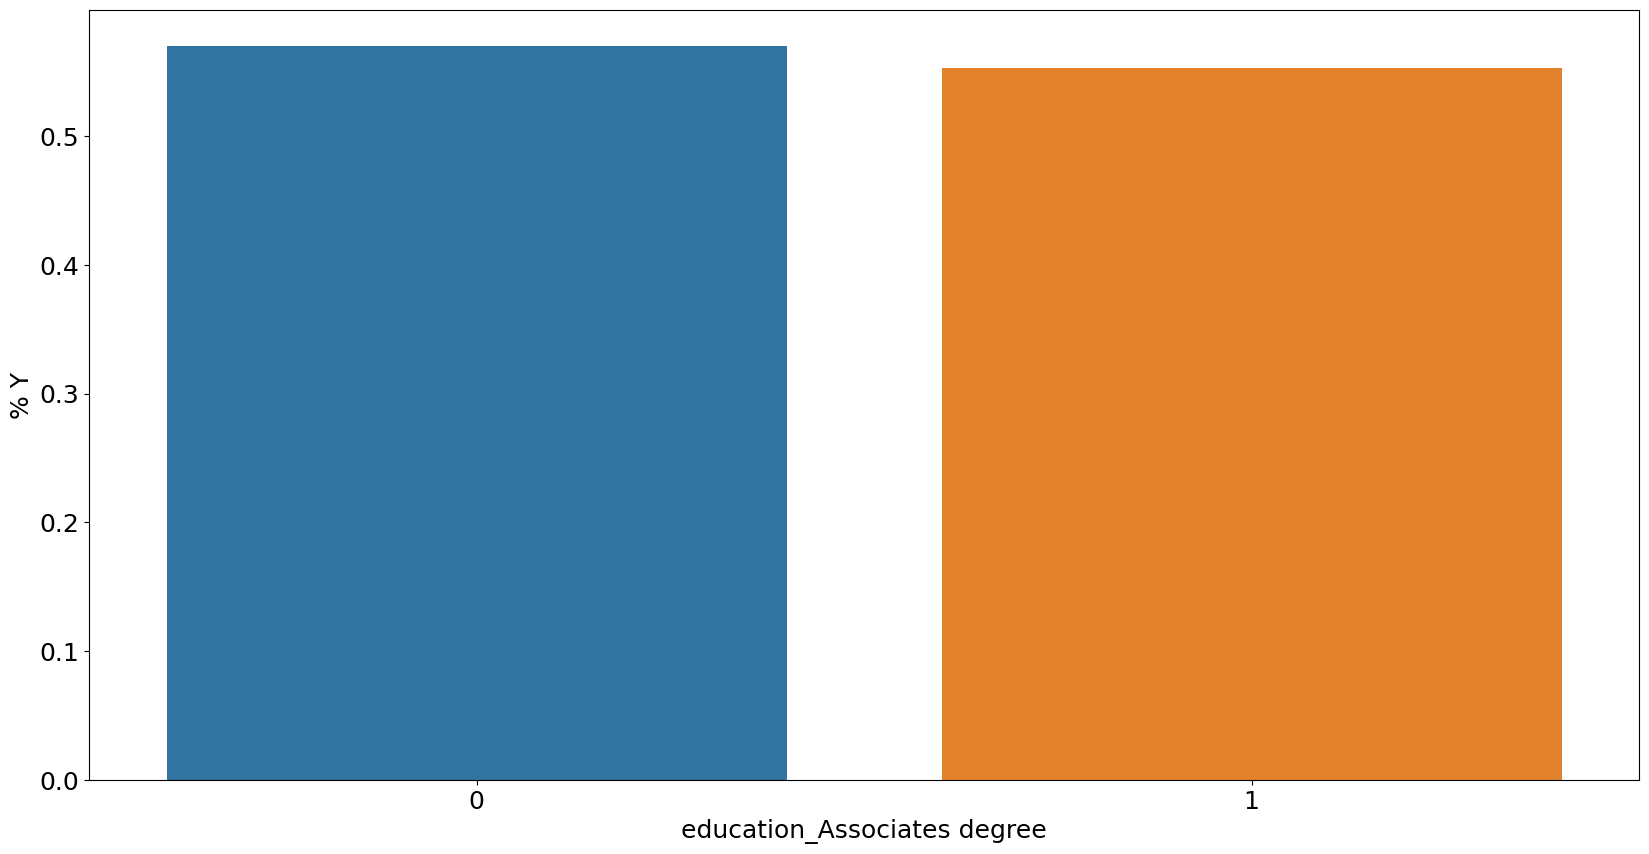

<Figure size 640x480 with 0 Axes>

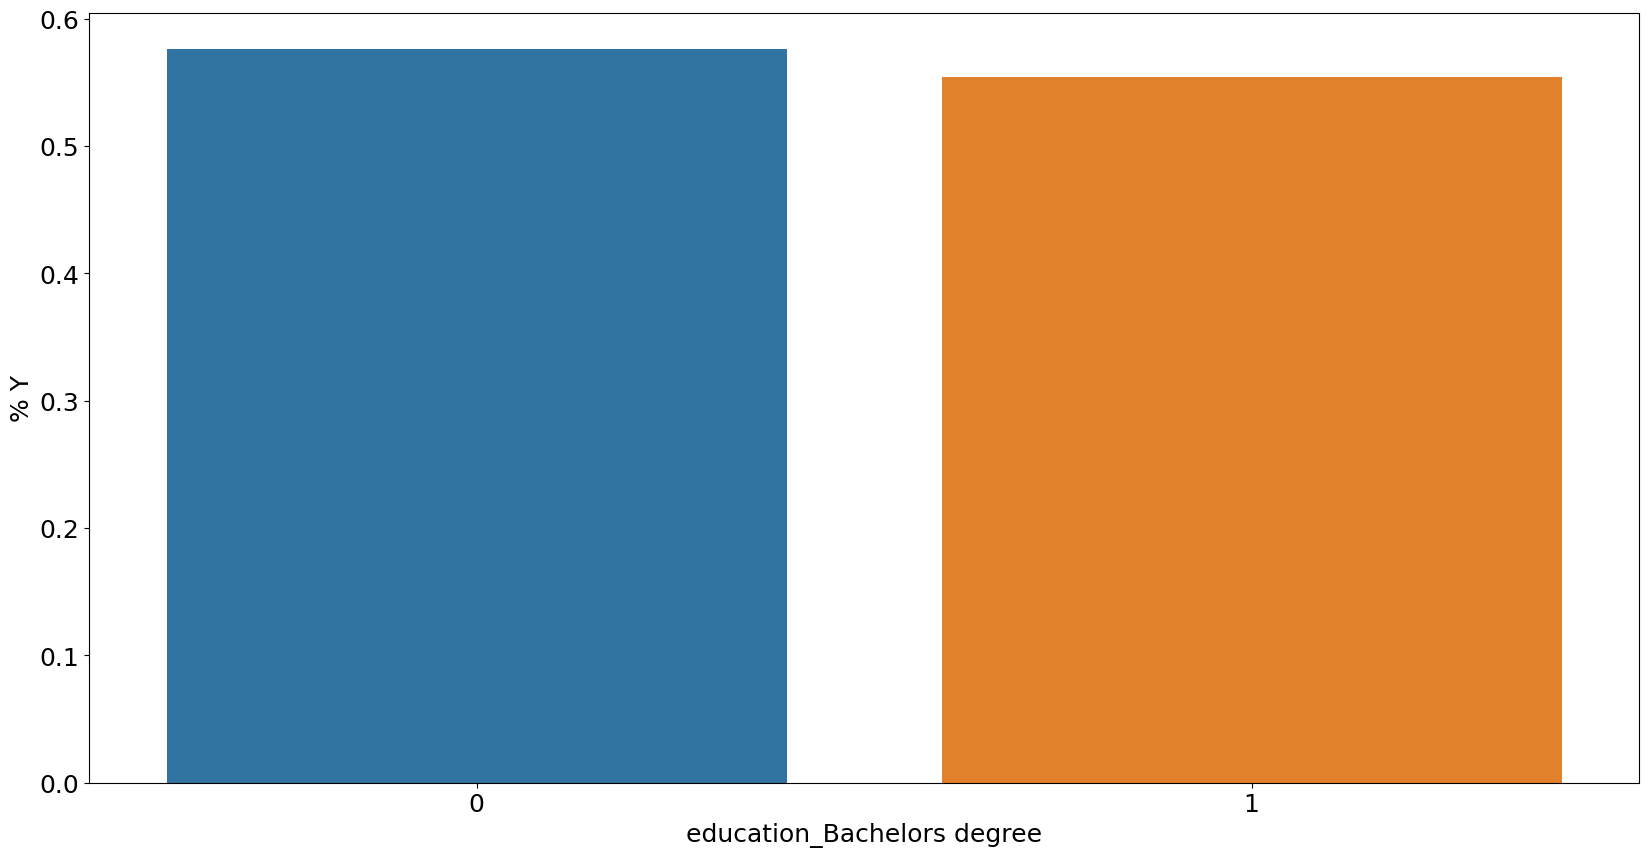

<Figure size 640x480 with 0 Axes>

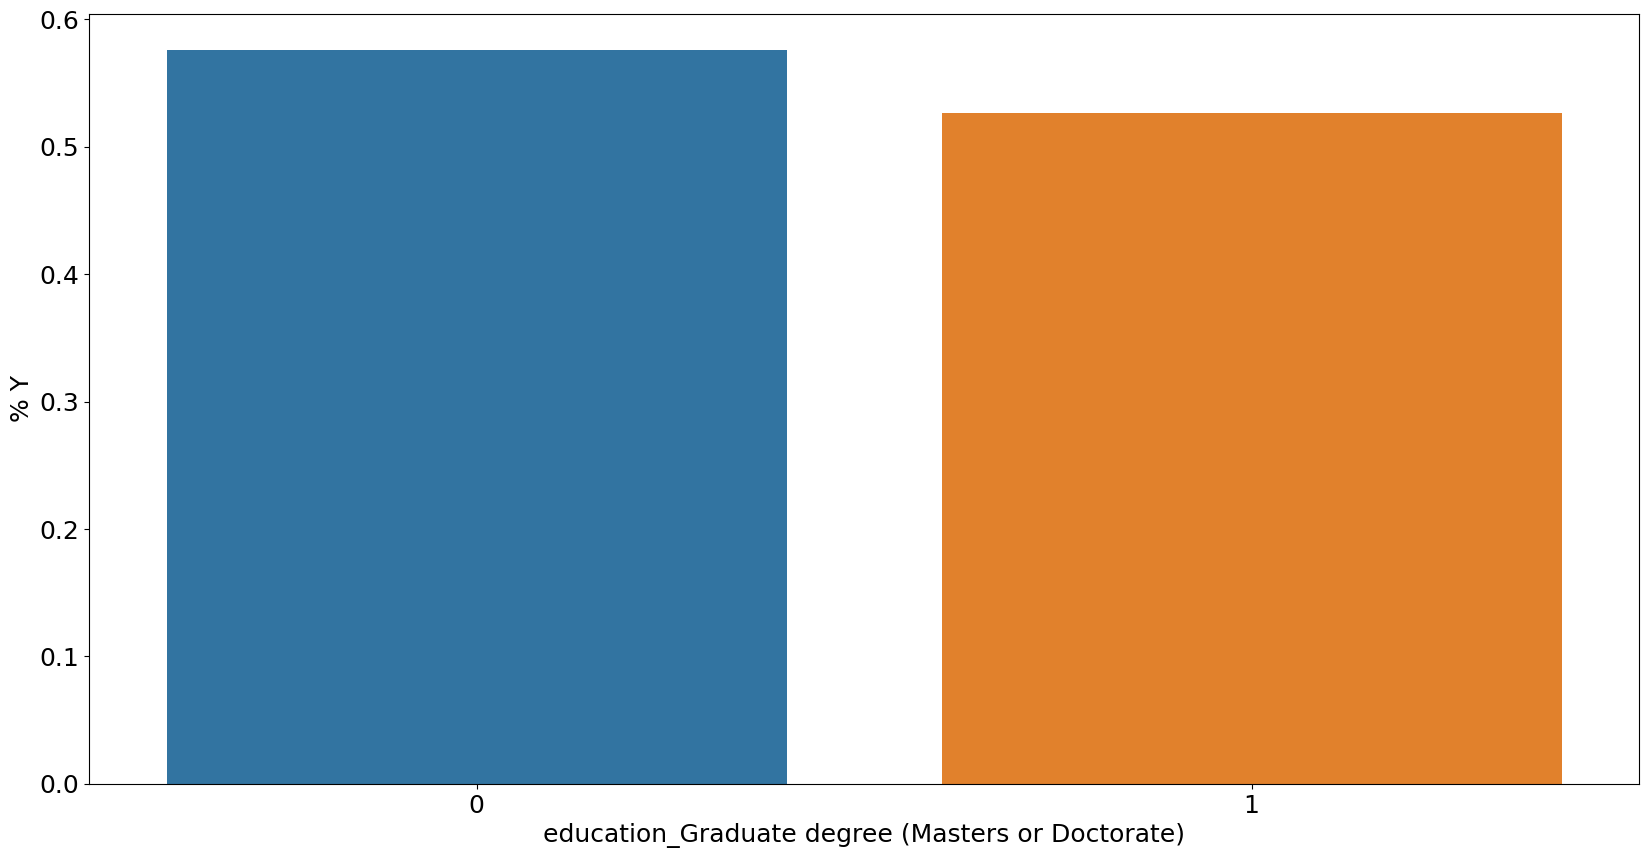

<Figure size 640x480 with 0 Axes>

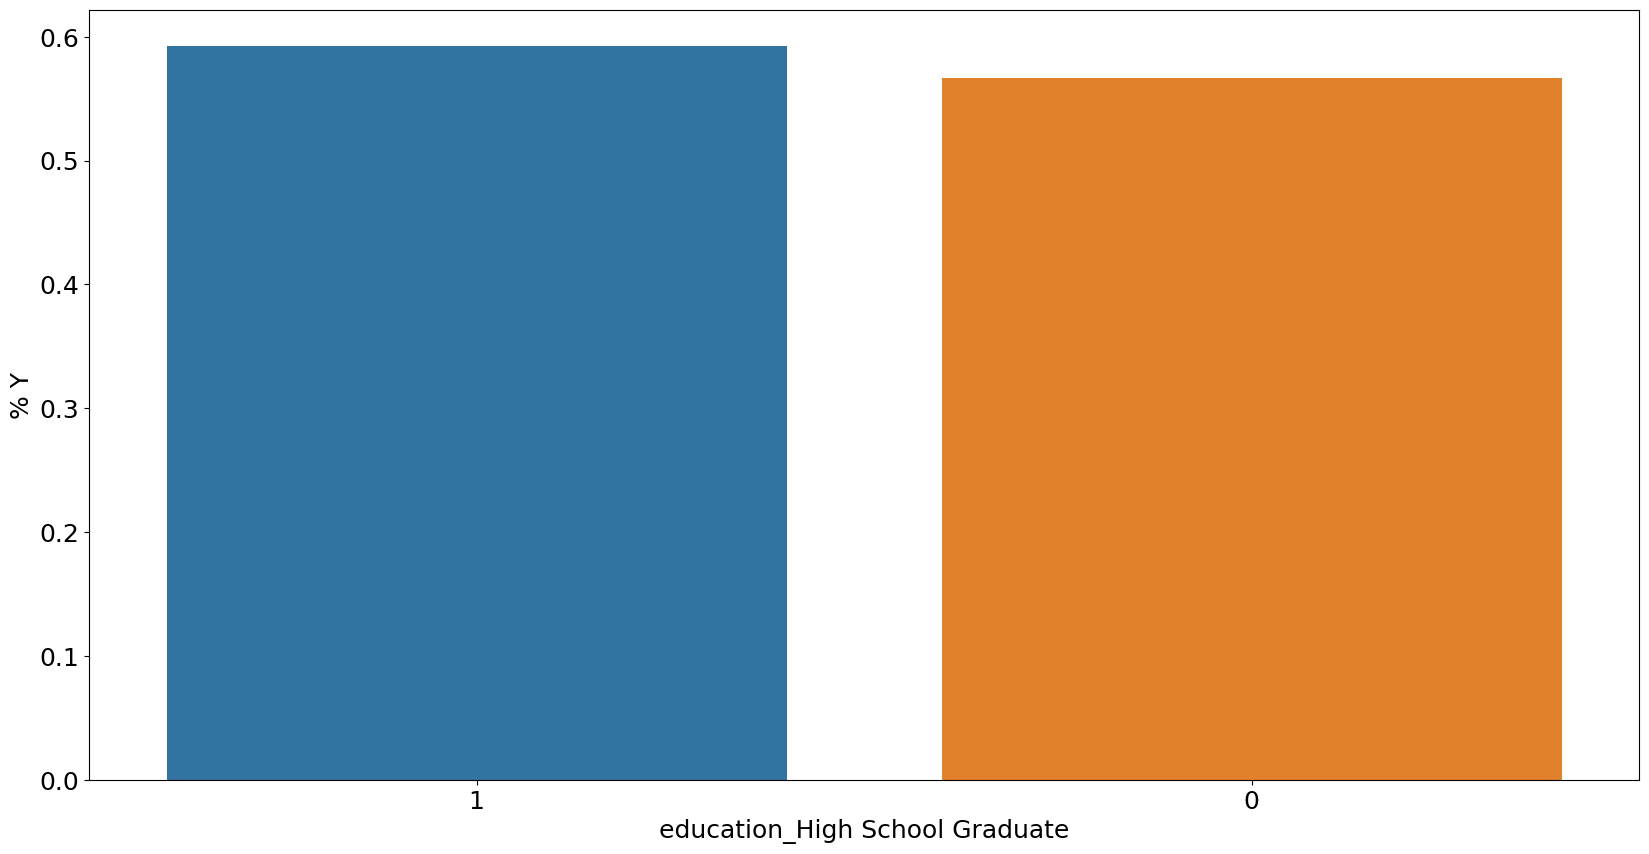

<Figure size 640x480 with 0 Axes>

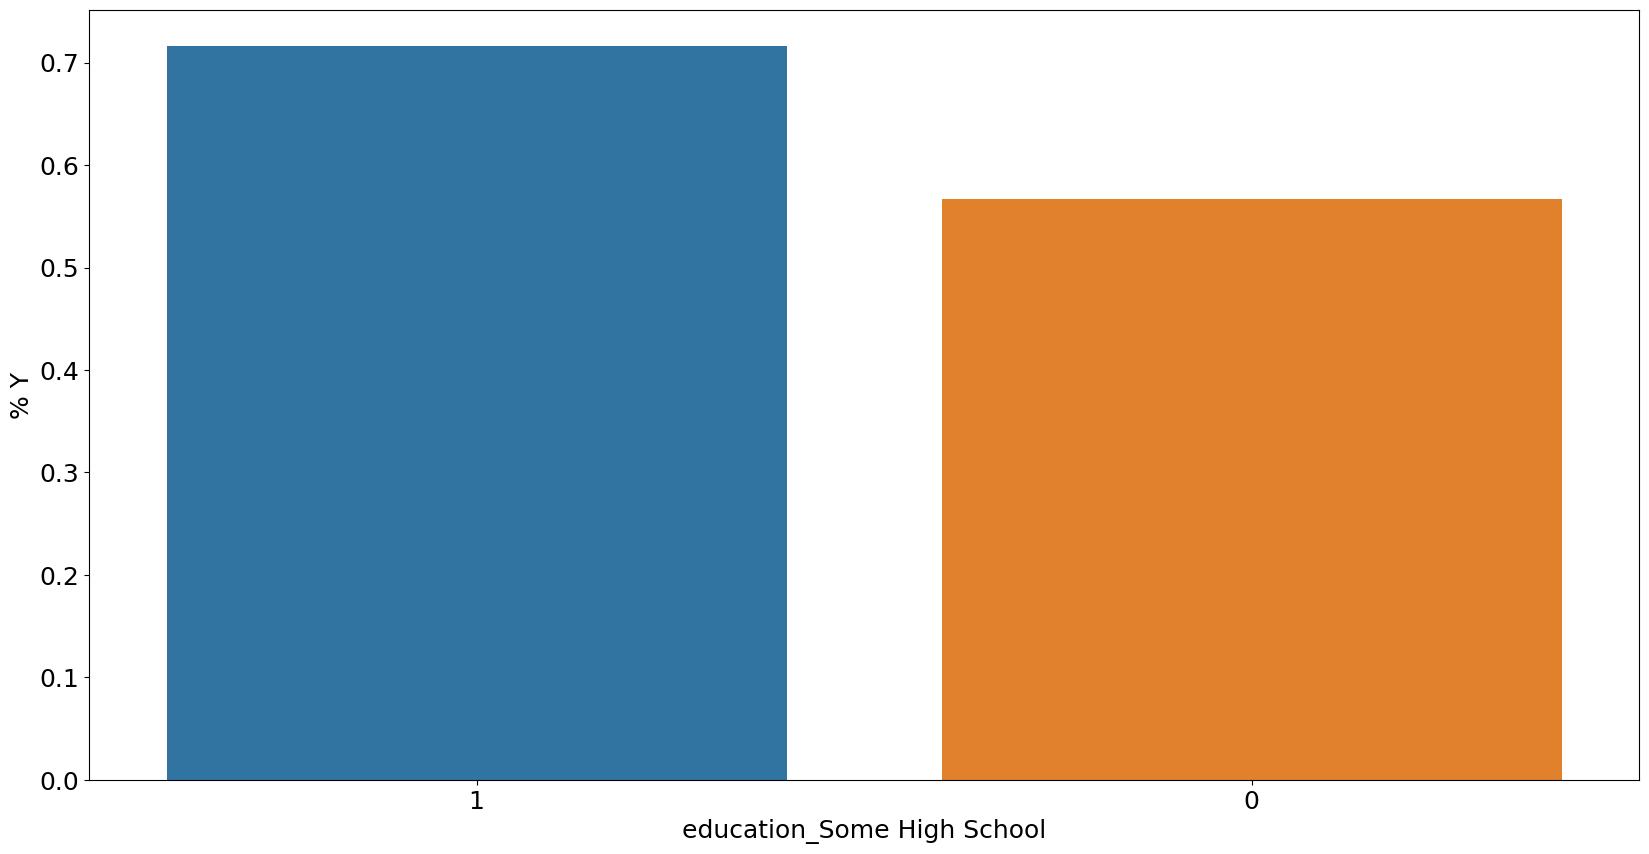

<Figure size 640x480 with 0 Axes>

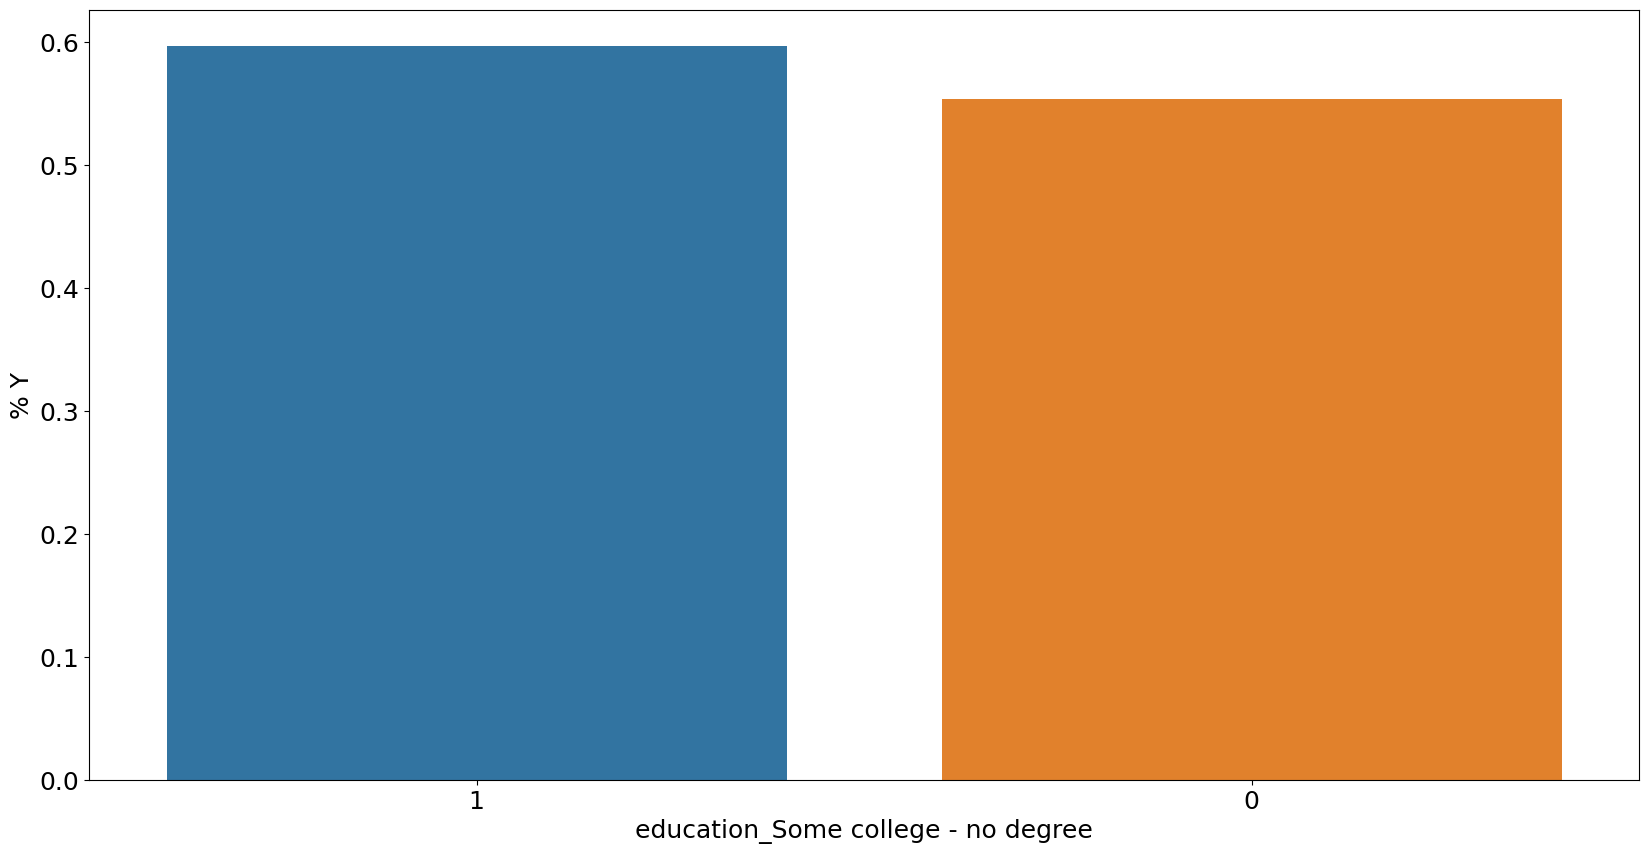

In [28]:
for f in train_encoded_droppedY:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of y=1 per category value
    cat_perc = train_encoded_dropped[[f, 'Y']].groupby([f], as_index=False)['Y'].mean()
    cat_perc.sort_values(by='Y', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='Y', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% Y', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

## Feature engineering

## Feature selection

### Removing features with low or zero variance

Sklearn has a handy method to do that: **VarianceThreshold**. By default it removes features with zero variance. 

In [29]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train_encoded_droppedY) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train_encoded_droppedY.columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

2 variables have too low variance.
These variables are ['toCoupon_GEQ5min', 'education_Some High School']


we'll let the classifier choose. For data sets with many more variables this could reduce the processing time.

Sklearn also comes with other [feature selection methods]. One of these methods is *SelectFromModel* in which you let another classifier select the best features and continue with these. Below we'll be using a Random Forest classifier.

### Selecting features with a Random Forest and SelectFromModel
Here we'll base feature selection on the feature importances of a random forest. 

In [33]:
X_train = train_encoded_droppedY
y_train = train_encoded_droppedY

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))


 1) time_encoded                   0.046469
 2) occupation_encoded             0.043985
 3) age_encoded                    0.043531
 4) income_encoded                 0.043379
 5) coffeeH _encoded               0.039476
 6) bar_encoded                    0.037273
 7) carryA_encoded                 0.037269
 8) resto20_encoded                0.037253
 9) resto20To50_encoded            0.035634
10) temperature                    0.034429
11) destination_No Urgent Place    0.033715
12) maritalStatus_Married partner  0.033518
13) passanger_Alone                0.033152
14) maritalStatus_Single           0.030776
15) education_Some college - no degree 0.029729
16) gender_encoded                 0.029324
17) toCoupon_GEQ15min              0.027939
18) has_children                   0.027841
19) education_Bachelors degree     0.027496
20) coupon_Coffee House            0.027012
21) expiration_encoded             0.026737
22) destination_Work               0.022185
23) weather_Sunny           

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the *get_support* method we can then limit the number of variables in the train data.

In [34]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])


Number of features before selection: 43
Number of features after selection: 22


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



## Feature scaling
As mentioned before, we can apply standard scaling to the training data. Some classifiers perform better when this is done.

In [35]:
scaler = StandardScaler()
scaler.fit_transform(train_encoded_droppedY)

array([[-0.43342979,  1.18937808,  0.        , ..., -0.27718523,
        -0.08358436,  1.38390459],
       [ 0.87179896,  1.18937808,  0.        , ..., -0.27718523,
        -0.08358436,  1.38390459],
       [ 0.87179896,  1.18937808,  0.        , ..., -0.27718523,
        -0.08358436,  1.38390459],
       ...,
       [-1.73865855, -0.84077554,  0.        , ..., -0.27718523,
        -0.08358436, -0.72259317],
       [-1.73865855, -0.84077554,  0.        , ..., -0.27718523,
        -0.08358436, -0.72259317],
       [ 0.87179896, -0.84077554,  0.        , ..., -0.27718523,
        -0.08358436, -0.72259317]])